In [ ]:
from pybaseball import statcast
import pandas as pd
import pickle

# Define MLB season ranges (approx Opening Day to end of October)
season_dates = {
    2017: ("2017-04-02", "2017-10-30"),
    2018: ("2018-03-29", "2018-10-30"),
    2019: ("2019-03-28", "2019-10-30"),
    2020: ("2020-07-23", "2020-10-30"),  # shortened season
    2021: ("2021-04-01", "2021-10-30"),
    2022: ("2022-04-07", "2022-10-30"),
    2023: ("2023-03-30", "2023-10-30"),
    2024: ("2024-03-28", "2024-10-30"),
}

for year, (start_date, end_date) in season_dates.items():
    print(f"Fetching season {year}...")
    try:
        data = statcast(start_dt=start_date, end_dt=end_date)

        # Save to pickle
        filename = f"statcast_{year}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(data, f)

        print(f"Saved {year} to {filename} with {len(data)} rows.")
    except Exception as e:
        print(f"Failed to fetch {year}: {e}")

In [73]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pybaseball import pitching_stats, playerid_reverse_lookup, playerid_lookup
import statsapi
from scipy.stats import zscore
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import umap
from sklearn.manifold import TSNE
import hdbscan
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
dfs = []
for year in range(2017, 2025):
    print(f"Loading {year}...")
    with open(f"datasets/statcast_{year}.pkl", "rb") as f:
        df = pickle.load(f)
    
    # Downcast numeric types to save memory
    df = df.apply(pd.to_numeric, errors="ignore", downcast="integer")
    df = df.apply(pd.to_numeric, errors="ignore", downcast="float")
    
    # Convert object columns with few unique values to category
    for col in df.select_dtypes(include="object").columns:
        if df[col].nunique() < 50:  
            df[col] = df[col].astype("category")
    
    dfs.append(df)

print("Concatenating all years...")
full_df = pd.concat(dfs, ignore_index=True)

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm

BASE_URL = "https://statsapi.mlb.com/api/v1"
SPORT_ID = 11    # Minor League Baseball
LEVEL_ID = 11    # Triple-A
SEASON = 2024

def get_schedule(season=SEASON):
    """Fetch all Triple-A games for a season."""
    url = f"{BASE_URL}/schedule?sportId={SPORT_ID}&levelIds={LEVEL_ID}&season={season}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    game_pks = []
    for date in data.get("dates", []):
        for game in date.get("games", []):
            game_pks.append(game["gamePk"])
    return game_pks

def get_pitches_for_game(gamePk):
    """Fetch pitch-by-pitch data for a given gamePk."""
    url = f"{BASE_URL}.1/game/{gamePk}/feed/live"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    all_pitches = []
    for play in data.get("liveData", {}).get("plays", {}).get("allPlays", []):
        for event in play.get("playEvents", []):
            if "details" in event and "pitchData" in event:
                pitch = {
                    "gamePk": gamePk,
                    "inning": play.get("about", {}).get("inning"),
                    "batterId": play.get("matchup", {}).get("batter", {}).get("id"),
                    "pitcherId": play.get("matchup", {}).get("pitcher", {}).get("id"),
                    "pitchType": event.get("details", {}).get("type", {}).get("description"),
                    "description": event.get("details", {}).get("description"),
                    "startSpeed": event.get("pitchData", {}).get("startSpeed"),
                    "endSpeed": event.get("pitchData", {}).get("endSpeed"),
                    "strikeZoneTop": event.get("pitchData", {}).get("strikeZoneTop"),
                    "strikeZoneBottom": event.get("pitchData", {}).get("strikeZoneBottom"),
                    "coordinates": event.get("pitchData", {}).get("coordinates"),
                    "call": event.get("details", {}).get("call", {}).get("description")
                }
                all_pitches.append(pitch)
    return all_pitches

def main():
    game_pks = get_schedule()
    all_pitches = []

    for gamePk in tqdm(game_pks, desc="Processing games"):
        try:
            pitches = get_pitches_for_game(gamePk)
            all_pitches.extend(pitches)
        except Exception as e:
            print(f"Error with game {gamePk}: {e}")

    df = pd.DataFrame(all_pitches)
    df.to_csv("AAA_2024_pitches.csv", index=False)
    print(f"Saved {len(df)} pitches to AAA_2024_pitches.csv")

if __name__ == "__main__":
    main()


In [ ]:
print(list(full_df.columns))
df = full_df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'p_throws', 'game_year', 'game_type', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'game_pk', 'spin_axis', 'pitcher_days_since_prev_game', 'arm_angle']]

# only regular season
df = df[df['game_type']=='R']

def fetch_position(id):
    """Fetch primary positions for a list of MLBAM IDs in batches."""
    player_data = statsapi.get("person", {"personId": id})
    player_info = player_data["people"][0]
    pos = player_info["primaryPosition"]["abbreviation"]
    return pos

# Example: get all unique pitcher IDs from dataset
unique_pitchers = df["pitcher"].unique().tolist()

# Fetch positions in bulk
positions = {}
for id in unique_pitchers:
    pos = fetch_position(int(id))
    positions[id] = pos
# Filter only pitchers
pitcher_ids = [pid for pid, pos in positions.items() if pos == "P" or pos == "TWP"]

df = df[df["pitcher"].isin(pitcher_ids)]


num_pitcher_seasons = df.groupby(["pitcher", "game_year"]).ngroups
print("Number of pitcher-seasons:", num_pitcher_seasons)
print(list(df.columns))
pitcher_seasons = df.groupby(["pitcher", "game_year"])
pitcher_seasons_pitches = df.groupby(["pitcher", "game_year", "pitch_type"])
print(pitcher_seasons_pitches.head())

In [ ]:
filename = f"pitch_df.pkl"
with open(filename, "wb") as f:
    pickle.dump(df, f)

In [2]:
with open(f"datasets/pitch_df.pkl", "rb") as f:
        df = pickle.load(f)
df = df.drop(['vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pitcher_days_since_prev_game', 'arm_angle', 'game_pk', 'game_type', 'effective_speed', 'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in'], axis=1)
print(df.columns)

Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'p_throws', 'game_year', 'pfx_x', 'pfx_z',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis'],
      dtype='object')


In [ ]:
for col in statcast_qualified.columns:
    if pd.api.types.is_numeric_dtype(statcast_qualified[col]):
        print(f"{col} min: {df[col].min()}")
        print(f"{col} mean: {df[col].mean()}")
        print(f"{col} max: {df[col].max()}")
        print(f"{col} missing: {df[col].isnull().sum()}")
        print(f"{col} total: {len(df[col])}")
        

print((df['release_pos_z']<0).sum())

In [ ]:
pitcher_seasons.size().describe()
df.isna().mean().sort_values()

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df, x="release_speed", hue="game_year", common_norm=False, alpha=0.3)
plt.xlim(60, 105)
plt.title("Distribution of Release Speed by Year")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="game_year", y="release_speed")
plt.xticks(rotation=90)
plt.title("Release Speed Distribution by Year")
plt.show()

In [ ]:
missing_by_year = (
    df.groupby("game_year")
      .apply(lambda g: g.isna().mean())
)

# Now columns are features, rows are years
print(missing_by_year)

In [ ]:
# Count pitches by type per year
pitch_counts = df.groupby('game_year')['pitch_type'].value_counts(normalize=True).rename('proportion').reset_index()

# Now 'pitch_counts' has columns: game_year, pitch_type, proportion
print(pitch_counts.head())

# Plot stacked bar chart
pivot = pitch_counts.pivot(index='game_year', columns='pitch_type', values='proportion')
pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel('Proportion of Pitches')
plt.title('League-wide Pitch Type Proportions Over Time')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
fastball_types = ['FA', 'FC', 'FF', 'FS', 'SI']

fastballs = df[df['pitch_type'].isin(fastball_types)]
fastballs = fastballs[fastballs['release_speed']>=70]
fb_stats = fastballs.groupby("game_year")['release_speed'].agg(['mean', 'median', 'std', 'count'])
print(fb_stats)
plt.figure(figsize=(12,6))
plt.plot(fb_stats.index, fb_stats['mean'], marker='o', label='Mean')
plt.plot(fb_stats.index, fb_stats['median'], marker='x', label='Median')
plt.fill_between(fb_stats.index, 
                 fb_stats['mean'] - fb_stats['std'], 
                 fb_stats['mean'] + fb_stats['std'], 
                 color='gray', alpha=0.2, label='±1 std')
plt.xlabel('Year')
plt.ylabel('Fastball Velocity (mph)')
plt.title('League-wide Fastball Velocity by Year')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=fastballs, x='game_year', y='release_speed')
plt.xticks(rotation=90)
plt.title('Distribution of Fastball Velocity by Year')
plt.ylabel('Fastball Velocity (mph)')
plt.show()

In [ ]:
# Map each pitch_type to a broader group
pitch_group_map = {
    'FA': 'Fastball', 'FF': 'Fastball', 'FC': 'Fastball', 'FS': 'Fastball',
    'SL': 'Slider', 'CU': 'Curveball', 'CH': 'Changeup', 'SI': 'Fastball',  # include SI (sinker) in fastballs
    # add others if desired
}

# Create a new column with the group
df['pitch_group'] = df['pitch_type'].map(pitch_group_map)

# Drop any pitch types not mapped
subset = df.dropna(subset=['pitch_group'])

# Group by year and pitch group
mean_vel_group = subset.groupby(['game_year', 'pitch_group'])['release_speed'].mean().unstack()
plt.figure(figsize=(12,6))

for group in mean_vel_group.columns:
    plt.plot(mean_vel_group.index, mean_vel_group[group], marker='o', label=group)

plt.xlabel('Year')
plt.ylabel('Mean Velocity (mph)')
plt.title('Mean Pitch Velocities by Year and Pitch Group')
plt.legend(title='Pitch Group', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

In [ ]:
# Map each pitch_type to a broader group
pitch_group_map = {
    'FA': 'Fastball', 'FF': 'Fastball', 'FC': 'Fastball', 'FS': 'Fastball',
    'SL': 'Slider', 'CU': 'Curveball', 'CH': 'Changeup', 'SI': 'Fastball',  # include SI (sinker) in fastballs
    # add others if desired
}

# Create a new column with the group
df['pitch_group'] = df['pitch_type'].map(pitch_group_map)

# Drop any pitch types not mapped
subset = df.dropna(subset=['pitch_group'])

# Group by year and pitch group
mean_spin_group = subset.groupby(['game_year', 'pitch_group'])['release_spin_rate'].mean().unstack()
plt.figure(figsize=(12,6))

for group in mean_spin_group.columns:
    plt.plot(mean_spin_group.index, mean_spin_group[group], marker='o', label=group)

plt.xlabel('Year')
plt.ylabel('Mean Spin Rate (rpm)')
plt.title('Mean Pitch Spin Rates by Year and Pitch Group')
plt.legend(title='Pitch Group', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

In [ ]:

avg_release = (
    fastballs.groupby(["pitcher", "game_year", "p_throws"])
             .agg({
                 "release_pos_x":"mean",
                 "release_pos_z":"mean",
                 "release_speed":"mean"
             })
             .reset_index()
)

# Convert to standard floats
avg_release = avg_release.astype({
    "release_pos_x": float,
    "release_pos_z": float,
    "release_speed": float
})

lefties = avg_release[avg_release["p_throws"] == "L"]
righties = avg_release[avg_release["p_throws"] == "R"]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True, sharex=True)

# Righties
sns.scatterplot(
    data=righties,
    x="release_pos_x", y="release_pos_z",
    hue="release_speed", palette="viridis", s=60, alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("RHP Release Point vs Velocity")
axes[0].set_xlabel("Release Position X (ft)")
axes[0].set_ylabel("Release Position Z (ft)")

# Lefties
sns.scatterplot(
    data=lefties,
    x="release_pos_x", y="release_pos_z",
    hue="release_speed", palette="viridis", s=60, alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("LHP Release Point vs Velocity")
axes[1].set_xlabel("Release Position X (ft)")
axes[1].set_ylabel("Release Position Z (ft)")

# Shared colorbar
norm = plt.Normalize(avg_release["release_speed"].min(), avg_release["release_speed"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axes, orientation="vertical", label="Velocity (mph)")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df[df['pitch_type'].isin(['FF','SL','CU','CH','SI'])],
    x='pitch_type', y='release_speed', inner='quartile'
)
plt.title("League-wide Variability of Pitch Velocity by Type")
plt.xlabel("Pitch Type")
plt.ylabel("Velocity (mph)")
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(
    data=df[df['pitch_type'].isin(['FF','SL','CU','CH','SI'])],
    x='pitch_type', y='release_spin_rate', inner='quartile'
)
plt.title("League-wide Variability of Pitch Spin Rate by Type")
plt.xlabel("Pitch Type")
plt.ylabel("Velocity (mph)")
plt.show()

In [ ]:
sns.scatterplot(
    data=df.sample(5000), 
    x="release_speed", y="release_spin_rate", 
    hue="pitch_type", alpha=0.5
)

In [ ]:
features = [
    'release_speed', 'effective_speed', 'release_spin_rate', 'spin_axis',
    'release_extension', 'release_pos_x', 'release_pos_z', 'release_pos_y',
    'pfx_x', 'pfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0',
    'pitcher_days_since_prev_game', 'api_break_x_arm',
    'api_break_x_batter_in'
]

corr = df[features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap of Pitch Features")
plt.show()


In [ ]:
sns.clustermap(corr, cmap='coolwarm', vmin=-1, vmax=1, figsize=(10,8))


In [ ]:
print(df['pitch_type'].unique())

In [3]:
def get_qualified_pitchers(year):
    df = pitching_stats(year, qual=1)
    
    # role classification: starter if majority of games are starts
    df['role'] = df.apply(lambda row: 'starter' if row['GS'] / row['G'] >= 0.5 else 'reliever', axis=1)
    
    # filter by innings
    if year != 2020:
        qualified = df[
            ((df['role'] == 'starter') & (df['IP'] >= 108)) |
            ((df['role'] == 'reliever') & (df['IP'] >= 54))
        ].copy()
    else:
        qualified = df[
            ((df['role'] == 'starter') & (df['IP'] >= 40)) |
            ((df['role'] == 'reliever') & (df['IP'] >= 20))
        ].copy()
    
    qualified['year'] = year
    return qualified

# Loop over seasons
qualified_all = pd.concat([get_qualified_pitchers(y) for y in range(2017, 2025)], ignore_index=True)

# Get unique FanGraphs IDs
fg_ids = qualified_all['IDfg'].unique().tolist()

# Map to MLBAM IDs
id_map = playerid_reverse_lookup(fg_ids, key_type='fangraphs')

# Merge the IDs onto your qualified pitcher list
qualified_all = qualified_all.merge(id_map[['key_fangraphs', 'key_mlbam']], 
                                    left_on='IDfg', right_on='key_fangraphs', 
                                    how='left')

# Clean up
qualified_all.rename(columns={'key_mlbam': 'mlbam_id'}, inplace=True)
qualified_all.drop(columns=['key_fangraphs'], inplace=True)

# Merge season by season
statcast_qualified = df.merge(
    qualified_all[['mlbam_id', 'year']], 
    left_on=['pitcher', 'game_year'], 
    right_on=['mlbam_id', 'year'], 
    how='inner'
)

Gathering player lookup table. This may take a moment.


In [17]:
print(statcast_qualified['release_spin_rate'])

0          2422
1          2415
2          2450
3          2063
4          2554
           ... 
3396713    1962
3396714    2259
3396715    1995
3396716    2259
3396717    2172
Name: release_spin_rate, Length: 3396718, dtype: Int16


In [4]:
# Make sure the column can store floats
statcast_qualified['release_spin_rate'] = statcast_qualified['release_spin_rate'].astype(float)

# Then recompute and fill
knuckleball_mean = statcast_qualified.loc[
    statcast_qualified['pitch_type'] == 'KN', 'release_spin_rate'
].mean()

statcast_qualified.loc[
    (statcast_qualified['pitch_type'] == 'KN') & (statcast_qualified['release_spin_rate'].isna()),
    'release_spin_rate'
] = knuckleball_mean


num_pitcher_seasons = statcast_qualified.groupby(["pitcher", "game_year"]).ngroups
print("Number of pitcher-seasons:", num_pitcher_seasons)
# Total number of rows with at least one NaN in any column
num_rows_with_nans = statcast_qualified.isna().any(axis=1).sum()
print(f"Number of pitch rows with at least one NaN: {num_rows_with_nans}")

# Percentage of rows
total_rows = len(statcast_qualified)
print(f"Percentage: {num_rows_with_nans / total_rows * 100:.2f}%")

# Optional: see how many NaNs per column
print(statcast_qualified.isna().sum())

# Drop all pitch rows with any NaN
statcast_clean = statcast_qualified.dropna(axis=0, how='any').copy()

print(f"Rows after dropping NaNs: {len(statcast_clean)}")


Number of pitcher-seasons: 2111
Number of pitch rows with at least one NaN: 37356
Percentage: 1.10%
pitch_type            8054
release_speed         7669
release_pos_x         7839
release_pos_z         7839
pitcher                  0
p_throws                 0
game_year                0
pfx_x                 7762
pfx_z                 7756
release_spin_rate    36214
release_extension    10315
release_pos_y         7839
spin_axis            15680
mlbam_id                 0
year                     0
dtype: int64
Rows after dropping NaNs: 3359362


In [5]:
pitcher_id = 285079
nan_count = statcast_qualified[statcast_qualified['pitcher'] == pitcher_id].isna().any(axis=1).sum()
dickey_df = statcast_qualified[statcast_qualified['pitcher'] == pitcher_id]
dickey_df.isna().sum()

dickey_clean = statcast_clean[statcast_clean['pitcher'] == pitcher_id]
dickey_clean.isna().sum()


pitch_type           0
release_speed        0
release_pos_x        0
release_pos_z        0
pitcher              0
p_throws             0
game_year            0
pfx_x                0
pfx_z                0
release_spin_rate    0
release_extension    0
release_pos_y        0
spin_axis            0
mlbam_id             0
year                 0
dtype: int64

In [6]:
# Step 1. Make normalized features for outlier detection
def add_normalized_features(df):
    """Flip x-direction features for lefties (batter-perspective)."""
    df = df.copy()
    flip_cols = ['release_pos_x', 'pfx_x']
    for col in flip_cols:
        if col in df.columns:
            df[col + '_norm'] = df.apply(
                lambda row: -row[col] if row['p_throws'] == 'L' else row[col],
                axis=1
            )
    return df

statcast_clean_norm = add_normalized_features(statcast_clean)

# Step 2. Build list of numerical columns for outlier detection
numerical_cols = statcast_clean_norm.select_dtypes(include='number').columns.tolist()

# Replace raw x-direction features with normalized versions
cols_for_outlier_check = [
    c if c not in ['release_pos_x', 'pfx_x']
    else c + '_norm'
    for c in numerical_cols
]

# Step 3. Compute z-scores per pitch type
def zscore_per_group(group):
    return group[cols_for_outlier_check].apply(zscore)

z_scores_by_pitch = statcast_clean_norm.groupby('pitch_type', group_keys=False).apply(zscore_per_group)

# Step 4. Identify outliers (abs z-score > 4)
outliers_bool = z_scores_by_pitch.abs() > 4

# Step 5. Create long-form table of outliers
outlier_long = outliers_bool.stack()
outlier_long = outlier_long[outlier_long]  # keep only True
outlier_long = outlier_long.reset_index()
outlier_long.columns = ['row_index', 'feature', 'is_outlier']

# Step 6. Merge with pitcher info and get actual values
cols_to_use = ['pitcher', 'pitch_type'] + cols_for_outlier_check
statcast_subset = statcast_clean_norm[cols_to_use].reset_index()

outlier_details = outlier_long.merge(
    statcast_subset,
    left_on='row_index',
    right_on='index'
)

outlier_details['value'] = outlier_details.apply(
    lambda x: statcast_clean_norm.loc[x['row_index'], x['feature']],
    axis=1
)

# Final table of outliers
print(outlier_details.head(20))



/opt/miniconda3/envs/iw/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/pandas/core/apply.py:1081: Ru

    row_index            feature  is_outlier  index   pitcher pitch_type  \
0         407  release_extension        True    407  621389.0         CH   
1         407      release_pos_y        True    407  621389.0         CH   
2         735  release_spin_rate        True    735  461829.0         CH   
3        1184  release_spin_rate        True   1184  607536.0         FC   
4        1288            pitcher        True   1288  112526.0         SI   
5        1288           mlbam_id        True   1288  112526.0         SI   
6        1289            pitcher        True   1289  112526.0         SI   
7        1289           mlbam_id        True   1289  112526.0         SI   
8        1290            pitcher        True   1290  112526.0         FF   
9        1290           mlbam_id        True   1290  112526.0         FF   
10       1291            pitcher        True   1291  112526.0         SI   
11       1291           mlbam_id        True   1291  112526.0         SI   
12       129

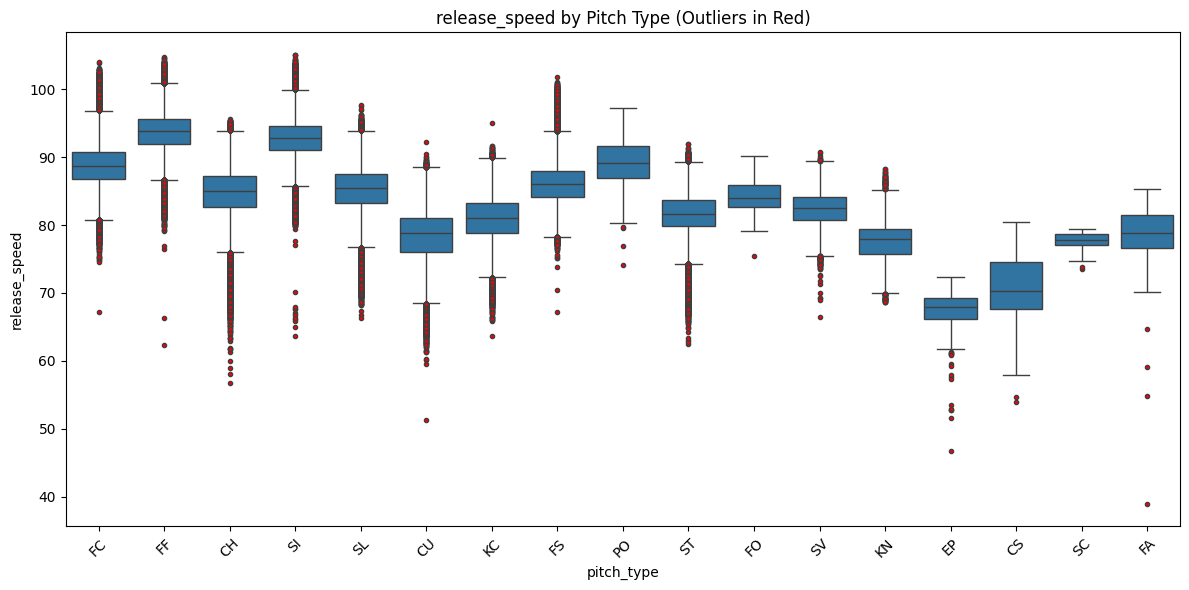

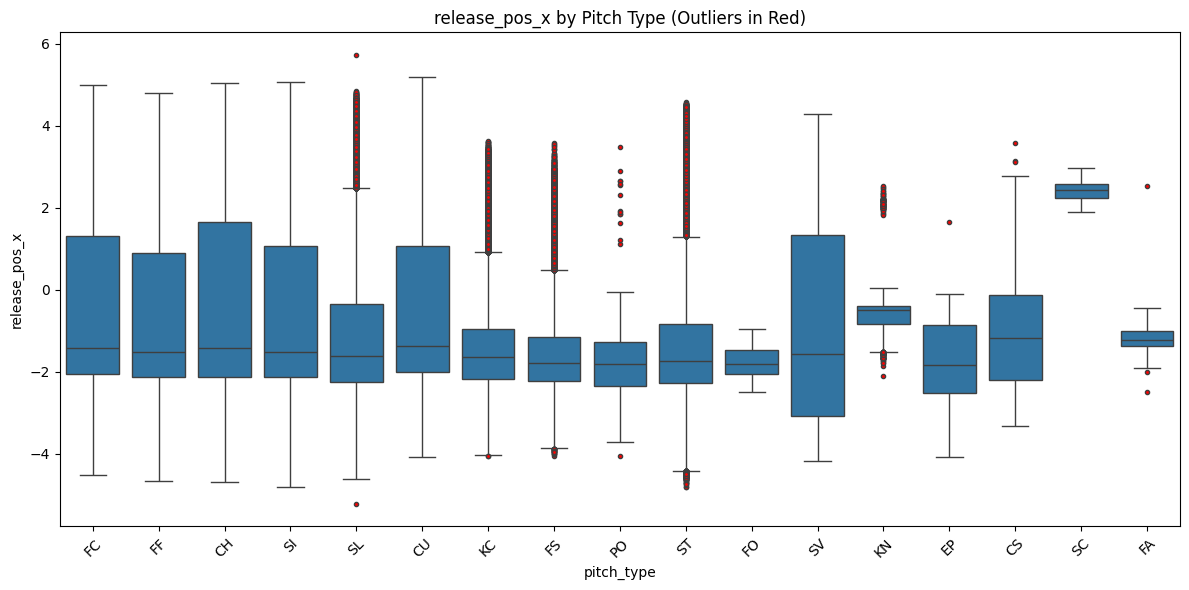

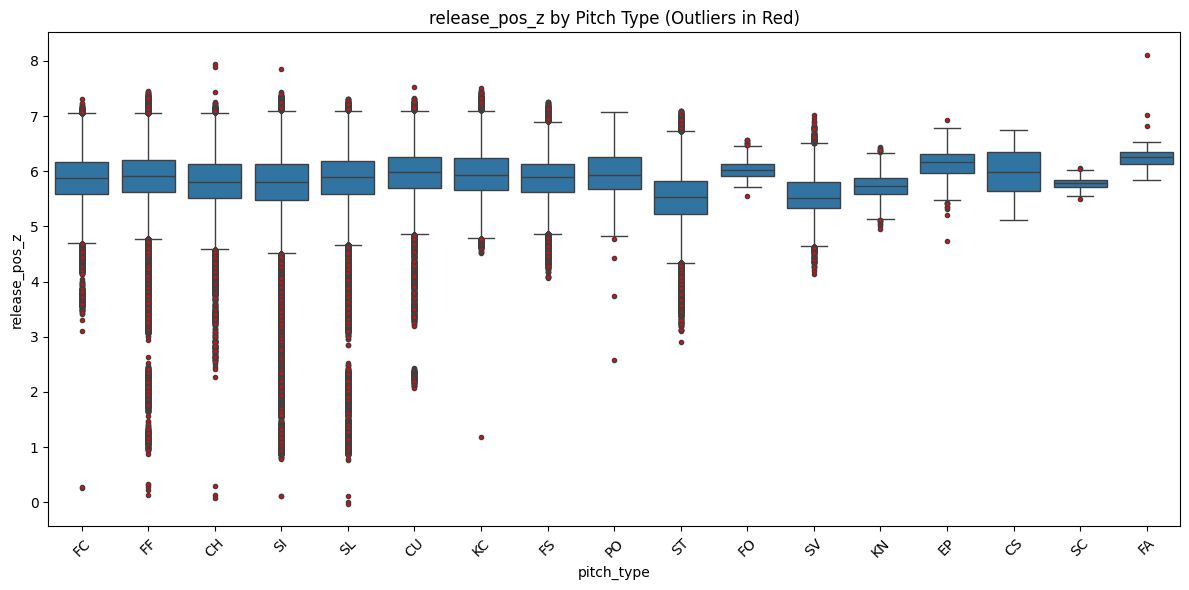

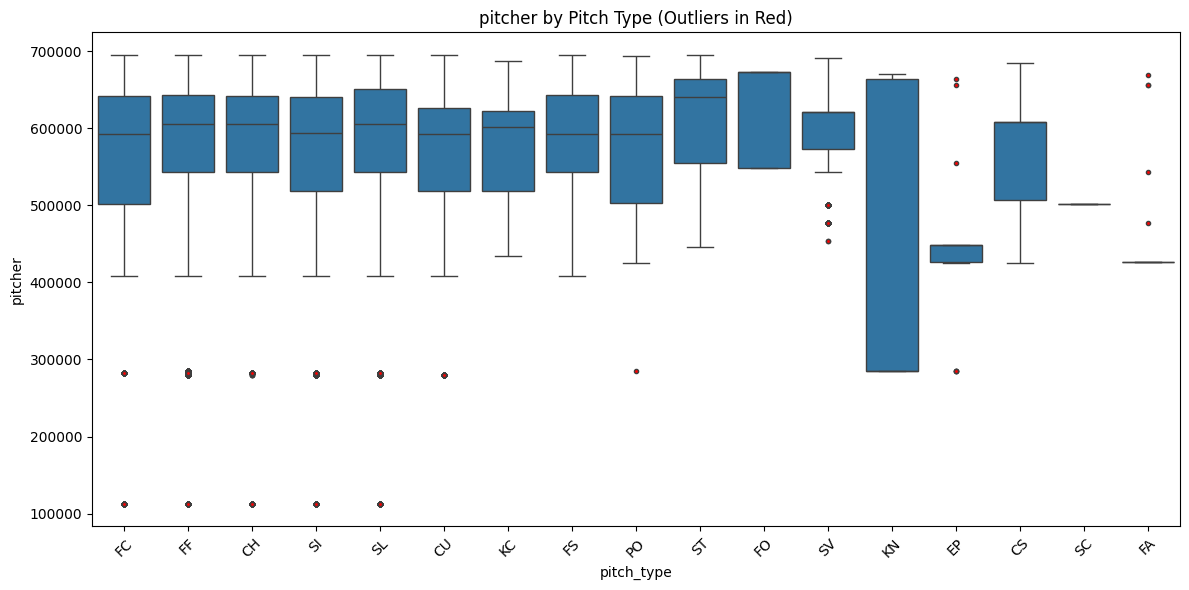

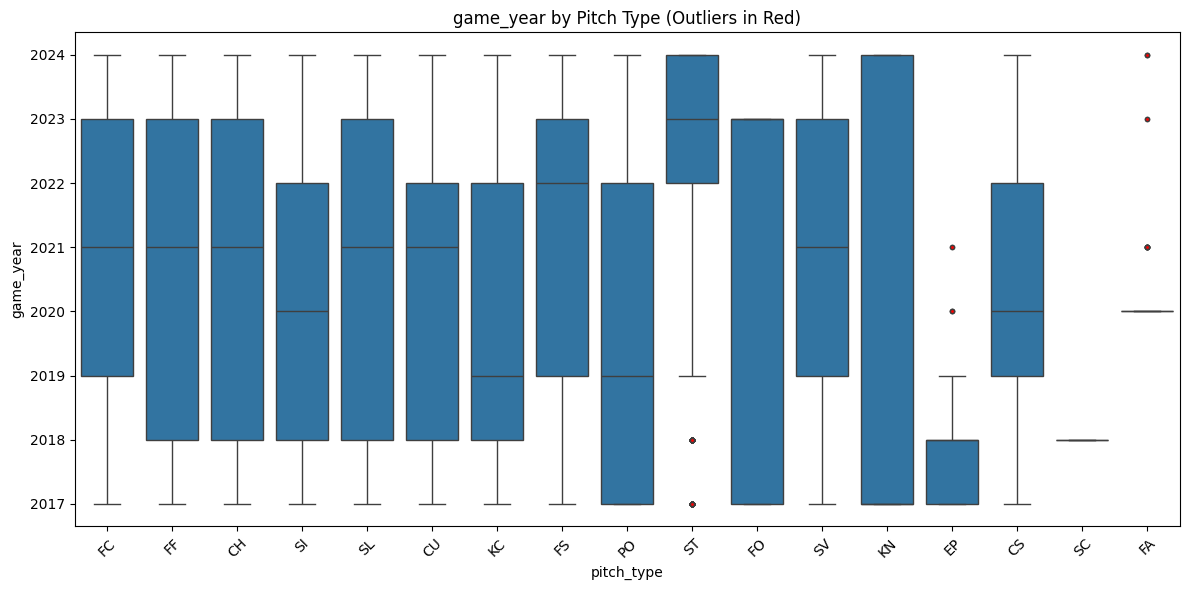

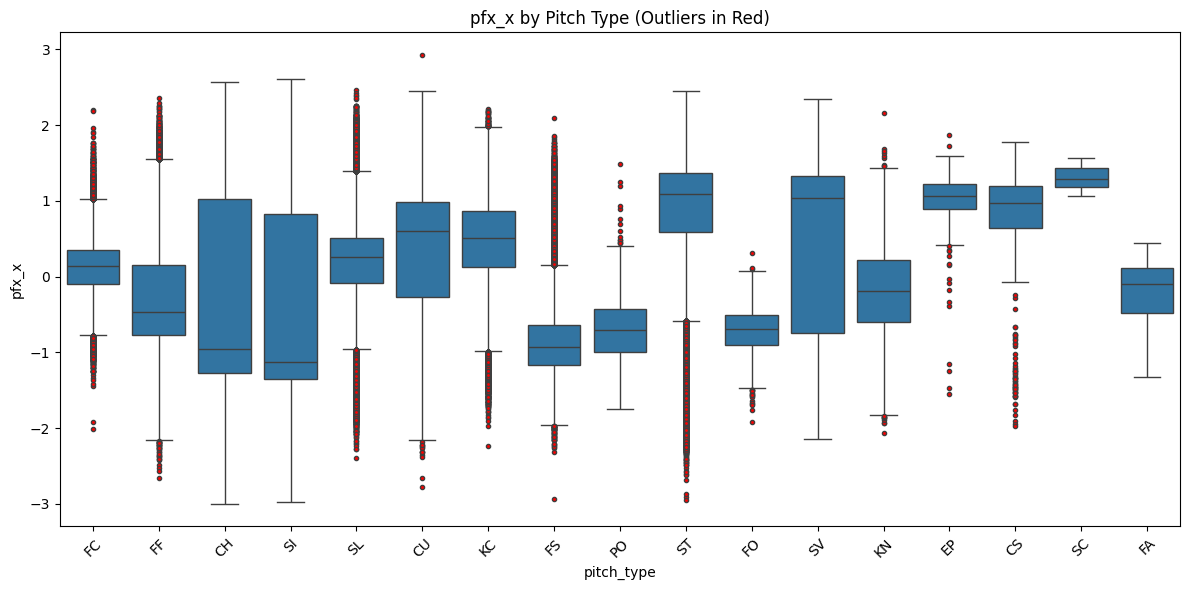

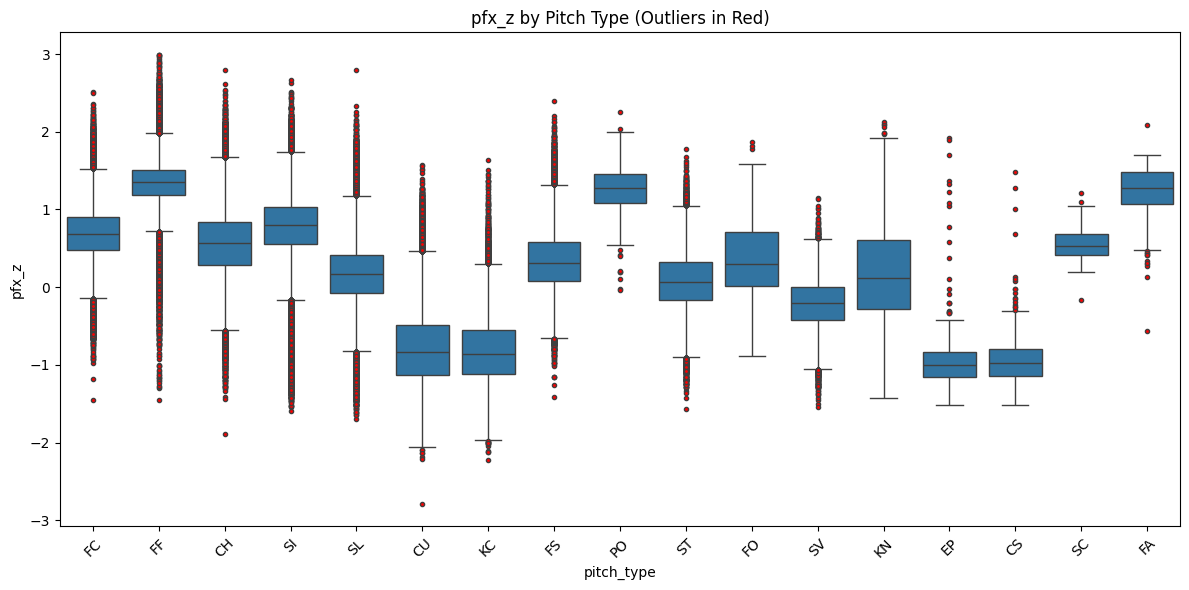

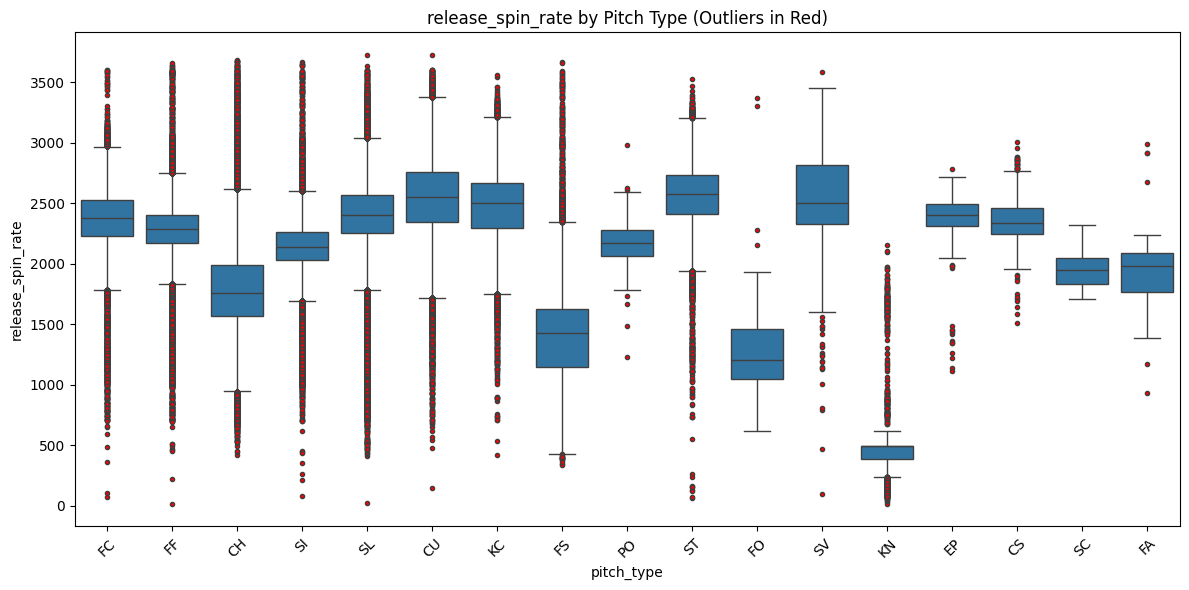

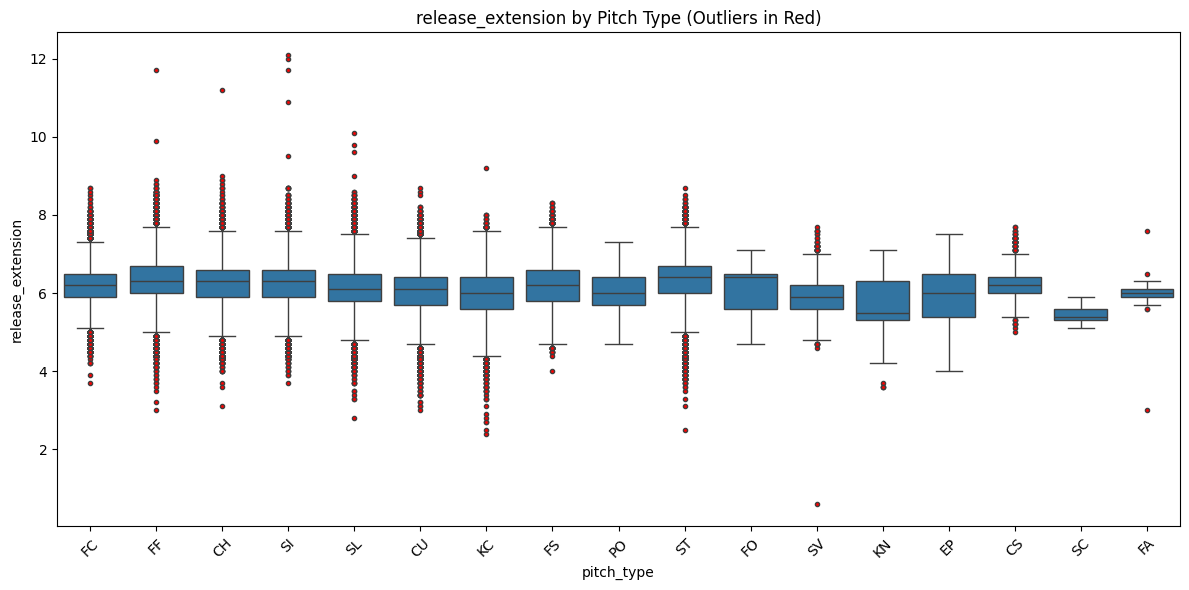

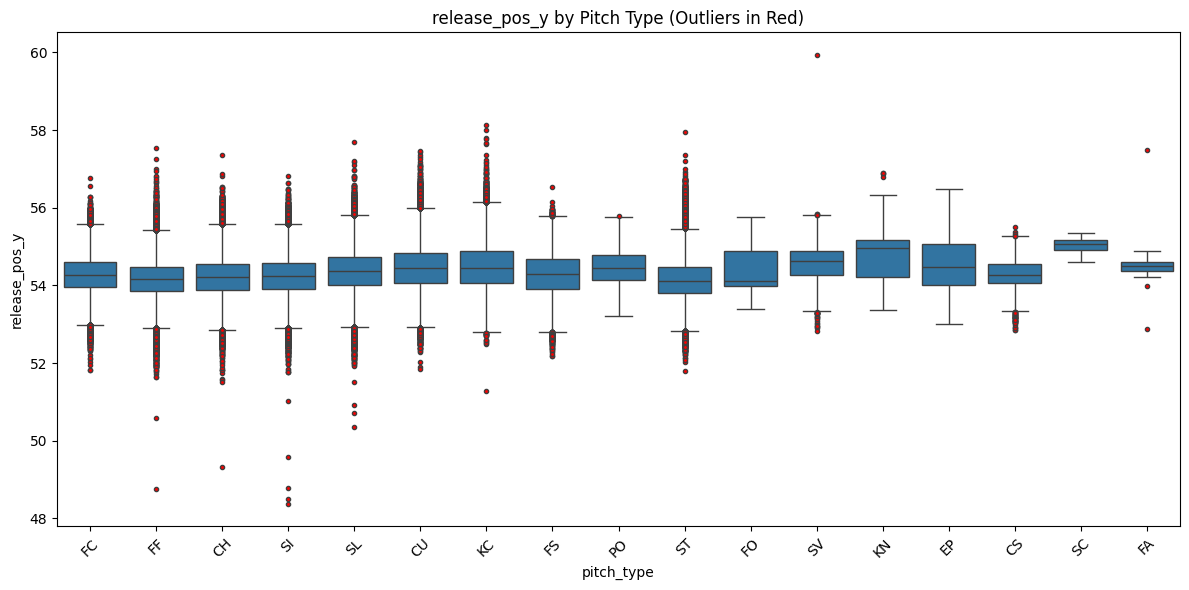

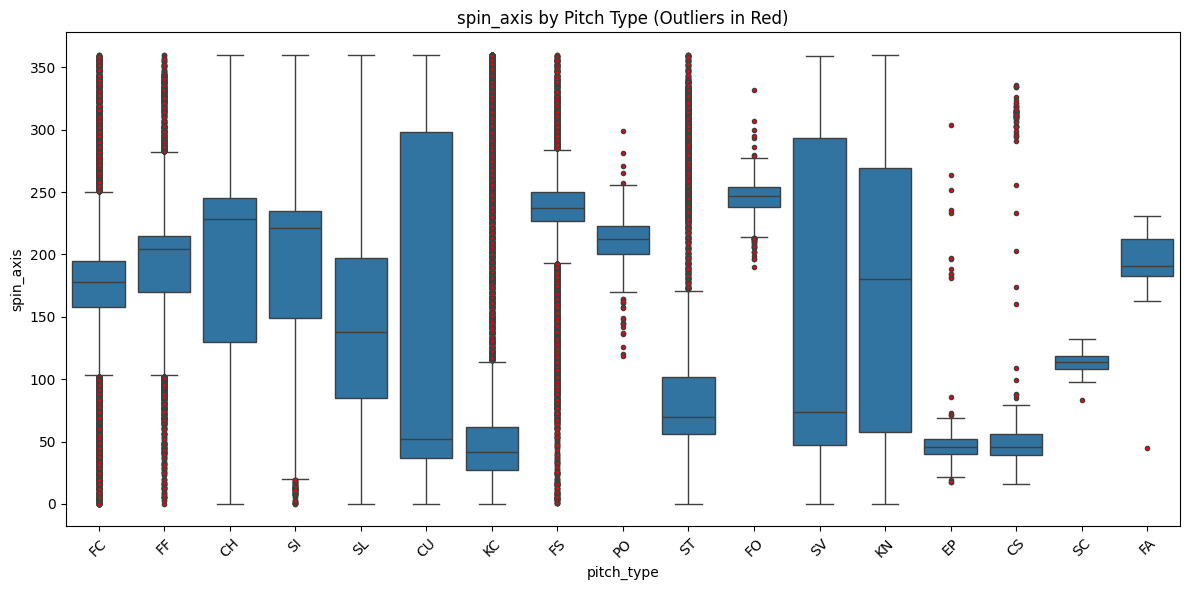

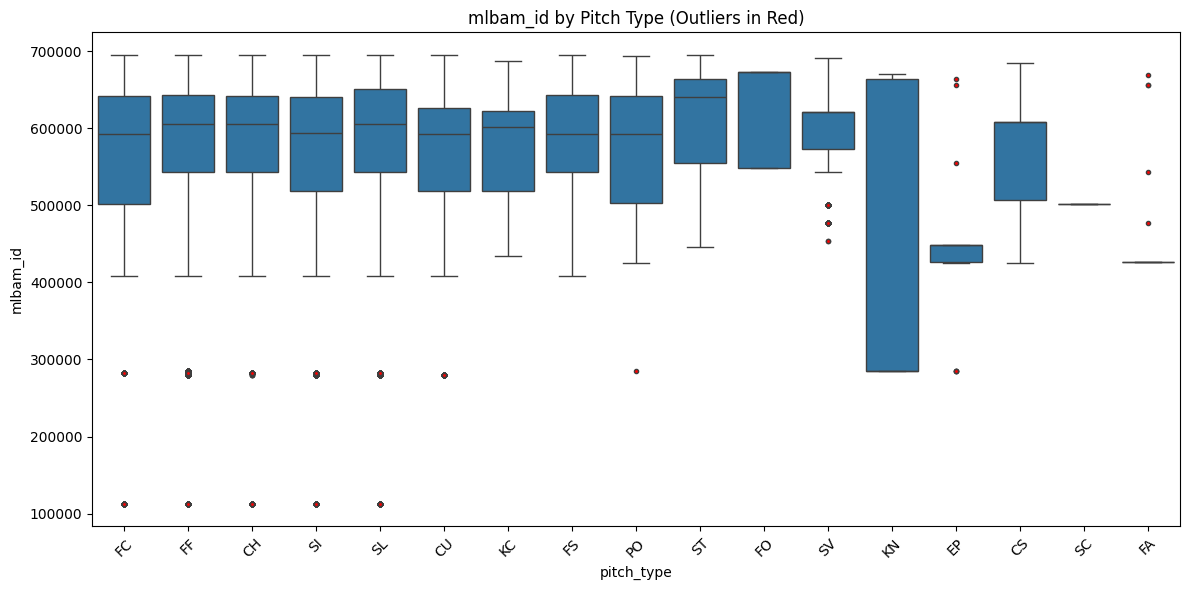

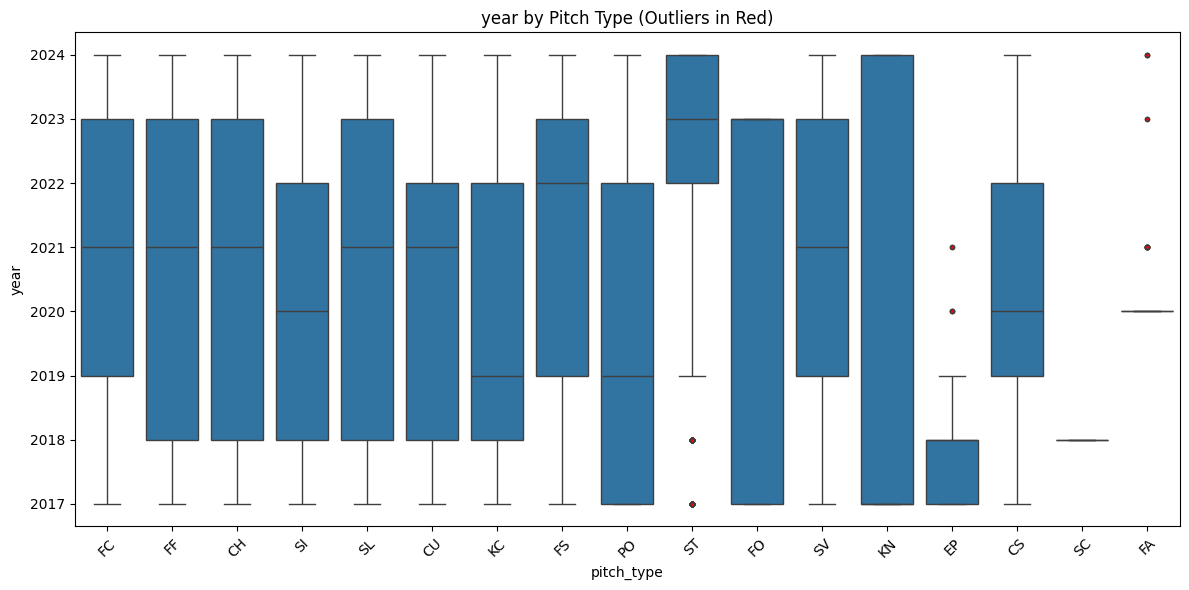

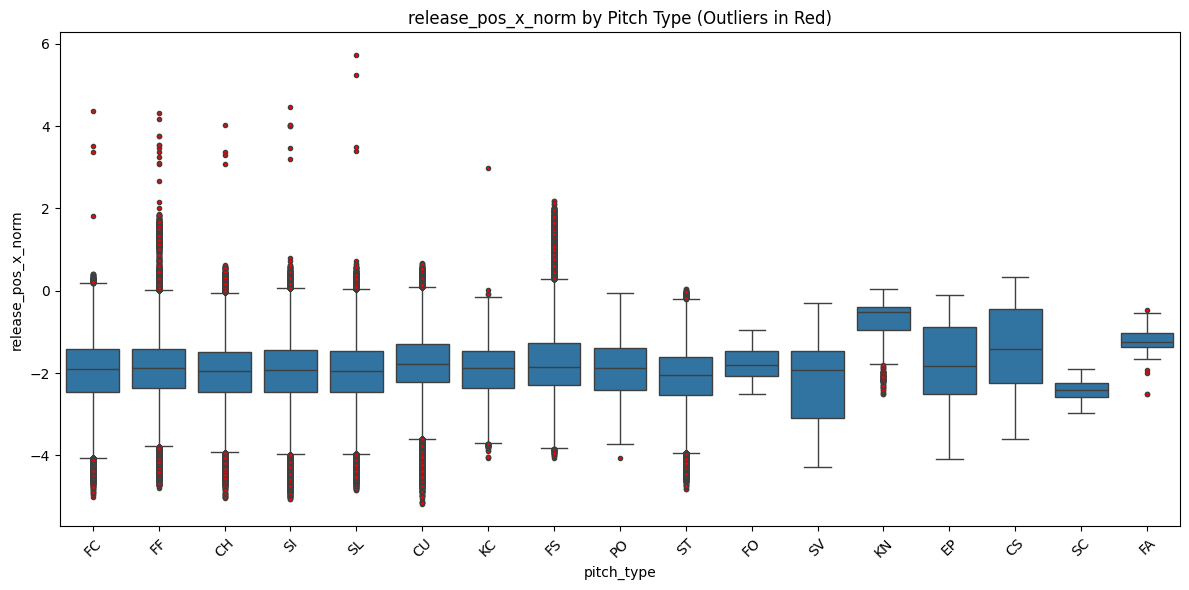

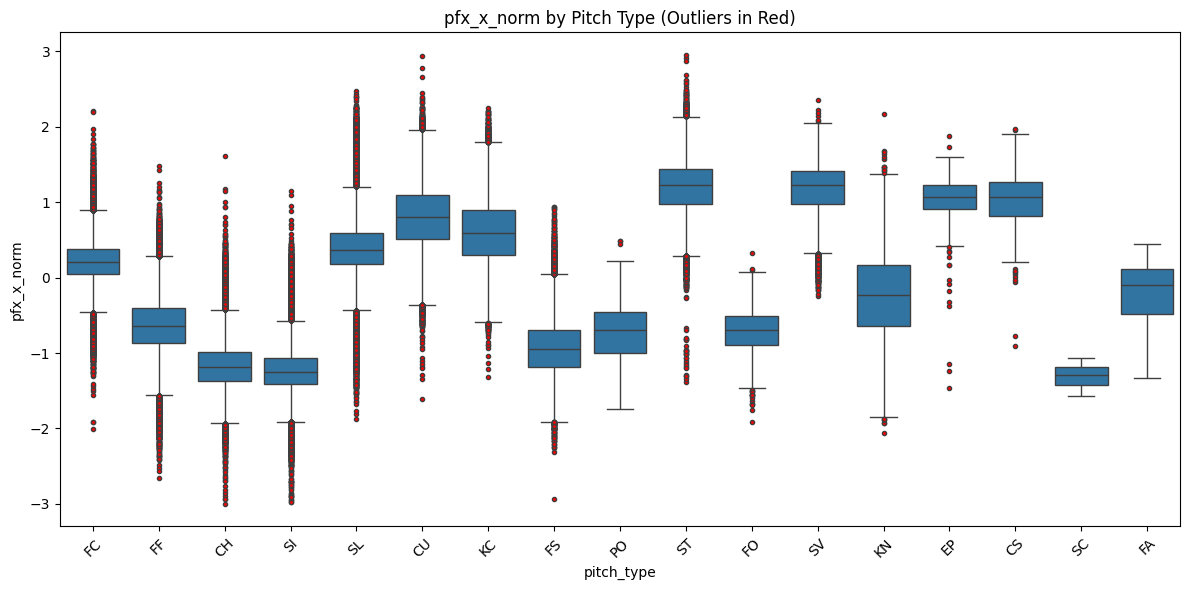

In [7]:
# Make sure we're only looking at numerical features
numerical_cols = statcast_clean_norm.select_dtypes(include='number').columns

# Loop through each numerical feature
for feature in numerical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=statcast_clean_norm,
        x='pitch_type',
        y=feature,
        showfliers=True,   # explicitly show outliers
        flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 3}
    )
    plt.title(f'{feature} by Pitch Type (Outliers in Red)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
print(statcast_clean['pitch_type'].unique())
print(statcast_clean['pitch_type'].value_counts())
# Filter for eephus pitches
eephus_df = statcast_clean[statcast_clean['pitch_type'] == 'EP']

ep_counts = eephus_df.groupby('pitcher').size().reset_index(name='eephus_count')

print(ep_counts)

# Threshold for "real" eephus pitchers
ep_pitchers_to_keep = ep_counts.loc[ep_counts['eephus_count'] >= 20, 'pitcher']

# Keep EP only for those pitchers
statcast_clean = statcast_clean[
    ~((statcast_clean['pitch_type'] == 'EP') &
      (~statcast_clean['pitcher'].isin(ep_pitchers_to_keep)))
]

['FC' 'FF' 'CH' 'SI' 'SL' 'CU' 'KC' 'FS' 'PO' 'ST' 'FO' 'SV' 'KN' 'EP'
 'CS' 'SC' 'FA']
pitch_type
FF    1132274
SI     582769
SL     498800
CH     362940
FC     253717
CU     246027
ST      96825
KC      96364
FS      68467
SV      15745
KN       3285
FO        904
CS        495
EP        355
PO        287
FA         71
SC         37
Name: count, dtype: int64
    pitcher  eephus_count
0  285079.0             4
1  425794.0             8
2  425844.0           132
3  448179.0             1
4  448306.0           207
5  554430.0             1
6  656427.0             1
7  664299.0             1


In [9]:
# Step 1: Count original pitch types
pitch_counts = statcast_clean['pitch_type'].value_counts()
print(pitch_counts)

# Step 2: Define a mapping
pitch_map = {
    # Fastballs
    'FF': 'FF',   # Four-seam
    'FA': 'FF',   # Map FA to FF
    'FC': 'FC',   # Cutter
    'SI': 'SI',   # Sinker
    'FS': 'FS',   # Splitter
    'FO': 'FS',   # Occasionally FO is logged, treat as Splitter
    'SV': 'SL',   # Slurve -> Sliders
    'ST': 'SL',   # Sweeper -> Sliders

    # Offspeed / Breaking
    'SL': 'SL',   # Slider
    'CU': 'CU',   # Curveball
    'KC': 'CU',   # Knuckle curve -> Curveball
    'CS': 'CU',   # Slow curve
    'CH': 'CH',   # Changeup
    'SC': 'CH',   # Screwball -> Changeup
    'KN': 'KN',   # Knuckleball
    'EP': 'EP',   # Eephus

    # Rare / to drop
    'PO': 'DROP',   # Pitch out, dropping
}

# Step 3: Apply mapping
statcast_clean['pitch_grouped'] = statcast_clean['pitch_type'].map(pitch_map)

# Step 4: Drop unwanted pitches
statcast_clean = statcast_clean[statcast_clean['pitch_grouped'] != 'DROP']

# Step 5: See new grouped counts
grouped_counts = statcast_clean['pitch_grouped'].value_counts()
print(grouped_counts)

pitch_type
FF    1132274
SI     582769
SL     498800
CH     362940
FC     253717
CU     246027
ST      96825
KC      96364
FS      68467
SV      15745
KN       3285
FO        904
CS        495
EP        339
PO        287
FA         71
SC         37
Name: count, dtype: int64
pitch_grouped
FF    1132345
SL     611370
SI     582769
CH     362977
CU     342886
FC     253717
FS      69371
KN       3285
EP        339
Name: count, dtype: int64


In [10]:
print(list(statcast_clean_norm.columns))
# Sort by normalized release_pos_x from largest (most positive) to smallest
suspect_releases = (
    statcast_clean_norm
    .sort_values(by='release_pos_x_norm', ascending=False)
    [['pitcher', 'p_throws', 'pitch_type', 'release_pos_x', 'release_pos_x_norm',
      'game_year']]
    .head(50)   # adjust number of rows to inspect
)

print(suspect_releases)
righties = statcast_clean_norm[statcast_clean_norm['p_throws']=='R']
print(righties['release_pos_x'].mean())
lefties = statcast_clean_norm[statcast_clean_norm['p_throws']=='L']
print(lefties['release_pos_x'].mean())

release_means = (
    statcast_clean
    .groupby(['game_year', 'p_throws'])['release_pos_x']
    .mean()
    .reset_index()
    .pivot(index='game_year', columns='p_throws', values='release_pos_x')
)

print(release_means)
kershaw = statcast_clean_norm[statcast_clean_norm['pitcher']==477132.0]
print(kershaw['release_pos_x'].mean())
kershaw['release_pos_x_sign'] = np.where(kershaw['release_pos_x'] >= 0, 'positive', 'negative')

counts = kershaw['release_pos_x_sign'].value_counts()
print(counts)


['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'p_throws', 'game_year', 'pfx_x', 'pfx_z', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis', 'mlbam_id', 'year', 'release_pos_x_norm', 'pfx_x_norm']
          pitcher p_throws pitch_type  release_pos_x  release_pos_x_norm  \
249510   570632.0        R         SL           5.73                5.73   
985956   477132.0        L         SL          -5.23                5.23   
211879   502171.0        R         SI           4.47                4.47   
214007   446372.0        R         FC           4.37                4.37   
208675   502042.0        R         FF           4.32                4.32   
214001   446372.0        R         FF           4.16                4.16   
161178   450306.0        L         SI          -4.03                4.03   
161152   450306.0        L         SI          -4.02                4.02   
161182   450306.0        L         CH          -4.02                

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/2620327685.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['game_year', 'p_throws'])['release_pos_x']
/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/2620327685.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kershaw['release_pos_x_sign'] = np.where(kershaw['release_pos_x'] >= 0, 'positive', 'negative')


In [11]:
# Group by handedness + year to normalize within context
def flag_release_outliers(df):
    df['release_pos_x_z'] = df.groupby(['p_throws','game_year'])['release_pos_x'].transform(zscore)
    return df

statcast_clean = flag_release_outliers(statcast_clean)

# Filter out extreme outliers (e.g. |z| > 4)
statcast_clean = statcast_clean[statcast_clean['release_pos_x_z'].abs() <= 4]

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/2539225547.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['release_pos_x_z'] = df.groupby(['p_throws','game_year'])['release_pos_x'].transform(zscore)


In [78]:
suspect_releases = (
    statcast_clean_norm
    .sort_values(by='release_pos_x_norm', ascending=False)
    [['pitcher', 'p_throws', 'pitch_type', 'release_pos_x', 'release_pos_x_norm',
      'game_year']]
    .head(50)   # adjust number of rows to inspect
)

print(suspect_releases)

          pitcher p_throws pitch_type  release_pos_x  release_pos_x_norm  \
249510   570632.0        R         SL           5.73                5.73   
985956   477132.0        L         SL          -5.23                5.23   
211879   502171.0        R         SI           4.47                4.47   
214007   446372.0        R         FC           4.37                4.37   
208675   502042.0        R         FF           4.32                4.32   
214001   446372.0        R         FF           4.16                4.16   
161178   450306.0        L         SI          -4.03                4.03   
161152   450306.0        L         SI          -4.02                4.02   
161182   450306.0        L         CH          -4.02                4.02   
161171   450306.0        L         SI          -4.01                4.01   
161150   450306.0        L         SI           -4.0                4.00   
4873     502028.0        R         FF           3.75                3.75   
468899   543

In [12]:
fastball_types = ['FF', 'SI', 'FC']  # adjust to your dataset if needed

# Filter out any fastball slower than 70 mph
statcast_clean = statcast_clean[~((statcast_clean['pitch_type'].isin(fastball_types)) &
                                  (statcast_clean['release_speed'] < 70))]
print(list(statcast_clean.columns))
print(statcast_clean['pitch_type'].unique())

['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'p_throws', 'game_year', 'pfx_x', 'pfx_z', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis', 'mlbam_id', 'year', 'pitch_grouped', 'release_pos_x_z']
['FC' 'FF' 'CH' 'SI' 'SL' 'CU' 'KC' 'FS' 'ST' 'FO' 'SV' 'KN' 'EP' 'CS'
 'SC' 'FA']


In [13]:
# Example pitch grouping logic
pitch_group_map = {
        'FF': 'FF',
        'FA': 'FF',
        'FC': 'FC',
        'SI': 'SI',
        'SL': 'SL',
        'SV': 'SL', # slurve
        'CU': 'CU',
        'KC': 'CU', # knuckle curve
        'CS': 'CU', # slow curve
        'CH': 'CH',
        'SC': 'CH', # screwball
        'FC': 'FC',
        'FS': 'FS',
        'FO': 'FS', # forkball
        'ST': 'SL', # sweeper
        'KN': 'KN',
        'EP': 'EP',
        'PO': 'DROP' # drop pitch outs
}

# apply mapping
statcast_clean['pitch_grouped'] = statcast_clean['pitch_type'].map(pitch_group_map)

# drop pitches
statcast_clean = statcast_clean[statcast_clean['pitch_grouped'] != 'DROP']


In [151]:
def create_pitcher_season_df(statcast_clean):
    """
    Converts pitch-level Statcast data into a pitcher-season level dataframe
    with averaged pitch metrics per pitch type, and overall release position metrics.
    """
    
    # 1️⃣ Convert handedness to numeric
    statcast_clean['p_throws_num'] = statcast_clean['p_throws'].map({'R': 1, 'L': 0})
    
    # 2️⃣ Define numeric pitch metrics
    numeric_cols = [
        'release_speed', 'release_pos_x', 'release_pos_z', 
        'pfx_x', 'pfx_z', 'release_spin_rate', 'release_extension',
        'spin_axis'
    ]
    
    # 3️⃣ Aggregate numeric metrics per pitch type
    pitch_agg = (
        statcast_clean
        .groupby(['pitcher', 'game_year', 'pitch_grouped'])[numeric_cols]
        .mean()
        .reset_index()
    )
    
    # 4️⃣ Pivot only the features you want to be pitch-specific
    pitch_specific_cols = [
        'release_speed', 'pfx_x', 'pfx_z',
        'release_spin_rate', 'spin_axis'
    ]
    
    pitcher_season_df = pitch_agg.pivot_table(
        index=['pitcher', 'game_year'],
        columns='pitch_grouped',
        values=pitch_specific_cols,
        fill_value=0
    )
    
    # Flatten MultiIndex columns
    pitcher_season_df.columns = ['_'.join(col).strip() for col in pitcher_season_df.columns.values]
    pitcher_season_df = pitcher_season_df.reset_index()

    # 5️⃣ Calculate pitch usage fractions
    pitch_counts = (
        statcast_clean
        .groupby(['pitcher', 'game_year', 'pitch_grouped'])
        .size()
        .reset_index(name='pitch_count')
    )
    
    pitch_counts['pitch_frac'] = (
        pitch_counts.groupby(['pitcher', 'game_year'])['pitch_count']
        .transform(lambda x: x / x.sum())
    )
    
    pitch_frac_pivot = pitch_counts.pivot_table(
        index=['pitcher', 'game_year'],
        columns='pitch_grouped',
        values='pitch_frac',
        fill_value=0
    )
    pitch_frac_pivot.columns = [f"{col}_frac" for col in pitch_frac_pivot.columns]
    pitch_frac_pivot = pitch_frac_pivot.reset_index()
    
    # 6️⃣ Merge pitch fractions
    pitcher_season_df = pitcher_season_df.merge(pitch_frac_pivot, on=['pitcher', 'game_year'])
    
    # 7️⃣ Add overall release position & extension averages (pitch-independent)
    release_means = (
        statcast_clean
        .groupby(['pitcher', 'game_year'])[['release_pos_x', 'release_pos_z', 'release_extension']]
        .mean()
        .reset_index()
    )
    
    pitcher_season_df = pitcher_season_df.merge(release_means, on=['pitcher', 'game_year'], how='left')
    
    return pitcher_season_df



# Usage
pitcher_season_df = create_pitcher_season_df(statcast_clean)


['pitcher', 'game_year', 'pfx_x_CH', 'pfx_x_CU', 'pfx_x_EP', 'pfx_x_FC', 'pfx_x_FF', 'pfx_x_FS', 'pfx_x_KN', 'pfx_x_SI', 'pfx_x_SL', 'pfx_z_CH', 'pfx_z_CU', 'pfx_z_EP', 'pfx_z_FC', 'pfx_z_FF', 'pfx_z_FS', 'pfx_z_KN', 'pfx_z_SI', 'pfx_z_SL', 'release_speed_CH', 'release_speed_CU', 'release_speed_EP', 'release_speed_FC', 'release_speed_FF', 'release_speed_FS', 'release_speed_KN', 'release_speed_SI', 'release_speed_SL', 'release_spin_rate_CH', 'release_spin_rate_CU', 'release_spin_rate_EP', 'release_spin_rate_FC', 'release_spin_rate_FF', 'release_spin_rate_FS', 'release_spin_rate_KN', 'release_spin_rate_SI', 'release_spin_rate_SL', 'spin_axis_CH', 'spin_axis_CU', 'spin_axis_EP', 'spin_axis_FC', 'spin_axis_FF', 'spin_axis_FS', 'spin_axis_KN', 'spin_axis_SI', 'spin_axis_SL', 'CH_frac', 'CU_frac', 'EP_frac', 'FC_frac', 'FF_frac', 'FS_frac', 'KN_frac', 'SI_frac', 'SL_frac', 'release_pos_x', 'release_pos_z', 'release_extension']


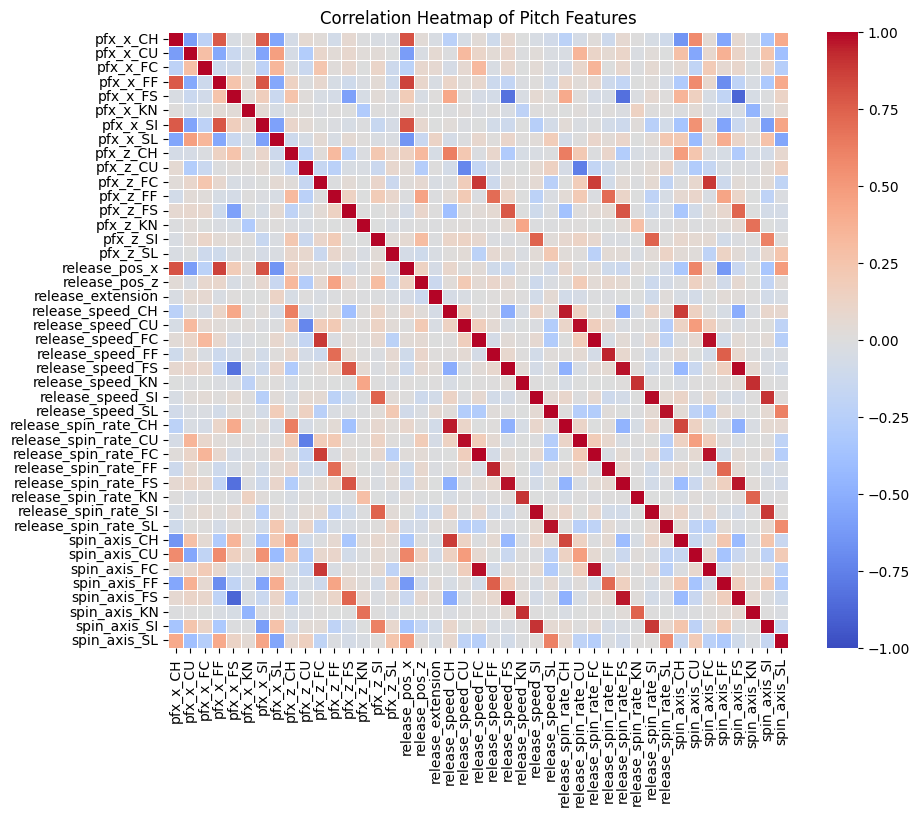

In [89]:
print(list(pitcher_season_df.columns))
#features = ['pitcher', 'game_year', 'ax_CH', 'ax_CU', 'ax_FC', 'ax_FF', 'ax_FS', 'ax_KN', 'ax_SI', 'ax_SL', 'ay_CH', 'ay_CU', 'ay_FC', 'ay_FF', 'ay_FS', 'ay_KN', 'ay_SI', 'ay_SL', 'az_CH', 'az_CU', 'az_FC', 'az_FF', 'az_FS', 'az_KN', 'az_SI', 'az_SL', 'pfx_x_CH', 'pfx_x_CU', 'pfx_x_FC', 'pfx_x_FF', 'pfx_x_FS', 'pfx_x_KN', 'pfx_x_SI', 'pfx_x_SL', 'pfx_z_CH', 'pfx_z_CU', 'pfx_z_FC', 'pfx_z_FF', 'pfx_z_FS', 'pfx_z_KN', 'pfx_z_SI', 'pfx_z_SL', 'release_extension_CH', 'release_extension_CU', 'release_extension_FC', 'release_extension_FF', 'release_extension_FS', 'release_extension_KN', 'release_extension_SI', 'release_extension_SL', 'release_pos_x_CH', 'release_pos_x_CU', 'release_pos_x_FC', 'release_pos_x_FF', 'release_pos_x_FS', 'release_pos_x_KN', 'release_pos_x_SI', 'release_pos_x_SL', 'release_pos_z_CH', 'release_pos_z_CU', 'release_pos_z_FC', 'release_pos_z_FF', 'release_pos_z_FS', 'release_pos_z_KN', 'release_pos_z_SI', 'release_pos_z_SL', 'release_speed_CH', 'release_speed_CU', 'release_speed_FC', 'release_speed_FF', 'release_speed_FS', 'release_speed_KN', 'release_speed_SI', 'release_speed_SL', 'release_spin_rate_CH', 'release_spin_rate_CU', 'release_spin_rate_FC', 'release_spin_rate_FF', 'release_spin_rate_FS', 'release_spin_rate_KN', 'release_spin_rate_SI', 'release_spin_rate_SL', 'spin_axis_CH', 'spin_axis_CU', 'spin_axis_FC', 'spin_axis_FF', 'spin_axis_FS', 'spin_axis_KN', 'spin_axis_SI', 'spin_axis_SL', 'vx0_CH', 'vx0_CU', 'vx0_FC', 'vx0_FF', 'vx0_FS', 'vx0_KN', 'vx0_SI', 'vx0_SL', 'vy0_CH', 'vy0_CU', 'vy0_FC', 'vy0_FF', 'vy0_FS', 'vy0_KN', 'vy0_SI', 'vy0_SL', 'vz0_CH', 'vz0_CU', 'vz0_FC', 'vz0_FF', 'vz0_FS', 'vz0_KN', 'vz0_SI', 'vz0_SL', 'p_throws_num', 'CH_frac', 'CU_frac', 'FC_frac', 'FF_frac', 'FS_frac', 'KN_frac', 'SI_frac', 'SL_frac']
features = ['pfx_x_CH', 'pfx_x_CU', 'pfx_x_FC', 'pfx_x_FF', 'pfx_x_FS', 'pfx_x_KN', 'pfx_x_SI', 'pfx_x_SL', 'pfx_z_CH', 'pfx_z_CU', 'pfx_z_FC', 'pfx_z_FF', 'pfx_z_FS', 'pfx_z_KN', 'pfx_z_SI', 'pfx_z_SL', 'release_pos_x', 'release_pos_z', 'release_extension', 'release_speed_CH', 'release_speed_CU', 'release_speed_FC', 'release_speed_FF', 'release_speed_FS', 'release_speed_KN', 'release_speed_SI', 'release_speed_SL', 'release_spin_rate_CH', 'release_spin_rate_CU', 'release_spin_rate_FC', 'release_spin_rate_FF', 'release_spin_rate_FS', 'release_spin_rate_KN', 'release_spin_rate_SI', 'release_spin_rate_SL', 'spin_axis_CH', 'spin_axis_CU', 'spin_axis_FC', 'spin_axis_FF', 'spin_axis_FS', 'spin_axis_KN', 'spin_axis_SI', 'spin_axis_SL']
corr = pitcher_season_df[features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap of Pitch Features")
plt.show()

In [152]:
# Define cutoff (<1%)
cutoff = 0.02

# Find all pitch fraction columns
frac_cols = [col for col in pitcher_season_df.columns if col.endswith('_frac')]

# Apply threshold: set any pitch fraction < 1% to 0
for col in frac_cols:
    pitcher_season_df.loc[pitcher_season_df[col] < cutoff, col] = 0

for pitch in ['FF', 'SL', 'CH', 'CU', 'SI', 'FC', 'FS', 'KN']:
    frac_col = f'{pitch}_frac'
    bin_col = f'throws_{pitch}'
    pitcher_season_df[bin_col] = (pitcher_season_df[frac_col] > 0).astype(int)

Empty DataFrame
Columns: [pitcher, pitch_type, frequency]
Index: []


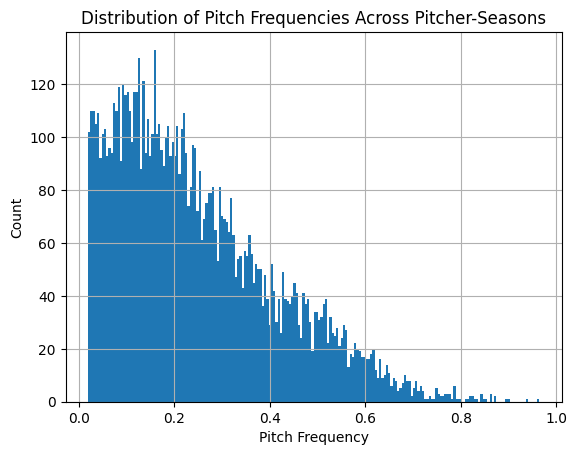

In [153]:
# Melt so you have one row per pitcher-pitch combo
pitch_freqs = pitcher_season_df.melt(
    id_vars=['pitcher'],
    value_vars=[col for col in pitcher_season_df.columns if col.endswith('_frac')],
    var_name='pitch_type',
    value_name='frequency'
)

pitch_freqs = pitch_freqs[pitch_freqs['frequency'] > 0]

# Sort to see lowest frequencies
lowest_freqs = pitch_freqs.sort_values('frequency').head(20)

low_freq_threshold = 0.02
rare_pitches = pitch_freqs[pitch_freqs['frequency'] < low_freq_threshold]
print(rare_pitches.sort_values('frequency'))

pitch_freqs['frequency'].hist(bins=200)
plt.xlabel('Pitch Frequency')
plt.ylabel('Count')
plt.title('Distribution of Pitch Frequencies Across Pitcher-Seasons')
plt.show()



In [ ]:
def compute_pitch_metric_spread(df, metric_prefix):
    """
    Compute the spread (max - min) across all pitches for a given metric.

    Parameters
    ----------
    df : pd.DataFrame
        Pitcher-season dataframe
    metric_prefix : str
        Prefix for the metric columns (e.g., 'release_speed_', 'release_spin_rate_', 'pfx_x_')

    Returns
    -------
    pd.Series
        Spread values for each pitcher-season
    """
    # Select all columns that belong to this metric
    metric_cols = [col for col in df.columns if col.startswith(metric_prefix) and "_spread" not in col]
    
    def spread_func(row):
        values = [v for v in row[metric_cols].fillna(0) if v!=0]
        if len(values) <= 1:
            return 0
        return max(values) - min(values)
    
    return df.apply(spread_func, axis=1)


In [ ]:
pitcher_season_df['velocity_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'release_speed_')
print(pitcher_season_df[['pitcher', 'game_year', 'velocity_spread']].head())
pitcher_season_df['spin_rate_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'release_spin_rate_')
print(pitcher_season_df[['pitcher', 'game_year', 'spin_rate_spread']].head())
pitcher_season_df['pfx_x_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'pfx_x_')
print(pitcher_season_df[['pitcher', 'game_year', 'pfx_x_spread']].head())
pitcher_season_df['pfx_z_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'pfx_z_')
print(pitcher_season_df[['pitcher', 'game_year', 'pfx_z_spread']].head())
print(pitcher_season_df[pitcher_season_df['pitcher']==425794][['pitcher', 'game_year', 'pfx_x_CU', 'pfx_x_FF', 'pfx_x_FC', 'pfx_x_CH', 'pfx_x_SI']])
pitcher_season_df['release_pos_x_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'release_pos_x_')
print(pitcher_season_df[['pitcher', 'game_year', 'release_pos_x_spread']].head())
print(pitcher_season_df['release_pos_x_spread'].max())
pitcher_season_df['release_pos_z_spread'] = compute_pitch_metric_spread(pitcher_season_df, 'release_pos_z_')
print(pitcher_season_df[['pitcher', 'game_year', 'release_pos_z_spread']].head())
print(pitcher_season_df['release_pos_z_spread'].max())


In [ ]:
PITCH_TYPES = ['FF', 'SL', 'CH', 'CU', 'SI', 'FC', 'FS', 'KN']

def compute_pitcher_tunneling(pitcher_row: pd.Series) -> tuple[pd.DataFrame, float]:
    """
    Compute tunneling scores for a single pitcher-season.
    
    Returns:
        pair_df (pd.DataFrame): Per-pitch-pair tunneling scores.
        overall_score (float): Weighted average tunneling score for the pitcher-season.
    """
    results = []
    
    # Determine which pitches this pitcher throws
    thrown_pitches = [p for p in PITCH_TYPES if pitcher_row.get(f"throws_{p}", 0) == 1]
    if len(thrown_pitches) < 2:
        # Can't compute tunneling with fewer than two pitch types
        return pd.DataFrame(), np.nan

    # Iterate through all unique pitch pairs
    for p1, p2 in combinations(thrown_pitches, 2):
        # Build field names for relevant features
        def feat(pitch, feat_name):
            return pitcher_row.get(f"{feat_name}_{pitch}", np.nan)

        # --- Compute release similarity ---
        release_dist = np.linalg.norm([
            feat(p1, "release_pos_x") - feat(p2, "release_pos_x"),
            feat(p1, "release_pos_z") - feat(p2, "release_pos_z"),
            feat(p1, "release_extension") - feat(p2, "release_extension")
        ])
        release_similarity = 1 / (1 + release_dist)

        # --- Compute initial trajectory similarity (velocity cosine) ---
        v1 = np.array([feat(p1, "vx0"), feat(p1, "vy0"), feat(p1, "vz0")])
        v2 = np.array([feat(p2, "vx0"), feat(p2, "vy0"), feat(p2, "vz0")])
        if np.any(np.isnan(v1)) or np.any(np.isnan(v2)):
            continue  # skip invalid data
        dir_cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

        # --- Compute movement separation ---
        move_sep = np.linalg.norm([
            feat(p1, "pfx_x") - feat(p2, "pfx_x"),
            feat(p1, "pfx_z") - feat(p2, "pfx_z")
        ])

        # --- Compute tunneling index ---
        tunneling_index = (dir_cos / (1 + release_dist)) * (1 + move_sep)

        # --- Weight based on usage fractions ---
        w1 = feat(p1, "frac")
        w2 = feat(p2, "frac")
        weight = w1 * w2 if not (np.isnan(w1) or np.isnan(w2)) else 1

        results.append({
            "pitch_pair": f"{p1}-{p2}",
            "tunneling_index": tunneling_index,
            "release_dist": release_dist,
            "dir_cos": dir_cos,
            "move_sep": move_sep,
            "weight": weight
        })
    
    pair_df = pd.DataFrame(results)
    if pair_df.empty:
        return pair_df, np.nan

    # Weighted mean tunneling score (overall for this pitcher-season)
    overall_score = np.average(pair_df["tunneling_index"], weights=pair_df["weight"])
    
    return pair_df, overall_score

In [ ]:
pair_results = []
overall_scores = []

for i, row in pitcher_season_df.iterrows():
    pair_df, tunneling_score = compute_pitcher_tunneling(row)
    pitcher_season_df.loc[i, "tunneling_score"] = tunneling_score
    
    # Optionally collect pair-level data for separate analysis
    if not pair_df.empty:
        pair_df["pitcher"] = row["pitcher"]
        pair_results.append(pair_df)

# Combine all pair-level results if desired
pair_results_df = pd.concat(pair_results, ignore_index=True)


In [ ]:
# Sort pitchers in decreasing order of tunneling_score
sorted_pitchers = pitcher_season_df.sort_values("tunneling_score", ascending=False)

# Print just pitcher and tunneling score columns
print(sorted_pitchers[["pitcher", "game_year", "tunneling_score"]].head(15))


In [ ]:
for pitch in PITCH_TYPES:
    pfx_x = f'pfx_x_{pitch}'
    pfx_z = f'pfx_z_{pitch}'
    spin_axis = f'spin_axis_{pitch}'
    throws_col = f'throws_{pitch}'  # must exist in your df (0 if not thrown)
    
    # Mask for pitches actually thrown
    mask = pitcher_season_df[throws_col] > 0
    
    # Compute movement direction and spin axis angle (only where thrown)
    move_dir = np.arctan2(pitcher_season_df.loc[mask, pfx_x], pitcher_season_df.loc[mask, pfx_z])
    spin_axis_rad = np.deg2rad(pitcher_season_df.loc[mask, spin_axis])
    
    # Angular difference and spin efficiency
    delta = np.abs(move_dir - spin_axis_rad)
    
    # Fill efficiency: 0 for unthrown pitches, calculated value for thrown
    pitcher_season_df[f'spin_efficiency_{pitch}'] = 0.0  # default 0
    pitcher_season_df.loc[mask, f'spin_efficiency_{pitch}'] = np.abs(np.cos(delta))


In [ ]:
# Sort pitchers in decreasing order of spin_efficiency_CU
sorted_pitchers = pitcher_season_df.sort_values("spin_efficiency_CU", ascending=False)

# Print just pitcher and spin_efficiency_CU columns
print(sorted_pitchers[["pitcher", "game_year", "spin_efficiency_CU"]].head(15))

In [154]:
# Get unique MLBAM IDs
mlbam_ids = pitcher_season_df["pitcher"].unique()

# Look up player info
id_lookup = playerid_reverse_lookup(mlbam_ids)

# Merge with your pitcher-season DataFrame
pitcher_season_df = pitcher_season_df.merge(
    id_lookup[['key_mlbam', 'name_first', 'name_last']],
    how='left',
    left_on='pitcher',
    right_on='key_mlbam'
)

# Optional: create a full name column
pitcher_season_df['name'] = pitcher_season_df['name_first'] + ' ' + pitcher_season_df['name_last']
pitcher_season_df = pitcher_season_df.drop('key_mlbam', axis=1)

In [93]:
print(pitcher_season_df['name'].unique())

['bartolo colón' 'matt belisle' 'cc sabathia' 'r. a. dickey' 'john lackey'
 'jorge de la rosa' 'fernando rodney' 'ryan madson' 'adam wainwright'
 'zack greinke' 'ervin santana' 'dustin mcgowan' 'matt cain' 'cole hamels'
 'santiago casilla' 'félix hernández' 'yusmeiro petit' 'justin verlander'
 'francisco liriano' 'ubaldo jiménez' 'jason hammel' 'aníbal sánchez'
 'héctor rondón' 'scott feldman' 'ricky nolasco' 'brandon kintzler'
 'kenley jansen' 'jesse chavez' 'john axford' 'corey kluber' 'brett cecil'
 'brad ziegler' 'rich hill' 'sean doolittle' 'james shields'
 'carlos torres' 'jaime garcía' 'junior guerra' 'charlie morton'
 'pat neshek' 'jason vargas' 'wade davis' 'yovani gallardo' 'josh fields'
 'jon lester' 'jared hughes' 'ian kennedy' 'andrew miller' 'tony watson'
 'daniel bard' 'wade leblanc' 'blake parker' 'max scherzer'
 'mark melancon' 'clayton richard' 'jake arrieta' 'chris martin'
 'david price' 'miguel gonzález' 'johnny cueto' 'david hernandez'
 'homer bailey' 'matt bush' '

In [155]:
id_cols = ['pitcher', 'game_year', 'name', 'name_first', 'name_last']
exclude_cols = [c for c in pitcher_season_df.columns if c.endswith('_frac') or c.startswith('spin_axis') or c.startswith('release_spin')]
feature_cols = [c for c in pitcher_season_df.columns if c not in id_cols + exclude_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitcher_season_df[feature_cols])

# Turn back into a DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=pitcher_season_df.index)


In [108]:
print(X_scaled_df)

      pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  \
0    -0.850485 -0.420864 -0.051383 -0.396463 -0.654237  0.314835   0.01265   
1    -0.807431 -0.420864 -0.051383 -0.536410 -0.607696  0.314835   0.01265   
2    -0.541605  1.380107 -0.051383 -0.255446 -0.444907  0.314835   0.01265   
3     1.263523 -0.420864 -0.051383  0.078967  1.257937  0.314835   0.01265   
4     1.193264 -0.420864 -0.051383 -0.847029  1.461921  0.314835   0.01265   
...        ...       ...       ...       ...       ...       ...       ...   
2106 -0.580883 -0.420864 -0.051383 -0.255446 -0.031749  0.314835   0.01265   
2107 -0.956791  1.389208 -0.051383 -0.255446 -0.264549 -0.764110   0.01265   
2108  1.518966 -0.420864 -0.051383 -0.255446  1.873665  0.314835   0.01265   
2109 -0.813300 -0.046050 -0.051383 -0.998588 -0.663532  0.314835   0.01265   
2110 -0.767411 -0.420864 -0.051383 -0.255446 -0.805093 -3.993110   0.01265   

      pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  pfx_z_F

In [ ]:
similarity_matrix = cosine_similarity(X_scaled_df)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1),
    columns=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1)
)

similarity_df.index = pd.MultiIndex.from_tuples(similarity_df.index, names=['pitcher', 'game_year'])
similarity_df.columns = pd.MultiIndex.from_tuples(similarity_df.columns, names=['pitcher', 'game_year'])


In [96]:
print(pitcher_season_df[pitcher_season_df['pitcher']==543037])

      pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  \
532  543037.0       2017 -1.374657  0.977934       0.0       0.0  -1.11941   
533  543037.0       2018 -1.208483  1.036582       0.0       0.0 -0.927383   
534  543037.0       2019 -1.275823  0.974035       0.0       0.0 -0.949158   
535  543037.0       2020 -1.290448  0.792293       0.0       0.0 -1.016345   
536  543037.0       2021 -1.318024  0.871398       0.0       0.0  -0.99932   
537  543037.0       2022 -1.165745  0.851643       0.0  0.039327 -0.865398   
538  543037.0       2023  -1.18588  0.839318       0.0  0.231818  -0.69765   

     pfx_x_FS  pfx_x_KN  pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  \
532       0.0       0.0 -1.485967   0.21261  0.730955 -0.557657       0.0   
533       0.0       0.0 -1.298934  0.426282  0.928966 -0.938275       0.0   
534       0.0       0.0 -1.255125  0.405913  0.993534 -1.170386       0.0   
535       0.0       0.0 -1.356667  0.420541  0.882687 -0.941902    

In [156]:
# Make a dictionary that maps pitcher ID -> full name
id_to_name = (
    pitcher_season_df
    .drop_duplicates(subset='pitcher')
    .set_index('pitcher')['name']
    .to_dict()
)

def similar_pitchers(target_id, target_year):
    target = (target_id, target_year)
    top_similar = (
        similarity_df.loc[target]
        .drop(target)
        .sort_values(ascending=False)
        .head(10)
    )

    # Reset index to turn MultiIndex (pitcher, year) into columns
    top_similar_named = top_similar.reset_index()

    # Rename the similarity column for clarity
    top_similar_named.columns = ['pitcher', 'game_year', 'cosine_similarity']

    # Map IDs to names
    id_to_name = (
        pitcher_season_df
        .drop_duplicates(subset='pitcher')
        .set_index('pitcher')['name']
        .to_dict()
    )

    top_similar_named['pitcher_name'] = top_similar_named['pitcher'].map(id_to_name)

    # Reorder for readability
    top_similar_named = top_similar_named[['pitcher_name', 'game_year', 'cosine_similarity']]
    top_similar_named.columns = ['Pitcher', 'Season', 'Cosine Similarity']

    return top_similar_named



In [163]:
# Map (name_clean, game_year) -> pitcher_id
name_year_to_id = (
    pitcher_season_df
    .drop_duplicates(subset=['name', 'game_year'])
    .set_index(['name', 'game_year'])['pitcher']
    .to_dict()
)

def similar_pitchers_by_name(name, year):
    key = (name.strip().lower(), year)
    if key not in name_year_to_id:
        # You can also return None or an empty DataFrame instead of raising
        raise ValueError(f"No pitcher-season found for {name} in {year}")
    
    pitcher_id = name_year_to_id[key]
    return similar_pitchers(pitcher_id, year)


In [21]:
cole_2021 = similar_pitchers(543037, 2021)
print(cole_2021)

chapman_2018 = similar_pitchers(547973, 2023)
print(chapman_2018)

              Pitcher  Season  Cosine Similarity
0         gerrit cole  2020.0           0.973801
1         matt magill  2018.0           0.915496
2        shane bieber  2019.0           0.905863
3         jared jones  2024.0           0.905124
4  vladimir gutiérrez  2021.0           0.899150
5            jon gray  2023.0           0.887963
6      chris stratton  2021.0           0.873542
7       lucas giolito  2022.0           0.856180
8          trevor may  2019.0           0.851686
9        jordan lyles  2019.0           0.846407
           Pitcher  Season  Cosine Similarity
0  aroldis chapman  2024.0           0.994008
1  aroldis chapman  2021.0           0.925207
2        a. j. puk  2024.0           0.793245
3      pedro strop  2017.0           0.757599
4      yuki matsui  2024.0           0.718774
5   yonny chirinos  2018.0           0.718106
6     zack littell  2024.0           0.699725
7   félix bautista  2022.0           0.687284
8    kyle finnegan  2023.0           0.685817
9

In [ ]:
# Select and reshape spin efficiency columns
spin_eff_cols = [f'spin_efficiency_{p}' for p in PITCH_TYPES]

# Melt into long format
spin_eff_long = (
    pitcher_season_df[spin_eff_cols]
    .melt(value_vars=spin_eff_cols, var_name='pitch_type', value_name='spin_efficiency')
)

# Clean up pitch_type labels (remove prefix)
spin_eff_long['pitch_type'] = spin_eff_long['pitch_type'].str.replace('spin_efficiency_', '', regex=False)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=spin_eff_long,
    x='pitch_type',
    y='spin_efficiency',
    order=PITCH_TYPES,
    palette='coolwarm',
    linewidth=1.2
)

plt.title('Spin Efficiency Distribution by Pitch Type (Across Pitcher-Seasons)', fontsize=14, weight='bold')
plt.xlabel('Pitch Type', fontsize=12)
plt.ylabel('Spin Efficiency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [99]:
dickey = df[df['pitcher']==285079]
print((dickey['pitch_type']=='KN').sum())

2329


In [46]:
dickey_seasons = pitcher_season_df[pitcher_season_df['pitcher']==285079]
print(dickey_seasons)

    pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  \
5  285079.0       2017       0.0       0.0       0.0       0.0 -1.309835   

   pfx_x_FS  pfx_x_KN  pfx_x_SI  ...  throws_SL  throws_CH  throws_CU  \
5       0.0 -0.134238       0.0  ...          0          0          0   

   throws_SI  throws_FC  throws_FS  throws_KN  name_first  name_last  \
5          0          0          0          1       r. a.     dickey   

           name  
5  r. a. dickey  

[1 rows x 94 columns]


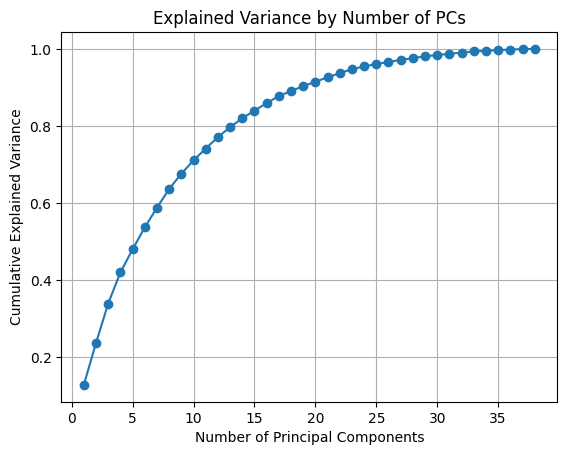

Number of components to explain 90% variance: 19


In [157]:
# Fit PCA
pca = PCA()
pca.fit(X_scaled_df)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCs')
plt.grid(True)
plt.show()

target_variance = 0.90  # e.g. keep 90% of total variance

n_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components to explain {target_variance*100:.0f}% variance: {n_components}")

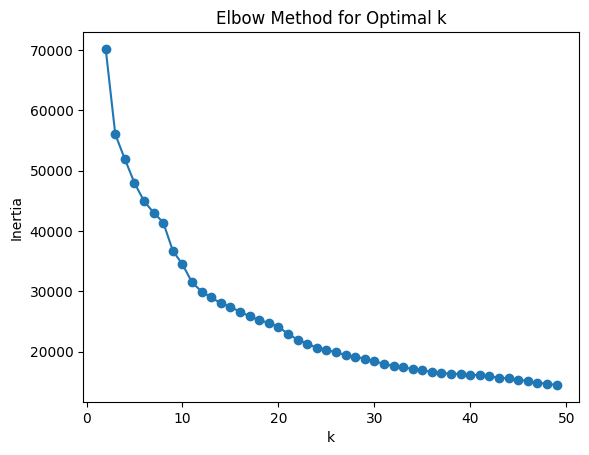

In [158]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

inertias = []
K = range(2, 50)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # after PCA
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

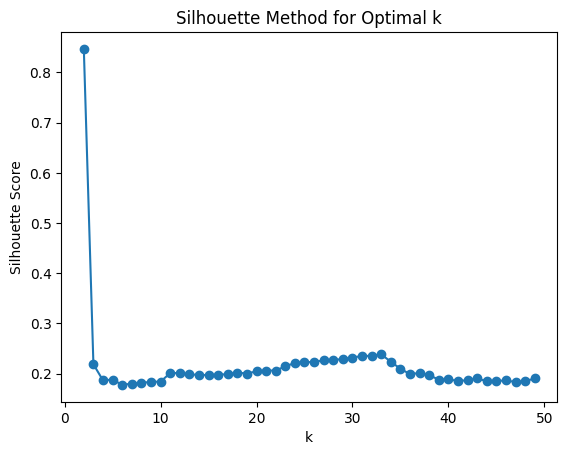

In [159]:
sil_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil_scores.append(silhouette_score(X_pca, labels))

plt.plot(K, sil_scores, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [160]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_pca)
pitcher_clusters = pitcher_season_df.copy()
pitcher_clusters["cluster"] = labels
pitcher_clusters.groupby("cluster")["name"].apply(list)

cluster
0     [cc sabathia, cc sabathia, cole hamels, rich h...
1     [josh fields, jared hughes, david hernandez, t...
2     [justin wilson, jake mcgee, anthony swarzak, d...
3     [ricky nolasco, junior guerra, junior guerra, ...
4     [francisco liriano, francisco liriano, francis...
5     [brad ziegler, joe smith, darren o'day, steve ...
6     [john lackey, adam wainwright, adam wainwright...
7                                        [matt waldron]
8     [zack greinke, zack greinke, zack greinke, jam...
9                                      [adrián morejón]
10    [kenley jansen, kenley jansen, kenley jansen, ...
11           [r. a. dickey, george kirby, george kirby]
12    [ubaldo jiménez, aníbal sánchez, aníbal sánche...
13    [fernando rodney, fernando rodney, ervin santa...
14    [clayton kershaw, clayton kershaw, clayton ker...
15    [ervin santana, justin verlander, justin verla...
16    [matt belisle, ryan madson, zack greinke, matt...
17    [jorge de la rosa, cole hamels, co

In [161]:
similarity_matrix = cosine_similarity(X_pca)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1),
    columns=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1)
)

similarity_df.index = pd.MultiIndex.from_tuples(similarity_df.index, names=['pitcher', 'game_year'])
similarity_df.columns = pd.MultiIndex.from_tuples(similarity_df.columns, names=['pitcher', 'game_year'])

In [164]:
similar_pitchers_by_name('gerrit cole', 2021)

Pitcher  Season  Cosine Similarity
0         matt magill  2018.0           0.976487
1         gerrit cole  2020.0           0.973230
2      chris stratton  2021.0           0.953455
3  vladimir gutiérrez  2021.0           0.948689
4         justin dunn  2020.0           0.939348
5        shane bieber  2019.0           0.938672
6         jared jones  2024.0           0.926982
7     cristian javier  2022.0           0.924267
8            jon gray  2023.0           0.923033
9        jordan lyles  2019.0           0.905869

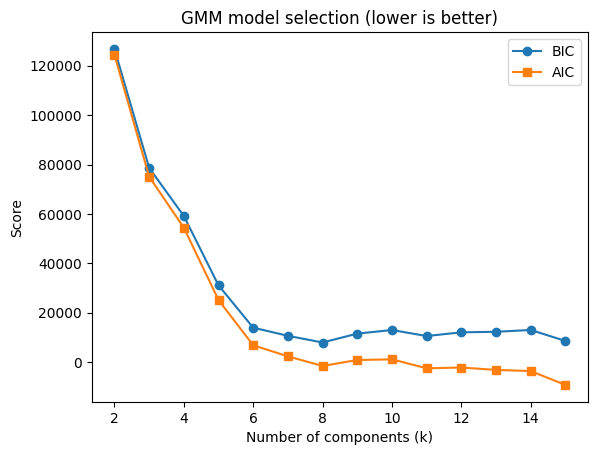

Best k by BIC: 8


In [165]:
# X_pca is your PCA-transformed data (same row order as pitcher_season_df)
n_components_range = range(2, 16)  # try 2–15 clusters
bics = []
aics = []

for k in n_components_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42
    )
    gmm.fit(X_pca)
    bics.append(gmm.bic(X_pca))
    aics.append(gmm.aic(X_pca))

# Plot BIC/AIC vs k
plt.figure()
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='s', label='AIC')
plt.xlabel("Number of components (k)")
plt.ylabel("Score")
plt.title("GMM model selection (lower is better)")
plt.legend()
plt.show()

# Choose best_k by minimum BIC (you could also use AIC)
best_k = n_components_range[int(np.argmin(bics))]
print("Best k by BIC:", best_k)

In [166]:
gmm = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    n_init=5,          # multiple initializations for stability
    random_state=42
).fit(X_pca)

cluster_labels = gmm.predict(X_pca)        # hard cluster assignments
cluster_probs = gmm.predict_proba(X_pca)   # soft memberships (optional)

In [171]:
# Make sure this is run AFTER you compute cluster_labels = gmm.predict(X_pca)
pitcher_season_df = pitcher_season_df.copy()
pitcher_season_df['gmm_cluster'] = cluster_labels

In [172]:
if len(np.unique(cluster_labels)) > 1:
    sil = silhouette_score(X_pca, cluster_labels)
    print("Silhouette score (GMM on PCA):", sil)
else:
    print("Only one cluster found; silhouette score not defined.")

Silhouette score (GMM on PCA): 0.1125091098381138


In [173]:
summary_features = [
    c for c in feature_cols
    if c.startswith('release_speed') or c.endswith('_frac')
]

cluster_summary = (
    pitcher_season_df
    .groupby('gmm_cluster')[summary_features]
    .mean()
)

display(cluster_summary)


release_speed_CH  release_speed_CU  release_speed_EP  \
gmm_cluster                                                         
0                   74.309494          54.32127               0.0   
1                   78.209549         79.750931               0.0   
2                   69.712044         53.809906               0.0   
3                   51.570225         62.045868               0.0   
4                    73.00631         45.472988               0.0   
5                   66.731209               0.0               0.0   
6                   78.226418         76.934532         16.257435   
7                   34.398823         49.412331               0.0   

             release_speed_FC  release_speed_FF  release_speed_FS  \
gmm_cluster                                                         
0                   87.402908         86.711235               0.0   
1                         0.0         93.820686               0.0   
2                   20.725925         94.004265               0.0   
3                   63.650299         93.608452         39.560215   
4                         0.0         85.250984               0.0   
5                   23.927862         88.610497               0.0   
6                   62.962067         29.645473          2.966137   
7                    35.86721         92.668129          34.17276   

             release_speed_KN  release_speed_SI  release_speed_SL  
gmm_cluster                                                        
0                         0.0         80.184906         49.242321  
1                         0.0         93.383888         75.663666  
2                         0.0               0.0         70.636696  
3                         0.0         78.538712          61.41473  
4                         0.0         92.474701         75.444855  
5                         0.0         94.111397         84.489006  
6                         0.0         87.037125         64.494133  
7                   78.016907         75.840729         67.705635

In [174]:
print(pitcher_season_df)

       pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  \
0     112526.0       2017 -1.189099       0.0       0.0 -0.024286 -0.709889   
1     112526.0       2018 -1.148105       0.0       0.0 -0.048387 -0.680685   
2     279571.0       2017    -0.895  1.064486       0.0       0.0 -0.578535   
3     282332.0       2017  0.823747       0.0       0.0  0.057592      0.49   
4     282332.0       2018   0.75685       0.0       0.0 -0.101881     0.618   
...        ...        ...       ...       ...       ...       ...       ...   
2106  693821.0       2023 -0.932398       0.0       0.0       0.0 -0.319278   
2107  694297.0       2024 -1.290318  1.069865       0.0       0.0  -0.46536   
2108  694363.0       2024  1.066966       0.0       0.0       0.0  0.876369   
2109  694813.0       2024 -1.153693  0.221538       0.0 -0.127982 -0.715722   
2110  695243.0       2024     -1.11       0.0       0.0       0.0 -0.804551   

      pfx_x_FS  pfx_x_KN  pfx_x_SI  pfx_x_SL  pfx_z

In [107]:
pitcher_clusters.groupby("cluster").size()
print(pitcher_clusters[pitcher_clusters['cluster']==8])

     pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  \
16  425844.0       2017 -1.091285  0.984704  1.094286       0.0 -0.178557   
17  425844.0       2018 -1.001037  0.993696   1.03038       0.0 -0.105763   
18  425844.0       2019 -1.040647  1.036316  1.022143      0.45 -0.165063   
85  448306.0       2017 -1.335571  0.415443  0.927742  0.230495 -0.697429   
86  448306.0       2018 -1.204991  0.522625  1.202456  0.374516 -0.663941   

    pfx_x_FS  pfx_x_KN  pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  \
16       0.0       0.0 -1.009648  0.504453  0.520514 -0.956626 -0.864762   
17       0.0       0.0 -0.992337  0.591654  0.331021 -0.969026 -1.007848   
18 -0.778571       0.0 -1.108537  0.588146  0.319706 -0.940746 -0.784643   
85       0.0       0.0 -1.064054       0.0  0.550959 -0.386127 -0.894409   
86       0.0       0.0 -1.154617       0.0   0.52389 -0.414155 -1.101579   

    pfx_z_FC  pfx_z_FF  pfx_z_FS  pfx_z_KN  pfx_z_SI  pfx_z_SL  \
16       0.0  

For n_clusters = 2, average silhouette score = 0.847


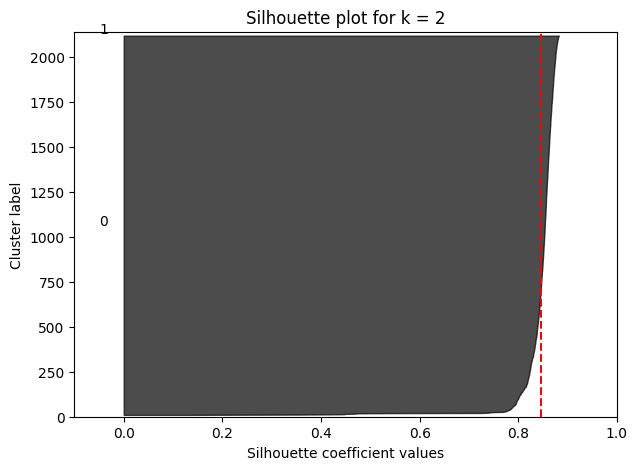

For n_clusters = 4, average silhouette score = 0.186


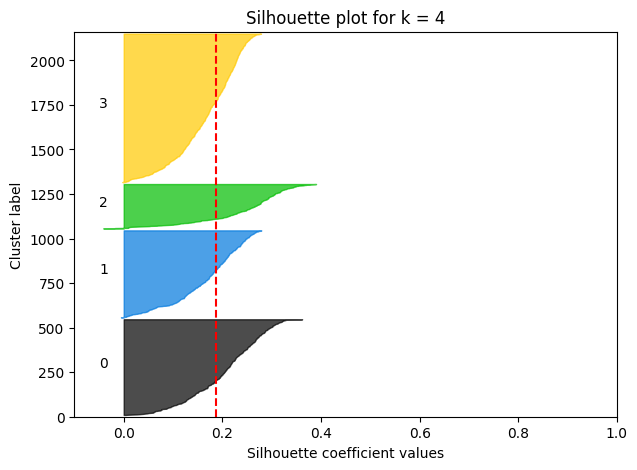

For n_clusters = 6, average silhouette score = 0.177


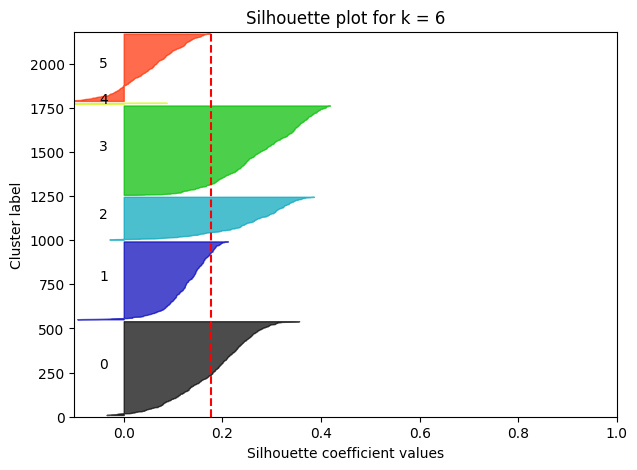

For n_clusters = 8, average silhouette score = 0.181


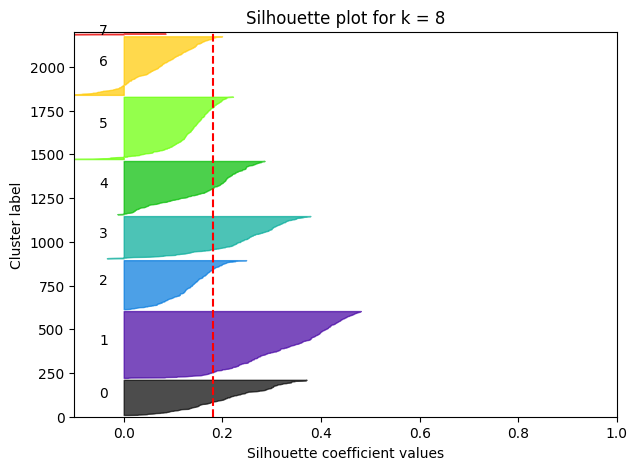

For n_clusters = 10, average silhouette score = 0.184


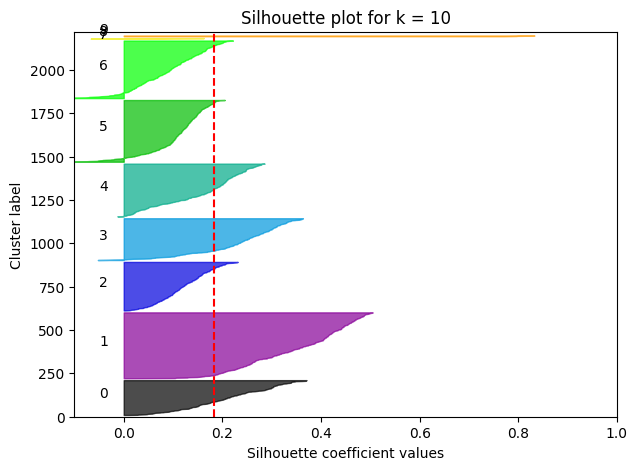

For n_clusters = 12, average silhouette score = 0.201


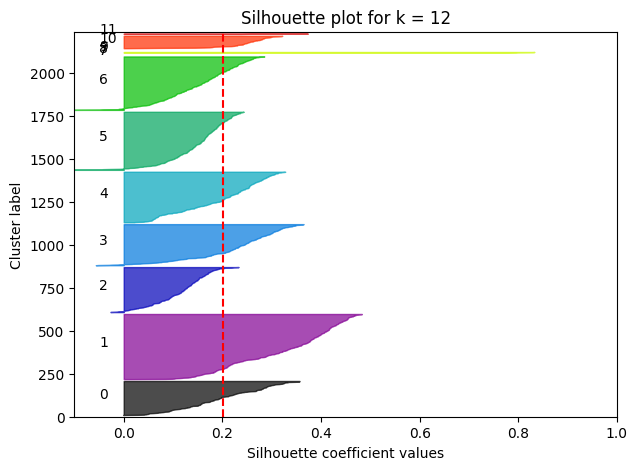

For n_clusters = 14, average silhouette score = 0.197


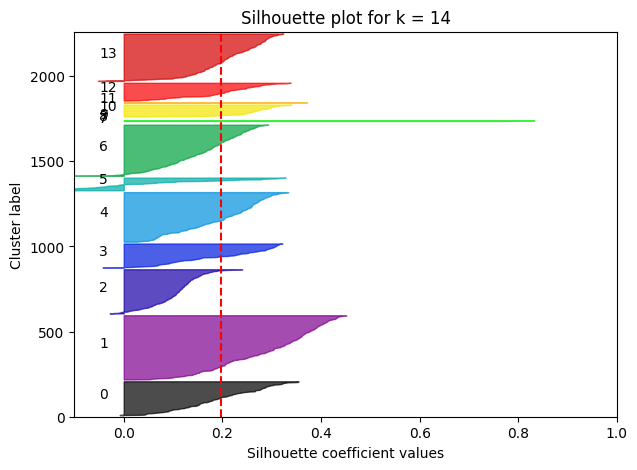

For n_clusters = 16, average silhouette score = 0.197


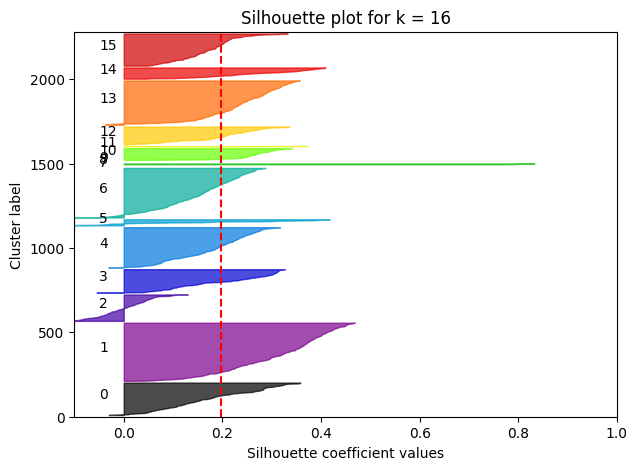

For n_clusters = 18, average silhouette score = 0.202


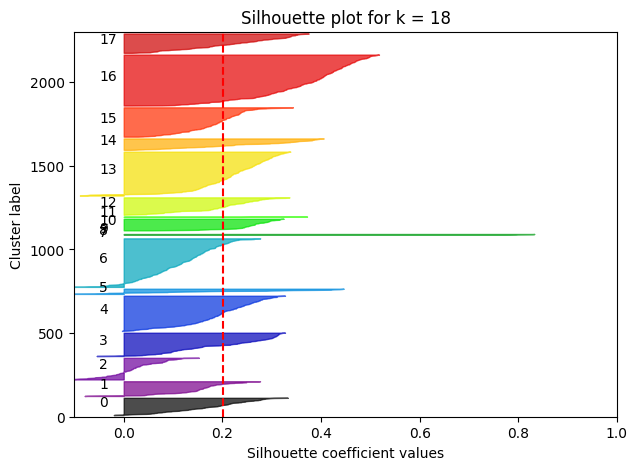

For n_clusters = 20, average silhouette score = 0.204


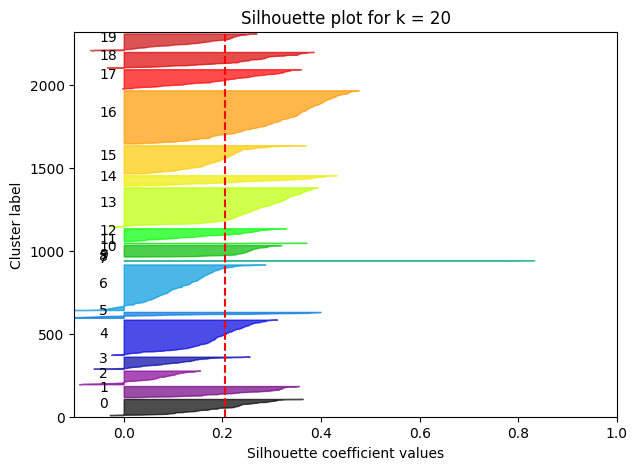

For n_clusters = 22, average silhouette score = 0.206


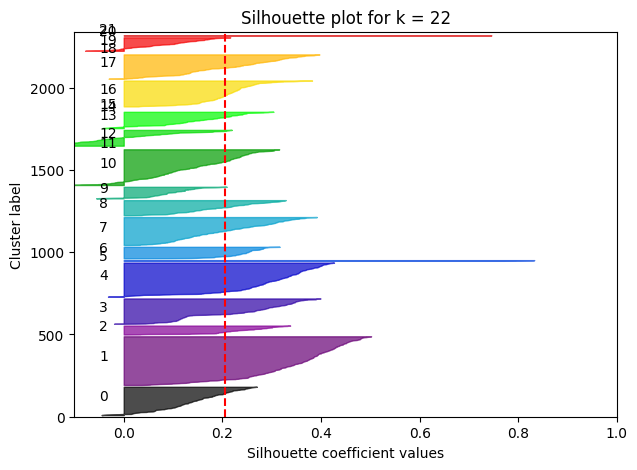

For n_clusters = 24, average silhouette score = 0.221


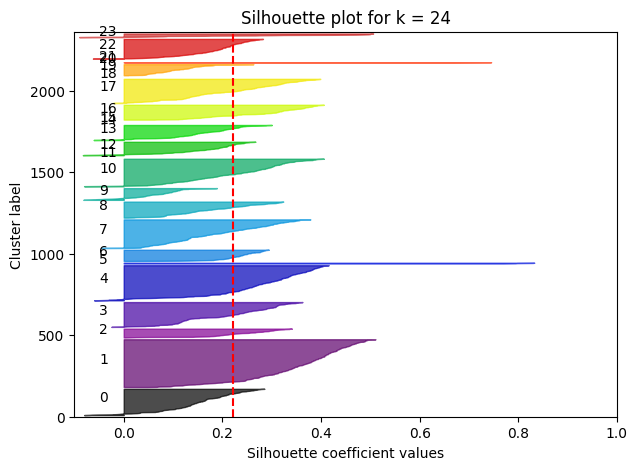

For n_clusters = 26, average silhouette score = 0.223


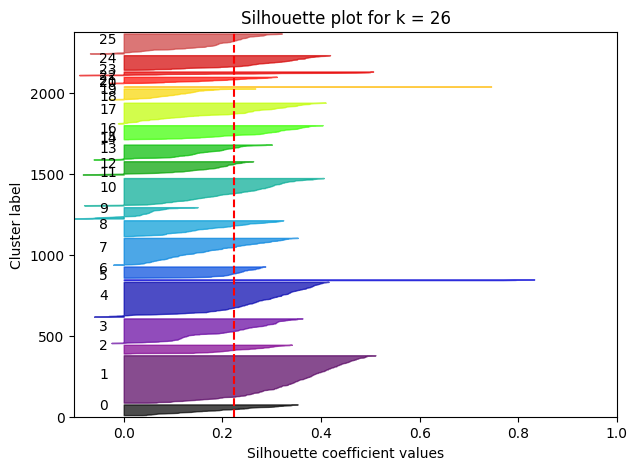

For n_clusters = 28, average silhouette score = 0.226


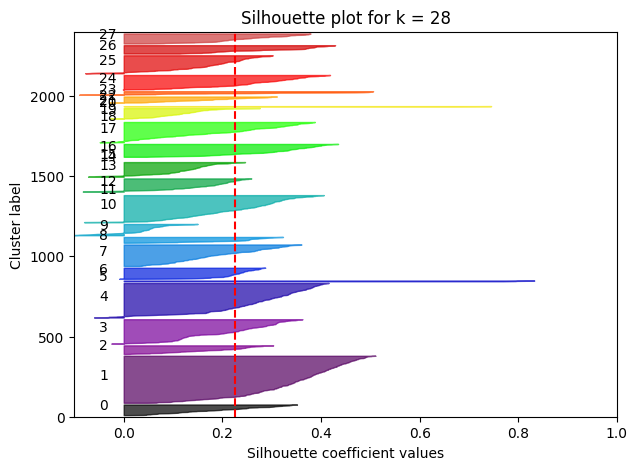

For n_clusters = 30, average silhouette score = 0.231


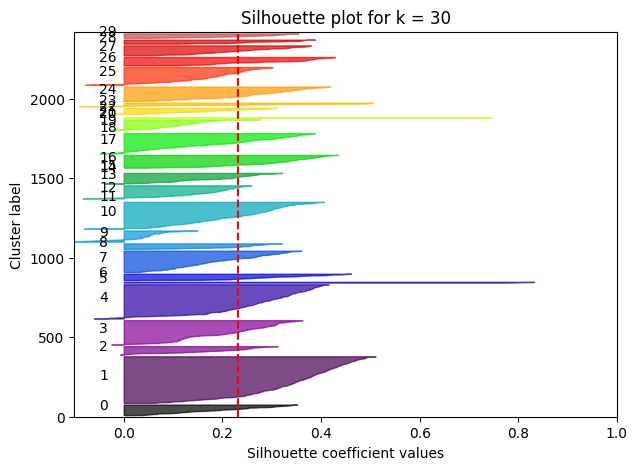

In [27]:
range_n_clusters = range(2, 32, 2)

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_pca)

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")

    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for k = {n_clusters}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

In [28]:
# 1) PCA (use 19 components since it explains ~90%)
pca = PCA(n_components=19, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)

# 2) Similarity (recommend cosine or euclidean)
# Cosine similarity:
sim_cos = cosine_similarity(X_pca)   # higher => more similar

# or distances:
dist_euc = pairwise_distances(X_pca, metric='euclidean')

# Convert distance -> similarity if you want:
sim_from_euc = 1 / (1 + dist_euc)   # simple transform (0..1)

# 3) UMAP for visualization
um = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
X_umap = um.fit_transform(X_scaled_df)

# 4) t-SNE (if you want to compare visuals)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# 5) Clustering example with HDBSCAN (often used on UMAP 2D or PCA)
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
labels_on_umap = clusterer.fit_predict(X_umap)
labels_on_pca = clusterer.fit_predict(X_pca)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

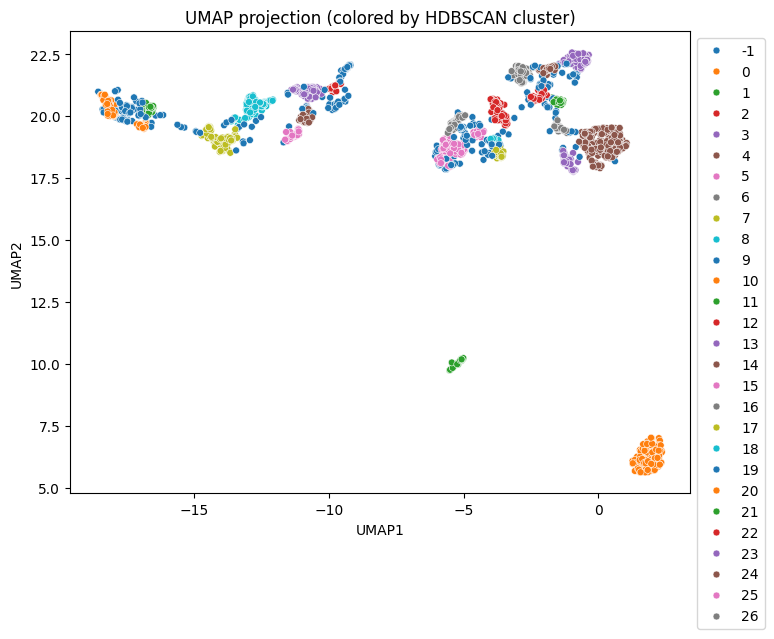

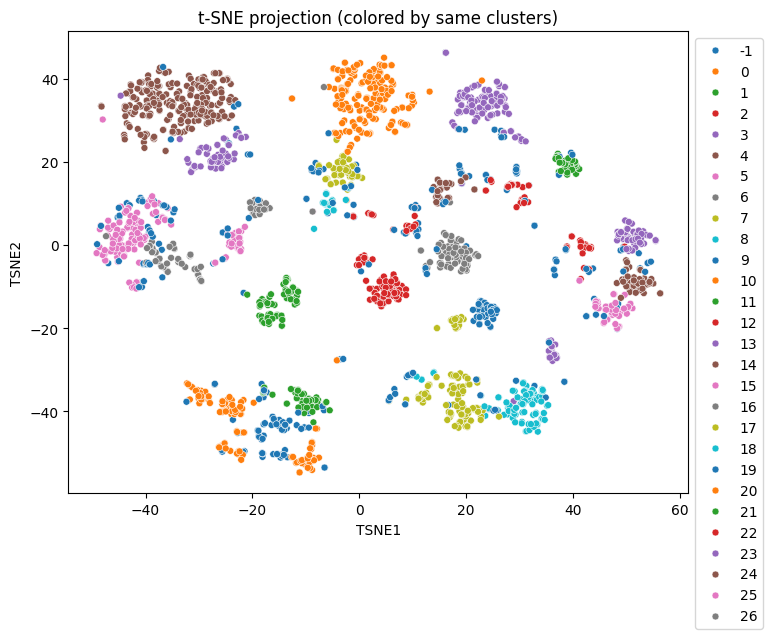

In [29]:
# Build DataFrames to make plotting easier
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels_on_umap

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = labels_on_umap  # reuse same clusters for visual comparison
# or df_tsne['cluster'] = labels_on_pca if you want to compare those clusters instead

# --- UMAP ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='tab10', s=25)
plt.title('UMAP projection (colored by HDBSCAN cluster)')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# --- t-SNE ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10', s=25)
plt.title('t-SNE projection (colored by same clusters)')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

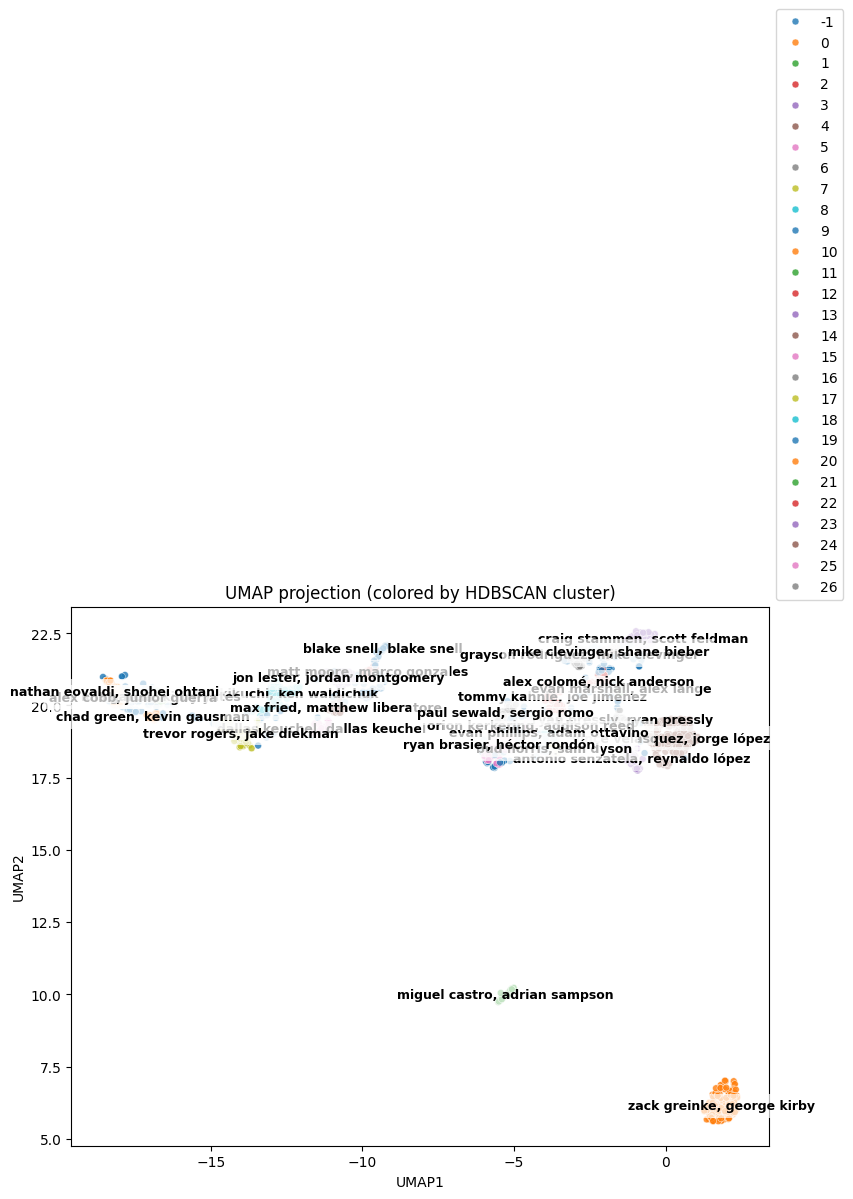

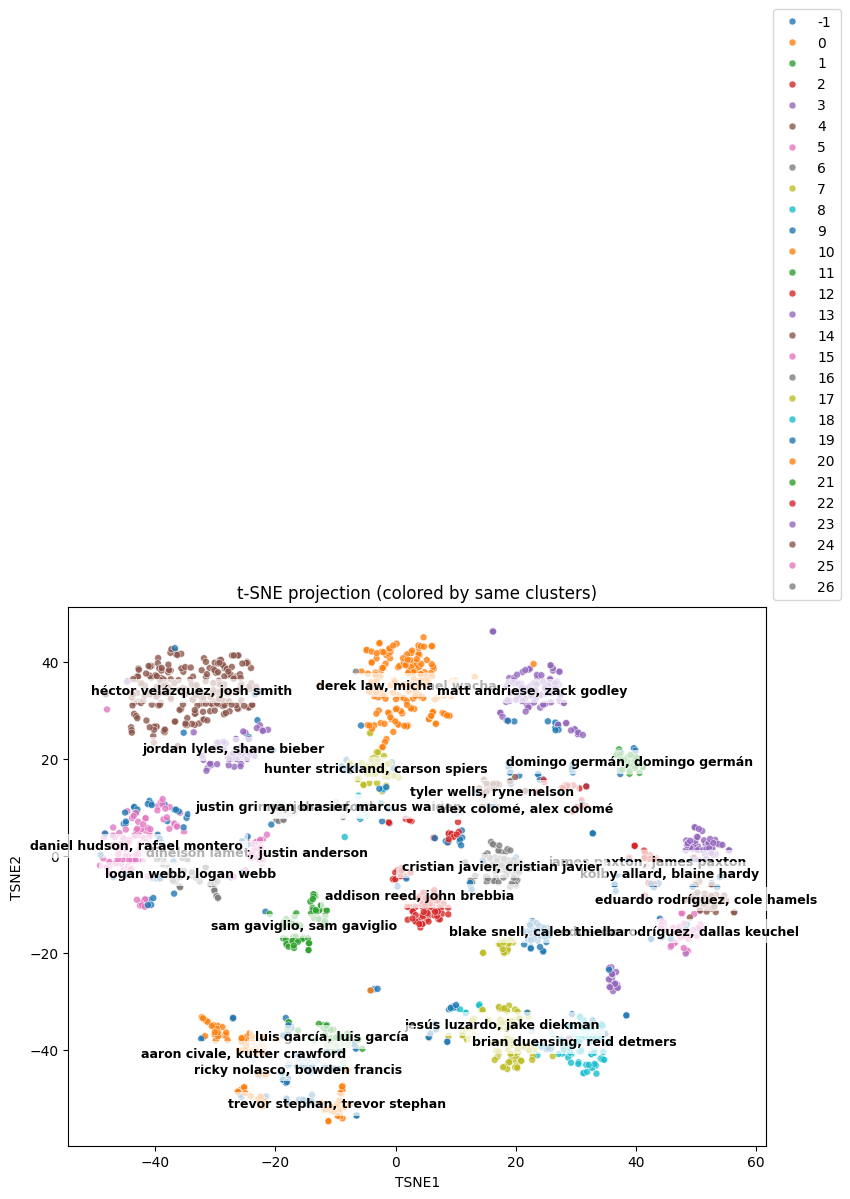

In [30]:
# --- Combine features and IDs ---
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=pitcher_season_df.index)
df_umap['cluster'] = labels_on_umap
df_umap['pitcher'] = pitcher_season_df['name'].values  # ✅ get pitcher IDs
df_umap['game_year'] = pitcher_season_df['game_year'].values  # optional

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'], index=pitcher_season_df.index)
df_tsne['cluster'] = labels_on_umap  # or labels_on_pca if comparing those clusters
df_tsne['pitcher'] = pitcher_season_df['name'].values
df_tsne['game_year'] = pitcher_season_df['game_year'].values

# --- Function to get two representative pitchers per cluster ---
def get_representative_pitchers(df, xcol, ycol, cluster_col='cluster', pitcher_col='pitcher'):
    reps = []
    for c in sorted(df[cluster_col].unique()):
        if c == -1:  # HDBSCAN noise
            continue
        cluster_points = df[df[cluster_col] == c][[xcol, ycol]].values
        centroid = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        idx = np.argsort(distances)[:2]  # two closest
        pitchers = df[df[cluster_col] == c].iloc[idx][pitcher_col].values
        reps.append((c, pitchers))
    return reps

# --- Get representative pitchers ---
umap_reps = get_representative_pitchers(df_umap, 'UMAP1', 'UMAP2')
tsne_reps = get_representative_pitchers(df_tsne, 'TSNE1', 'TSNE2')

# --- UMAP plot ---
plt.figure(figsize=(9,7))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='tab10', s=25, alpha=0.8)
plt.title('UMAP projection (colored by HDBSCAN cluster)')

for cluster_id, pitchers in umap_reps:
    centroid = df_umap[df_umap['cluster'] == cluster_id][['UMAP1','UMAP2']].mean()
    label_text = ", ".join(map(str, pitchers))
    plt.text(centroid['UMAP1'], centroid['UMAP2'], label_text,
             fontsize=9, weight='bold', color='black', ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(bbox_to_anchor=(1,1))
plt.show()

# --- t-SNE plot ---
plt.figure(figsize=(9,7))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10', s=25, alpha=0.8)
plt.title('t-SNE projection (colored by same clusters)')

for cluster_id, pitchers in tsne_reps:
    centroid = df_tsne[df_tsne['cluster'] == cluster_id][['TSNE1','TSNE2']].mean()
    label_text = ", ".join(map(str, pitchers))
    plt.text(centroid['TSNE1'], centroid['TSNE2'], label_text,
             fontsize=9, weight='bold', color='black', ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(bbox_to_anchor=(1,1))
plt.show()


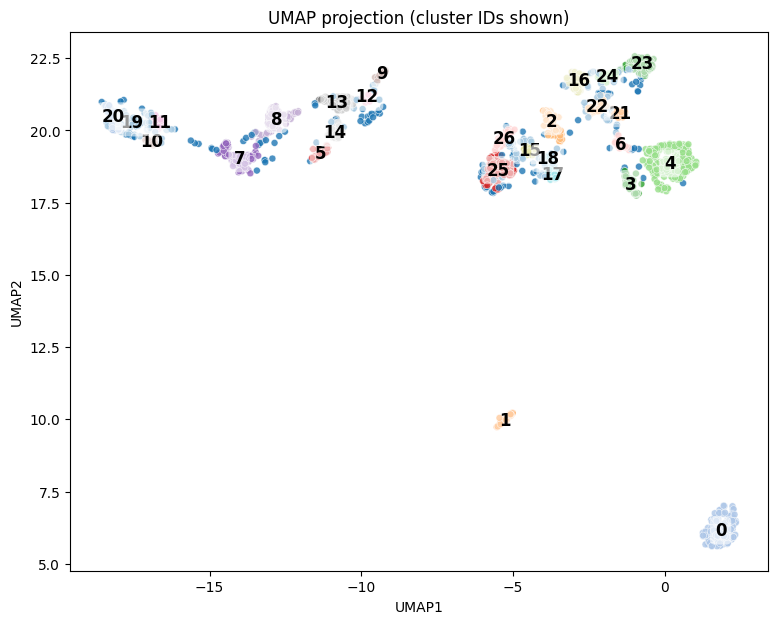

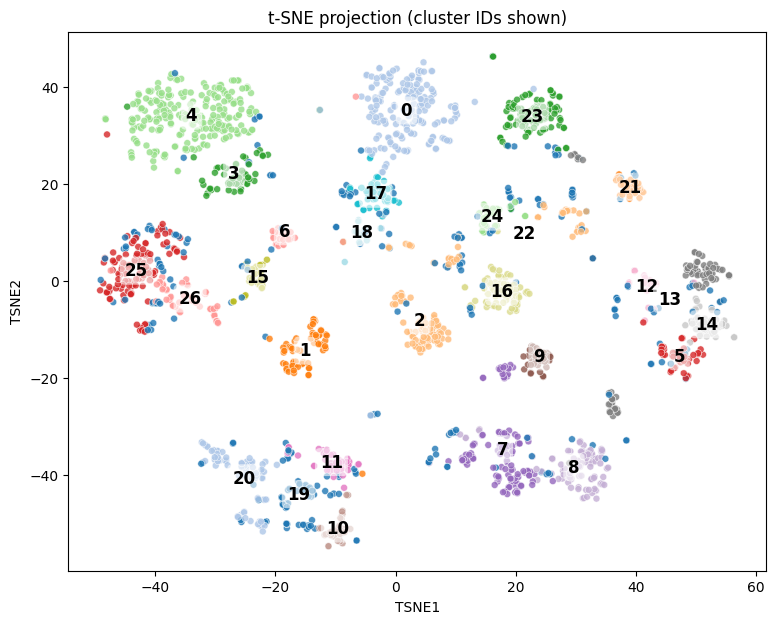

In [31]:
def plot_embedding_with_cluster_labels(df, xcol, ycol, cluster_col='cluster', title=''):
    plt.figure(figsize=(9,7))
    sns.scatterplot(
        data=df, x=xcol, y=ycol,
        hue=cluster_col, palette='tab20',  # tab20 handles up to 20 clusters nicely
        s=25, alpha=0.8, legend=False
    )
    plt.title(title)

    # Add cluster labels at centroid
    for c in sorted(df[cluster_col].unique()):
        if c == -1:  # HDBSCAN noise cluster
            continue
        cluster_points = df[df[cluster_col] == c][[xcol, ycol]]
        centroid = cluster_points.mean()
        plt.text(
            centroid[xcol], centroid[ycol],
            str(c),
            fontsize=12, fontweight='bold',
            ha='center', va='center',
            color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.3')
        )

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()

# --- Plot UMAP ---
plot_embedding_with_cluster_labels(df_umap, 'UMAP1', 'UMAP2',
                                   cluster_col='cluster',
                                   title='UMAP projection (cluster IDs shown)')

# --- Plot t-SNE ---
plot_embedding_with_cluster_labels(df_tsne, 'TSNE1', 'TSNE2',
                                   cluster_col='cluster',
                                   title='t-SNE projection (cluster IDs shown)')

In [32]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap)

target_idx = pitcher_season_df.query("pitcher == 543037 and game_year == 2021").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)


                    name  game_year  similarity
1398        chris flexen       2021         1.0
1633         bryan abreu       2022         1.0
1774  vladimir gutiérrez       2021         1.0
1829        tristan beck       2023         1.0
1812      james mcarthur       2024         1.0
1093       evan marshall       2020         1.0
2083         jared jones       2024         1.0
1232       lucas giolito       2022         1.0
535          gerrit cole       2020         1.0
852             jon gray       2023         1.0


In [33]:
pitcher_season_df['cluster_umap'] = labels_on_umap
pitcher_season_df['cluster_pca'] = labels_on_pca

cluster_summary_umap = (
    pitcher_season_df.groupby('cluster_umap')
    .mean(numeric_only=True)
    .round(3)
)


In [34]:
pd.set_option('display.max_columns', None)
display(cluster_summary_umap)

pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  \
cluster_umap                                                                   
-1            592532.4375   2020.819    -0.343     0.167     0.004      0.03   
 0            582601.4375   2021.055    -1.122     0.794     0.002     0.223   
 1              573024.75   2020.352     0.011     0.153       0.0     0.082   
 2               612600.5   2020.383    -0.928       0.0       0.0     0.033   
 3              607845.75   2020.782     -1.07     0.661     0.001       0.0   
 4             576214.125   2019.534    -1.144     0.722     0.009       0.0   
 5            593253.9375   2020.864     1.101    -0.069       0.0    -0.181   
 6            586668.3125   2020.875       0.0     0.813       0.0     0.005   
 7            592954.6875   2020.786     0.947    -0.017       0.0     0.007   
 8             580978.875   2020.032     1.012    -0.687       0.0       0.0   
 9            594909.3125   2020.475     1.069    -0.643       0.0       0.0   
 10           599982.8125   2020.579    -0.244     0.086       0.0     0.005   
 11            592128.375   2021.457    -0.009       0.0       0.0     0.027   
 12           593907.4375   2019.444     1.094    -0.496       0.0    -0.117   
 13            570374.125   2019.988     1.018    -0.585       0.0    -0.038   
 14            564278.375   2020.978     1.143    -0.807       0.0    -0.133   
 15            632791.125   2021.455       0.0     0.063       0.0     0.003   
 16           612172.3125   2020.539    -1.032     0.662       0.0    -0.031   
 17           559563.5625   2020.565    -1.172       0.0       0.0     0.302   
 18           600088.6875   2021.222    -0.045       0.0       0.0     0.194   
 19              546266.5   2020.207     -0.03      0.67       0.0       0.0   
 20           579284.1875   2021.047    -0.307     0.774       0.0     0.178   
 21             573490.25   2019.417    -1.167     0.732       0.0       0.0   
 22            590224.375   2020.317    -0.326      0.52       0.0     0.035   
 23           536712.9375   2019.475    -1.097     0.795     0.022      0.16   
 24             584007.75   2020.467    -1.132     0.734       0.0     0.201   
 25           596385.8125   2020.439    -1.215     0.003       0.0       0.0   
 26           595414.3125   2020.691    -0.978    -0.004       0.0     0.001   

              pfx_x_FF  pfx_x_FS  pfx_x_KN  pfx_x_SI  pfx_x_SL  pfx_z_CH  \
cluster_umap                                                               
-1              -0.323    -0.123       0.0    -0.399      0.17       0.3   
 0               -0.53       0.0       0.0    -1.106     0.732     0.596   
 1                 0.0    -0.008       0.0    -0.136     0.253     0.235   
 2              -0.685       0.0       0.0       0.0     0.469     0.482   
 3              -0.615       0.0       0.0    -1.009     0.397     0.657   
 4              -0.628    -0.001       0.0    -1.232     0.389     0.583   
 5               0.691       0.0       0.0     1.128    -0.814     0.473   
 6              -0.328       0.0       0.0    -1.006     0.495       0.0   
 7               0.784     0.018       0.0     1.066    -0.534     0.415   
 8               0.525     0.009       0.0     1.094    -0.539     0.725   
 9               0.571       0.0       0.0       0.0    -0.442     0.954   
 10              -0.79    -0.888       0.0     -0.07     0.325     0.233   
 11             -0.787    -0.912       0.0    -1.284     0.472     0.015   
 12              0.783       0.0       0.0     0.037    -0.045     0.621   
 13              0.653     0.002       0.0     1.176    -0.006     0.618   
 14               0.65     0.037       0.0     1.206    -0.682     0.656   
 15              -0.77       0.0       0.0    -1.246     0.538       0.0   
 16             -0.544       0.0       0.0       0.0     0.502     0.747   
 17             -0.585       0.0       0.0    -1.243     0.748     0.475   
 18             -0.66

In [35]:
um_more_comps = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=19, random_state=42)
X_umap_more_comps = um_more_comps.fit_transform(X_scaled_df)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [36]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_df.query("pitcher == 543037 and game_year == 2021").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

                    name  game_year  similarity
591           trevor may       2019    0.999997
1890        ian anderson       2021    0.999992
1868     cristian javier       2022    0.999991
1664     griffin canning       2023    0.999983
1267      chris stratton       2021    0.999983
589          matt magill       2018    0.999980
1952       logan gilbert       2022    0.999979
1829        tristan beck       2023    0.999976
1774  vladimir gutiérrez       2021    0.999976
1606         griffin jax       2022    0.999975


In [37]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels_on_umap = clusterer.fit_predict(X_umap_more_comps)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [38]:
pitcher_season_df['cluster_umap_more_comps'] = labels_on_umap

cluster_summary_umap = (
    pitcher_season_df.groupby('cluster_umap_more_comps')
    .mean(numeric_only=True)
    .round(3)
)

display(cluster_summary_umap)

pitcher  game_year  pfx_x_CH  pfx_x_CU  \
cluster_umap_more_comps                                                
-1                        594884.9375   2020.651     0.332    -0.085   
 0                          573024.75   2020.352     0.011     0.153   
 1                         581677.125   2021.049     -1.12     0.797   
 2                        583761.4375   2020.972    -0.204     0.438   
 3                         584081.625   2019.893    -1.039     0.723   
 4                        598264.5625    2020.77    -0.945     0.007   
 5                          614385.25   2021.167    -0.065       0.0   
 6                          614385.25   2020.161    -1.173       0.0   
 7                        630920.0625   2021.176     0.997       0.0   
 8                        594909.3125   2020.475     1.069    -0.643   
 9                        619341.5625   2020.857    -1.161     0.571   
 10                       625375.5625     2021.0       0.0    -0.044   
 11                       556514.4375   2018.667    -0.761     0.681   
 12                       619324.0625   2020.731    -1.058     0.669   
 13                       586490.3125   2020.805     1.103    -0.025   
 14                       594573.4375   2020.053    -0.322     0.562   
 15                       539899.1875   2021.429      1.12    -0.598   
 16                       568260.4375   2020.763     1.144    -0.833   
 17                       602464.3125     2019.0    -0.932      0.95   
 18                        572466.875   2019.514    -1.193     0.738   
 19                         617254.25   2019.909     0.086     -0.58   
 20                      448566.03125     2018.4     1.214    -0.435   
 21                         589890.75     2019.4     1.226     -0.48   
 22                       525631.8125   2019.393    -1.027      0.83   
 23                        583612.375   2019.294     1.022    -0.823   
 24                       569185.4375     2020.4    -0.067       0.0   
 25                        554054.625   2020.429     1.143    -0.706   
 26                        559628.625    2019.76     1.098    -0.495   
 27                       549307.1875     2019.5    -0.948      0.68   
 28                       587100.1875   2020.727    -1.177      0.81   
 29                       571393.9375     2020.5     1.067    -0.757   
 30                          563319.5   2021.118     1.061    -0.527   
 31                       575769.0625   2018.524      1.02    -0.658   
 32                        602421.625   2021.318     1.073       0.0   
 33                       554171.4375   2020.148     1.298       0.0   

                         pfx_x_EP  pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  \
cluster_umap_more_comps                                                     
-1                            0.0     0.012      0.23     0.041     0.003   
 0                            0.0     0.082       0.0    -0.008       0.0   
 1                          0.007     0.226    -0.524    -0.013       0.0   
 2                            0.0     0.083    -0.668    -0.868    -0.003   
 3                          0.007       0.0    -0.603    -0.001       0.0   
 4                            0.0     0.048    -0.724    -0.003    -0.001   
 5                            0.0     0.096    -0.677       0.0       0.0   
 6                            0.0     0.009     -0.69       0.0       0.0   
 7                            0.0       0.0     0.601       0.0       0.0   
 8                            0.0       0.0     0.571       0.0       0.0   
 9                            0.0       0.0    -0.721       0.0       0.0   
 10                           0.0     0.062     0.416     0.019       0.0   
 11                           0.0       0.0    -0.355       0.0       0.0   
 12                           0.0    -0.018    -0.569       0.0       0.0   
 13                           0.0    -0.167      0.69       0.0       0.0   
 14                           0.0       0.0    -0.543   

In [39]:
print(pitcher_season_df[pitcher_season_df['cluster_umap_more_comps']==12][['name', 'game_year']])

                         name  game_year
39           justin verlander       2019
41           justin verlander       2023
166               javy guerra       2019
205              joakim soria       2017
342              paolo espino       2021
343              paolo espino       2022
664            ross stripling       2017
741                 derek law       2019
957              jacob degrom       2020
1060           mike clevinger       2018
1061           mike clevinger       2019
1229            lucas giolito       2019
1230            lucas giolito       2020
1231            lucas giolito       2021
1239               lucas sims       2020
1262        drew steckenrider       2018
1266           chris stratton       2020
1364             tejay antone       2020
1365              kyle zimmer       2020
1384        antonio senzatela       2017
1385        antonio senzatela       2019
1386        antonio senzatela       2020
1426           reynaldo lópez       2019
1427           r

Above players are all righties (good) who mainly throw FF, FC, FS, SL (good, but many throw them differently which is bad)
For instance, emmanuel clase and matt waldron are very different pitchers
kevin kelly throws sidearm (very low arm angle when he pitches), which is very different from most pitchers in this cluster.
Some of these pitchers throw their pitches very hard (clase, graterol, treinen), while others throw much slower

In [40]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_df.query("pitcher == 493603 and game_year == 2019").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

                name  game_year  similarity
472    marcus walden       2019    0.999999
1787    matt waldron       2024    0.999997
1415   evan phillips       2024    0.999994
970    blake treinen       2020    0.999992
769      ryan tepera       2017    0.999991
391     ryan brasier       2023    0.999990
1780  emmanuel clase       2022    0.999987
1414   evan phillips       2023    0.999987
1260   dominic leone       2017    0.999986
1413   evan phillips       2022    0.999985


In [41]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_df.query("pitcher == 687330 and game_year == 2024").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

               name  game_year  similarity
1731  ryan thompson       2024    0.999989
366    darren o'day       2017    0.999989
1620   tyler rogers       2024    0.999987
1616   tyler rogers       2020    0.999986
1619   tyler rogers       2023    0.999979
2078    penn murfee       2022    0.999977
1617   tyler rogers       2021    0.999976
1593    adam cimber       2021    0.999972
1591    adam cimber       2018    0.999970
1618   tyler rogers       2022    0.999969


In [42]:
def draw_reference_circles(ax, radii=[6, 12, 18, 24]):
    for r in radii:
        circle = Circle((0, 0), r, edgecolor="lightgray", facecolor="none", lw=0.8, ls="--", zorder=0)
        ax.add_patch(circle)
    # Keep equal aspect ratio so circles look round
    ax.set_aspect("equal", adjustable="datalim")

In [43]:
def reshape_pitcher_season_df(pitcher_season_df):
    pitch_types = ["CH", "CU", "EP", "FC", "FF", "FS", "KN", "SI", "SL"]

    long_df = []
    for pitch in pitch_types:
        if f"pfx_x_{pitch}" not in pitcher_season_df.columns:
            continue
        temp = pitcher_season_df[["pitcher", "name", "game_year"]].copy()
        temp["pitch_type"] = pitch
        temp["pfx_x"] = pitcher_season_df[f"pfx_x_{pitch}"]
        temp["pfx_z"] = pitcher_season_df[f"pfx_z_{pitch}"]
        temp["release_speed"] = pitcher_season_df[f"release_speed_{pitch}"]
        temp["pitch_frac"] = pitcher_season_df.get(f"{pitch}_frac", None)
        long_df.append(temp)

    movement_long = pd.concat(long_df)
    # FIX: Filter out pitches not thrown (pfx, speed, or usage is NaN/0)
    movement_long = movement_long.dropna(subset=["pfx_x", "pfx_z", "release_speed", "pitch_frac"])
    movement_long = movement_long[movement_long["pitch_frac"] > 0.01]  # Remove pitches with <1% usage
    
    return movement_long

In [44]:
def plot_pitcher_movement(df, pitcher_name, year):
    p_df = df[(df["name"] == pitcher_name) & (df["game_year"] == year)]
    if p_df.empty:
        print(f"No data for {pitcher_name} ({year})")
        return

    plt.figure(figsize=(8, 8))
    sc = plt.scatter(
        p_df["pfx_x"],
        p_df["pfx_z"],
        c=p_df["release_speed"],
        s=p_df["pitch_frac"] * 2000 if "pitch_frac" in p_df else 200,
        cmap="coolwarm",
        edgecolors="black",
    )

    for _, row in p_df.iterrows():
        plt.text(row["pfx_x"], row["pfx_z"], row["pitch_type"], fontsize=9, ha="center", va="center")

    plt.axhline(0, color="gray", lw=1)
    plt.axvline(0, color="gray", lw=1)
    plt.xlabel("Horizontal Movement (inches)")
    plt.ylabel("Vertical Movement (inches)")
    plt.title(f"{pitcher_name} ({year}) Pitch Movement")
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(sc)
    cbar.set_label("Velocity (mph)")
    plt.show()

In [45]:
def compare_pitchers_overlay(df, nameA, yearA, nameB, yearB, lim_inches=25, size_scale=5000):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = ["blue", "red"]

    summary_tables = {}

    for color, (pname, pyear) in zip(colors, [(nameA, yearA), (nameB, yearB)]):
        p_df = df[(df["name"] == pname) & (df["game_year"] == pyear)]
        if p_df.empty:
            print(f"No data for {pname} ({pyear})")
            continue

        # Convert feet → inches and flip horizontal direction
        p_df = p_df.copy()
        p_df["pfx_x"] = -p_df["pfx_x"] * 12
        p_df["pfx_z"] = p_df["pfx_z"] * 12

        # Scale circle size by pitch usage
        sizes = p_df["pitch_frac"] * size_scale

        ax.scatter(
            p_df["pfx_x"], p_df["pfx_z"],
            s=sizes,
            color=color, alpha=0.5, label=f"{pname} ({pyear})",
            edgecolors="black", zorder=3
        )

        for _, row in p_df.iterrows():
            ax.text(row["pfx_x"], row["pfx_z"], row["pitch_type"], fontsize=8, ha="center", zorder=4)

        # Store summary info for table - FIX: use pitch_type directly as key
        summary_tables[f"{pname} ({pyear})"] = {
            row["pitch_type"]: (f"{row['release_speed']:.1f}", f"{row['pitch_frac']*100:.1f}%")
            for _, row in p_df.iterrows()
        }

    # Reference lines & circles
    ax.axhline(0, color="gray", lw=1, zorder=1)
    ax.axvline(0, color="gray", lw=1, zorder=1)
    draw_reference_circles(ax)

    # Keep consistent framing
    ax.set_xlim(-lim_inches, lim_inches)
    ax.set_ylim(-lim_inches, lim_inches)
    ax.set_aspect("equal")

    ax.set_xlabel("Horizontal Movement (inches, arm-side → right)")
    ax.set_ylabel("Vertical Movement (inches, rise → up)")
    ax.set_title("Pitch Movement Comparison (Overlay)")
    ax.legend(markerscale=0.3)

    pitch_order = ["FF", "SI", "FC", "SL", "CU", "CH", "FS", "KN", "EP"]

    for i, (label, pdata) in enumerate(summary_tables.items()):
        # FIX: Only include pitches that the pitcher actually throws
        pitches_thrown = [p for p in pitch_order if p in pdata]
        
        # Build table using only pitches thrown by this pitcher
        velo_row = [pdata[p][0] for p in pitches_thrown]
        usage_row = [pdata[p][1] for p in pitches_thrown]
        summary_df = pd.DataFrame([velo_row, usage_row], index=["Velo (mph)", "Usage %"], columns=pitches_thrown)

        # Table placement (stacked vertically)
        y_offset = -0.25 - (i * 0.18)
        table_ax = fig.add_axes([0.1, y_offset, 0.8, 0.15])
        table_ax.axis("off")
        table = table_ax.table(
            cellText=summary_df.values,
            rowLabels=summary_df.index,
            colLabels=summary_df.columns,
            cellLoc="center",
            rowLoc="center",
            loc="center"
        )
        table.scale(1.1, 1.2)
        table.auto_set_font_size(False)
        table.set_fontsize(8)

        # Add pitcher label above table
        table_ax.text(0.5, 1.15, label, ha="center", va="bottom", fontsize=10, color=colors[i], transform=table_ax.transAxes)

    plt.tight_layout()
    plt.show()

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


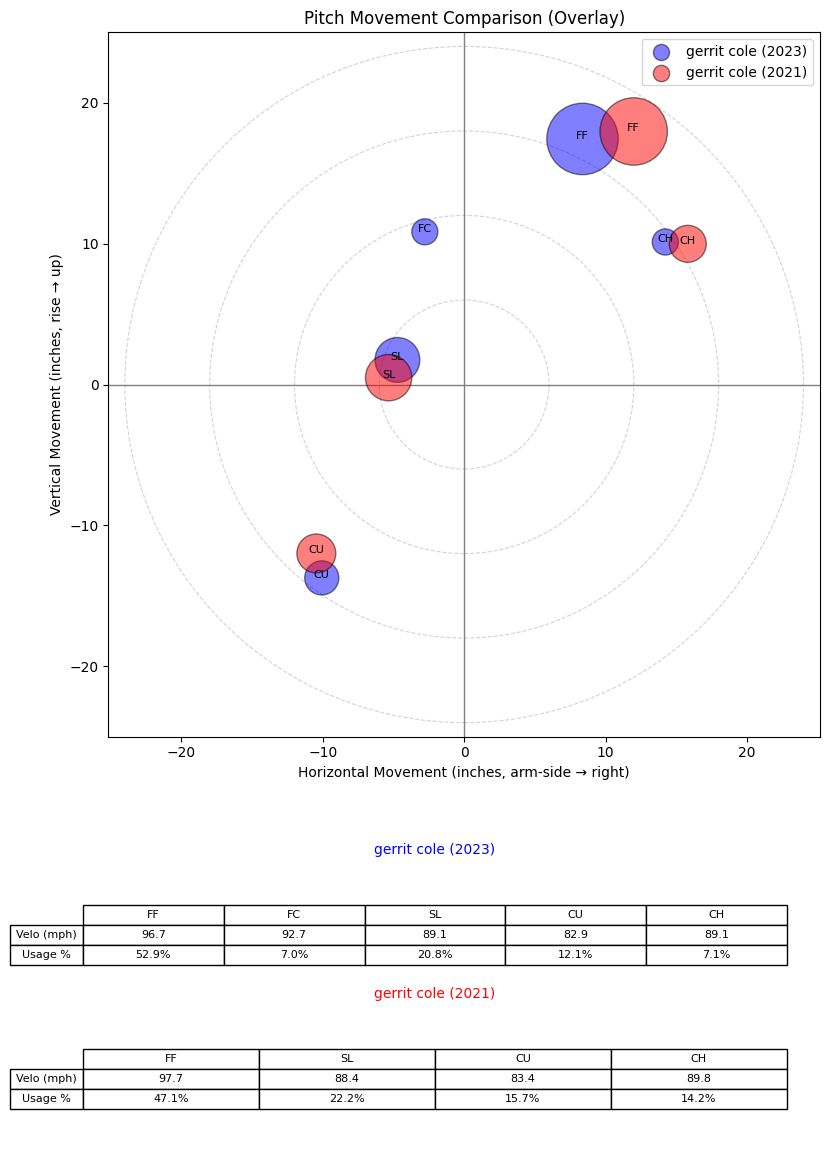

In [46]:
movement_long = reshape_pitcher_season_df(pitcher_season_df)
compare_pitchers_overlay(movement_long, "gerrit cole", 2023, "gerrit cole", 2021)

In [47]:
# create table of league averages for pitch types
league_avg = {}
pitch_types = ['CH','CU','FC','FF','FS','KN','SI','SL']

for pitch in pitch_types:
    # Columns for this pitch
    pitch_cols = [col for col in pitcher_season_df.columns if col.endswith(f'_{pitch}')]
    # Only compute mean using pitchers who throw it (throws_{pitch} > 0)
    mask = pitcher_season_df[f'throws_{pitch}'] > 0
    league_avg[pitch] = pitcher_season_df.loc[mask, pitch_cols].mean()


In [48]:
# impute league-averages for each pitch a pitcher doesn't throw
pitcher_season_imputed = pitcher_season_df.copy()

for pitch in pitch_types:
    pitch_cols = [col for col in pitcher_season_df.columns if col.endswith(f'_{pitch}')]
    mask = pitcher_season_imputed[f'throws_{pitch}'] == 0
    pitcher_season_imputed.loc[mask, pitch_cols] = pitcher_season_imputed.loc[mask, pitch_cols].replace(0, league_avg[pitch])


In [76]:
id_cols = ['pitcher', 'game_year', 'name', 'name_first', 'name_last']
exclude_cols = [c for c in pitcher_season_imputed.columns if c.endswith('_frac') or c.startswith('spin_axis') or c.startswith('release_spin') or c.startswith('throws_')]
feature_cols = [c for c in pitcher_season_imputed.columns if c not in id_cols + exclude_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitcher_season_imputed[feature_cols])

# Turn back into a DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=pitcher_season_imputed.index)


In [77]:
similarity_matrix = cosine_similarity(X_scaled_df)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1),
    columns=pitcher_season_df[['pitcher', 'game_year']].apply(tuple, axis=1)
)

similarity_df.index = pd.MultiIndex.from_tuples(similarity_df.index, names=['pitcher', 'game_year'])
similarity_df.columns = pd.MultiIndex.from_tuples(similarity_df.columns, names=['pitcher', 'game_year'])

In [78]:
cole_2021 = similar_pitchers(543037, 2021)
print(cole_2021)

chapman_2018 = similar_pitchers(547973, 2023)
print(chapman_2018)

            Pitcher  Season  Cosine Similarity
0       gerrit cole  2020.0           0.954352
1       gerrit cole  2019.0           0.937750
2  brandon woodruff  2020.0           0.911506
3       gerrit cole  2018.0           0.910670
4      bobby miller  2023.0           0.908940
5         chad kuhl  2017.0           0.905853
6       gerrit cole  2022.0           0.897740
7  kendall graveman  2021.0           0.897215
8       jared jones  2024.0           0.892294
9       bryan abreu  2022.0           0.885121
           Pitcher  Season  Cosine Similarity
0  aroldis chapman  2024.0           0.899945
1  aroldis chapman  2021.0           0.851325
2      pedro strop  2017.0           0.761455
3        a. j. puk  2023.0           0.727769
4     david bednar  2021.0           0.715800
5    kyle finnegan  2023.0           0.635184
6      yuki matsui  2024.0           0.628297
7     david bednar  2023.0           0.626494
8  justin martinez  2024.0           0.609972
9      sam freeman  201

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


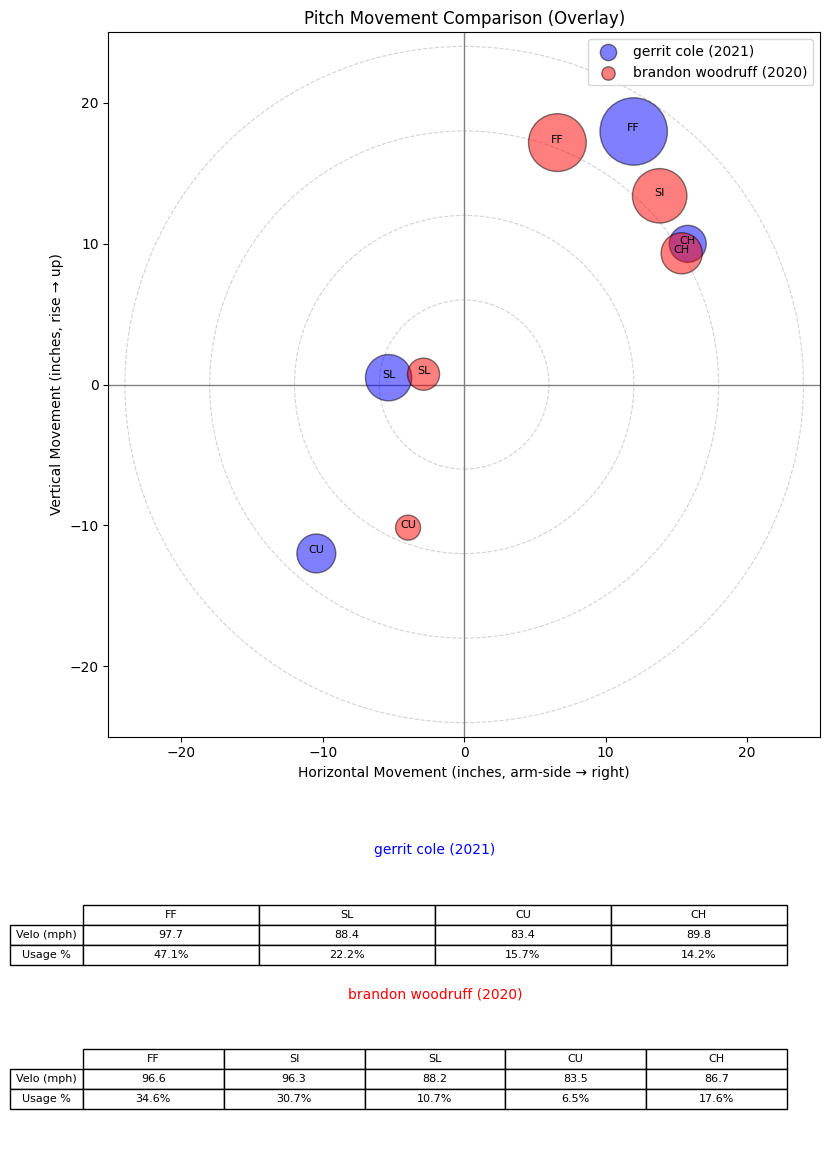

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


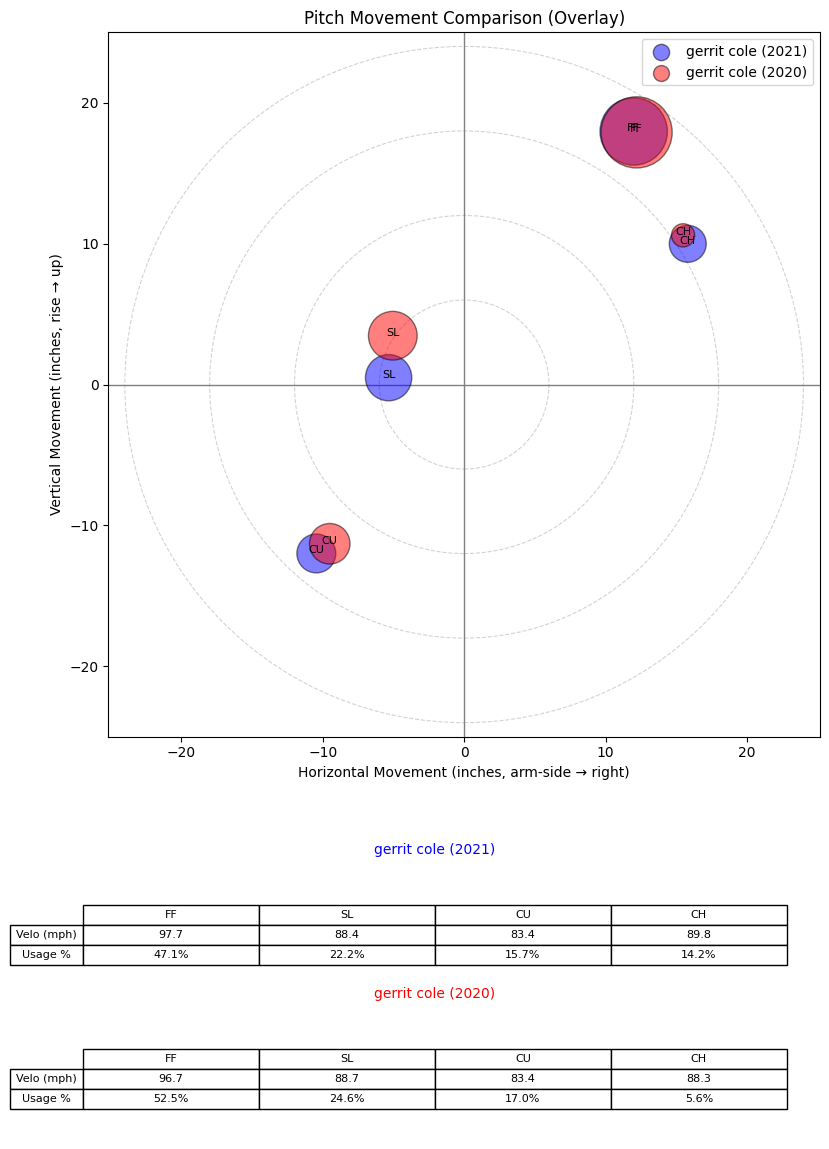

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


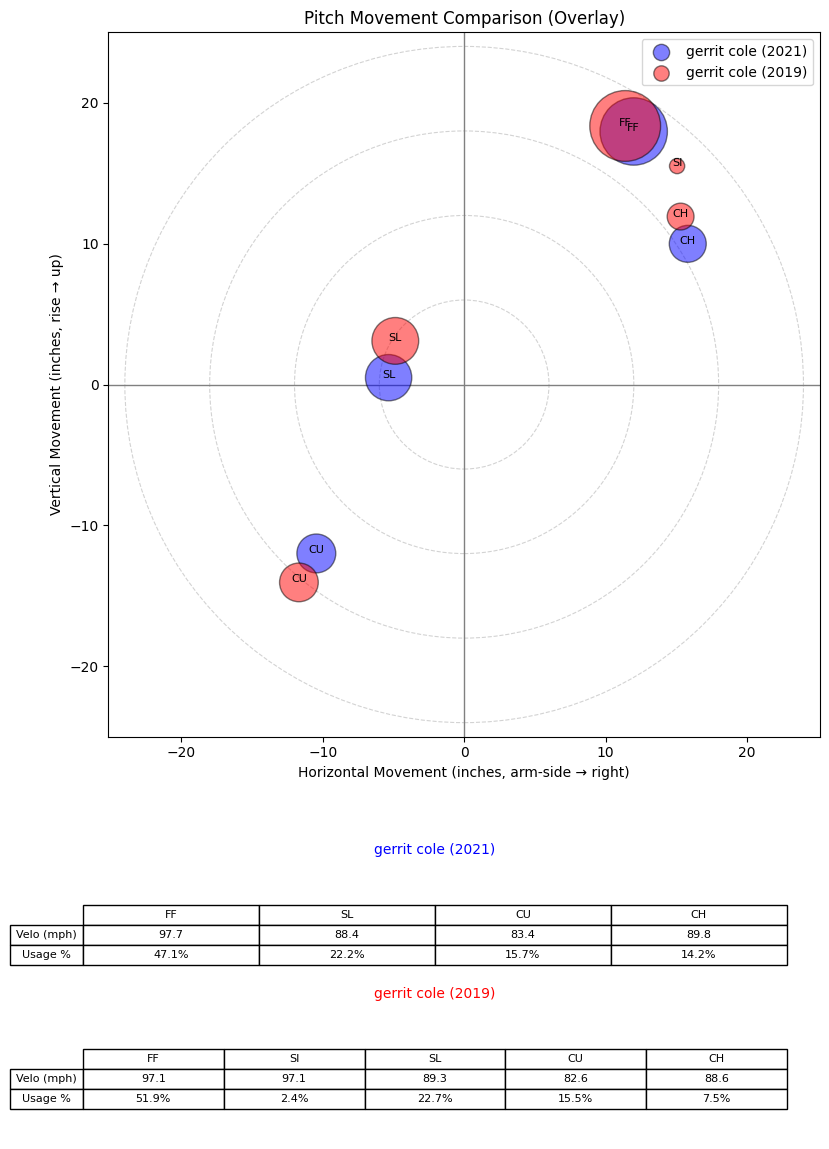

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


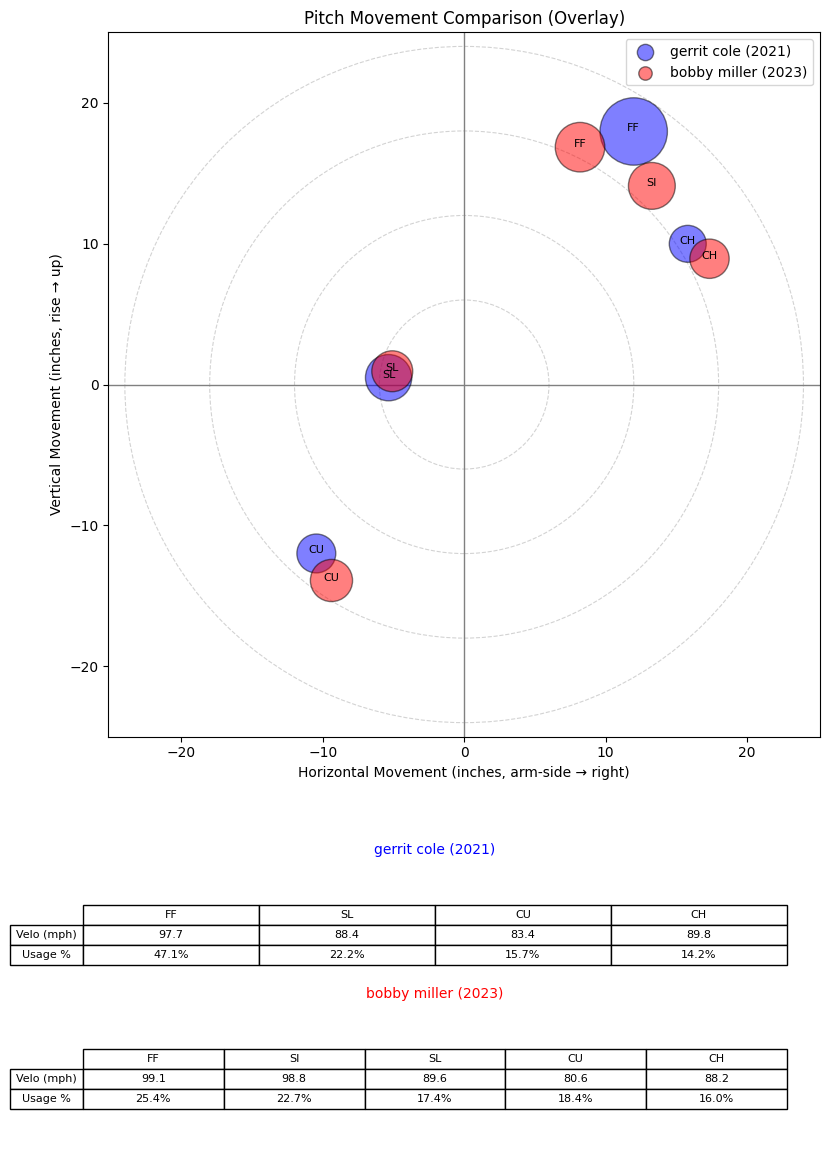

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


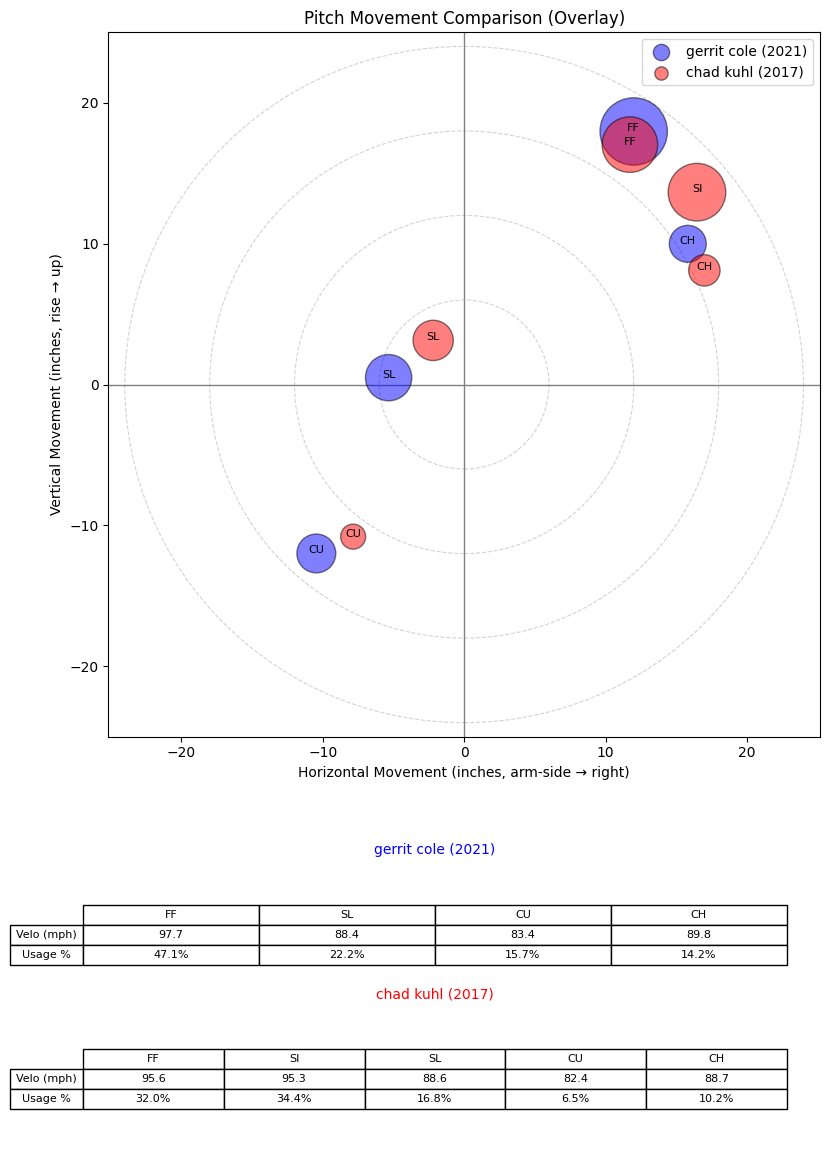

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


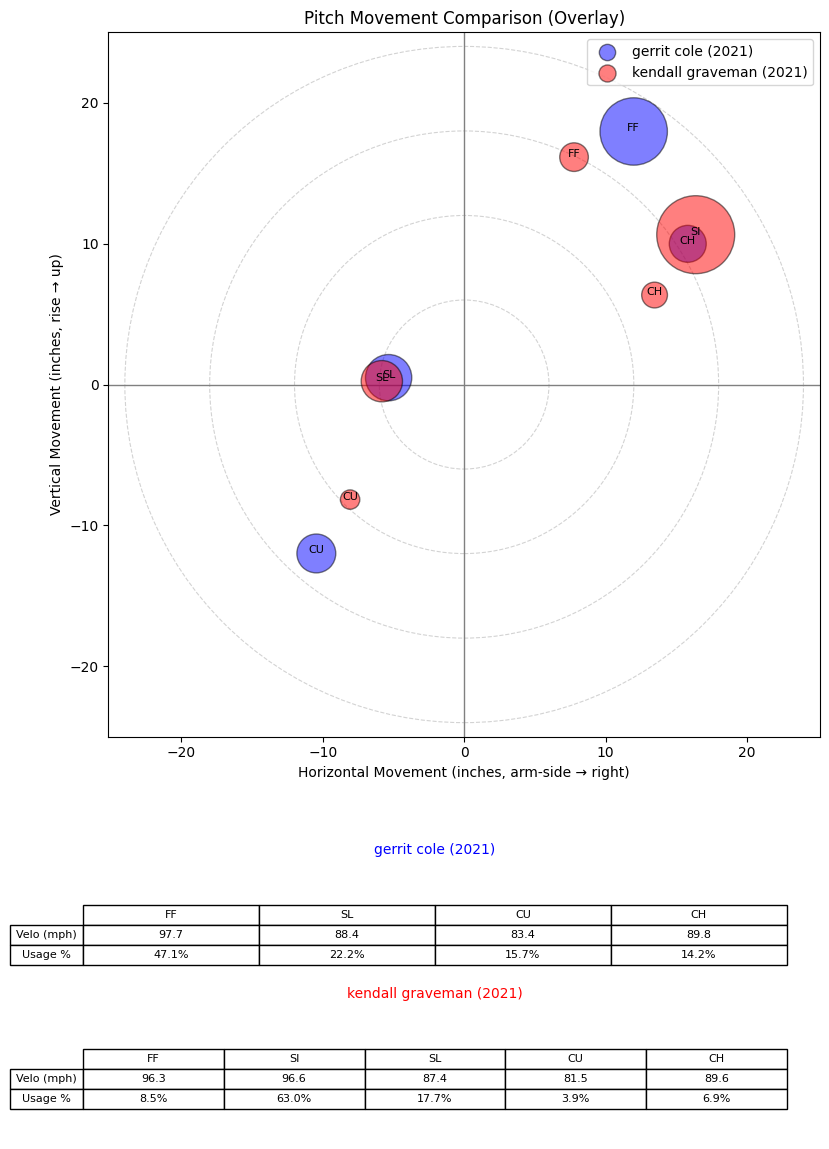

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


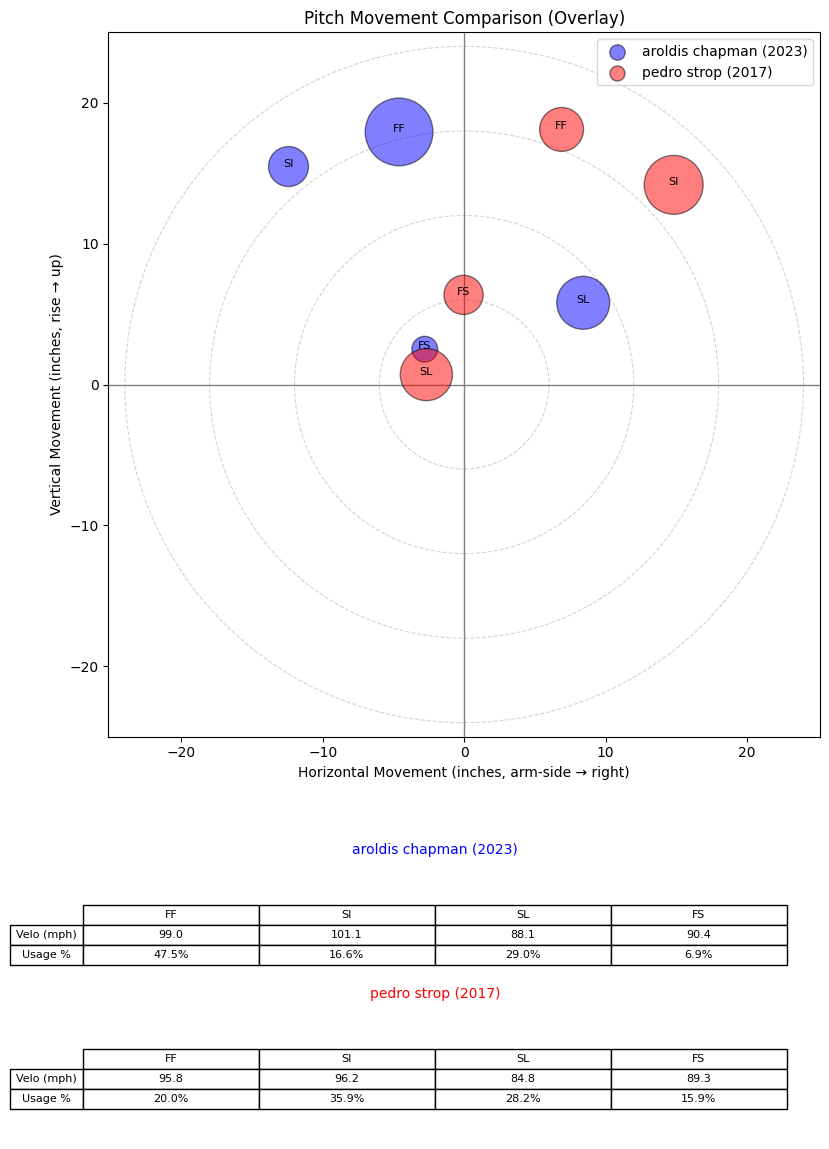

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


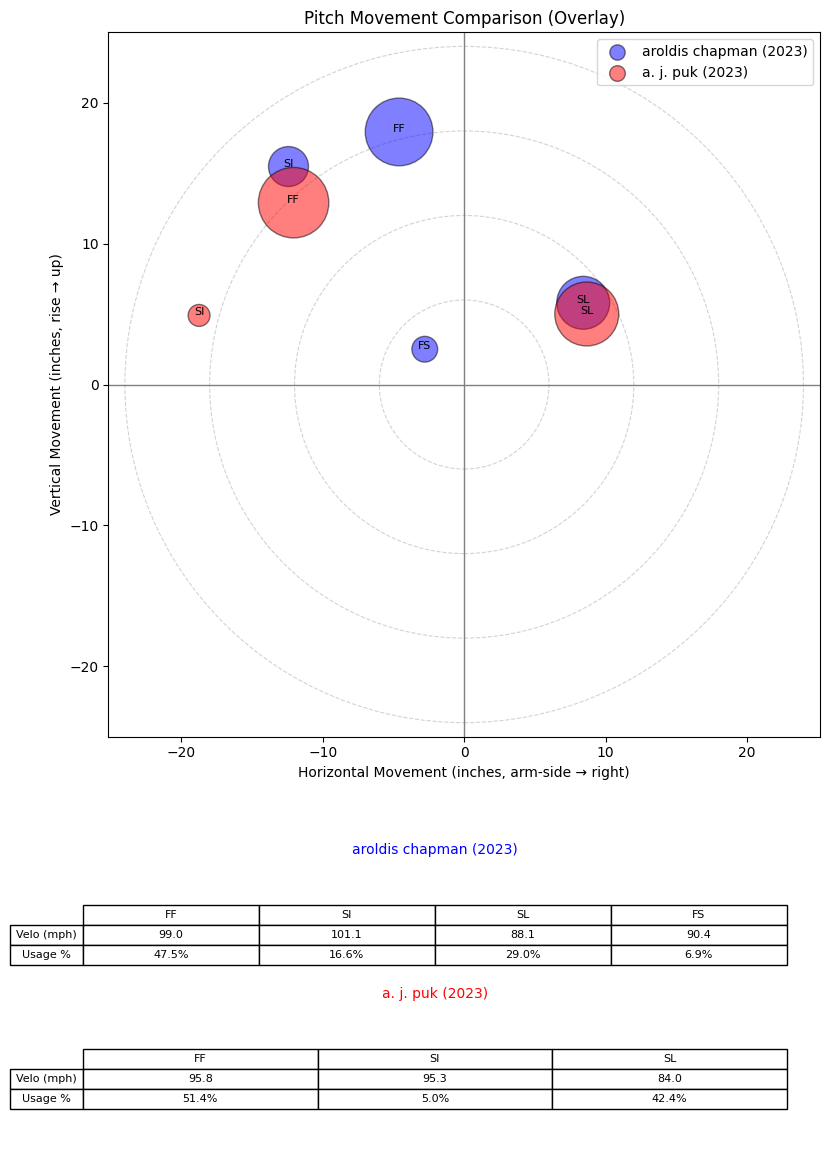

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


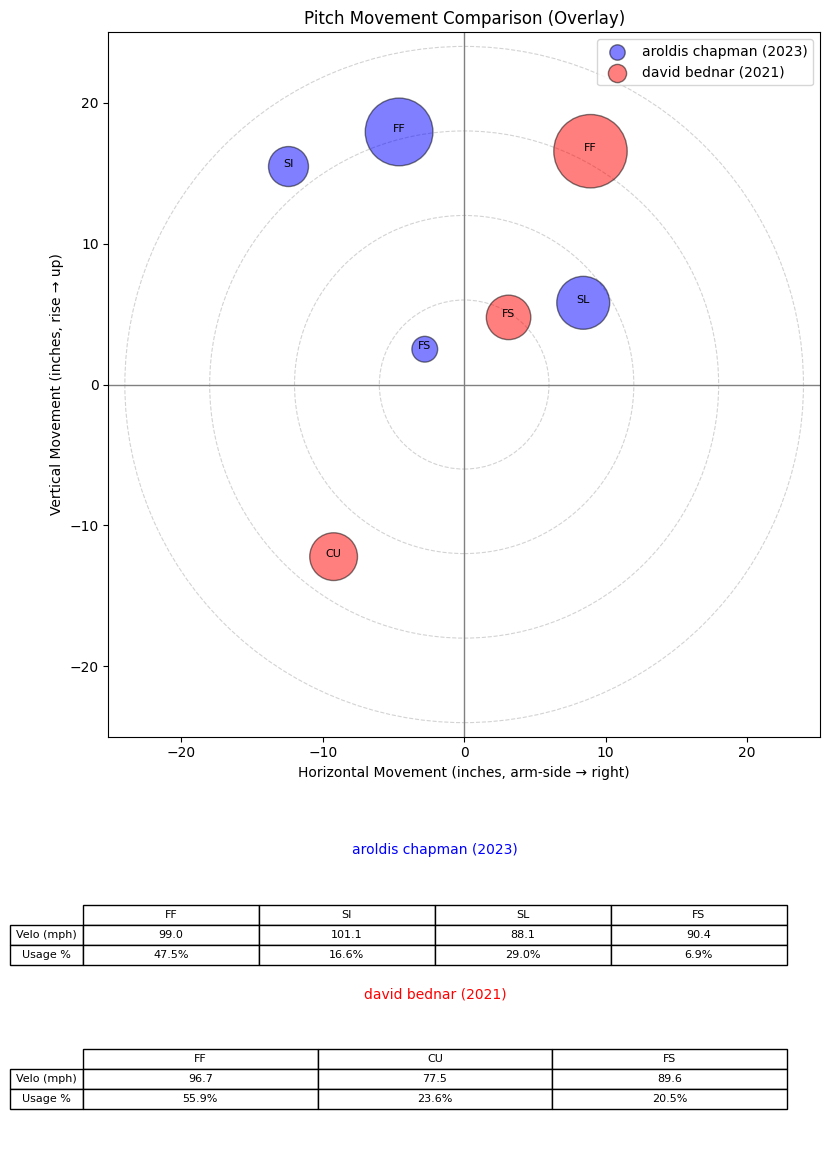

In [79]:
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "brandon woodruff", 2020)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "gerrit cole", 2020)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "gerrit cole", 2019)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "bobby miller", 2023)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "chad kuhl", 2017)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "kendall graveman", 2021)
compare_pitchers_overlay(movement_long, "aroldis chapman", 2023, "pedro strop", 2017)
compare_pitchers_overlay(movement_long, "aroldis chapman", 2023, "a. j. puk", 2023)
compare_pitchers_overlay(movement_long, "aroldis chapman", 2023, "david bednar", 2021)

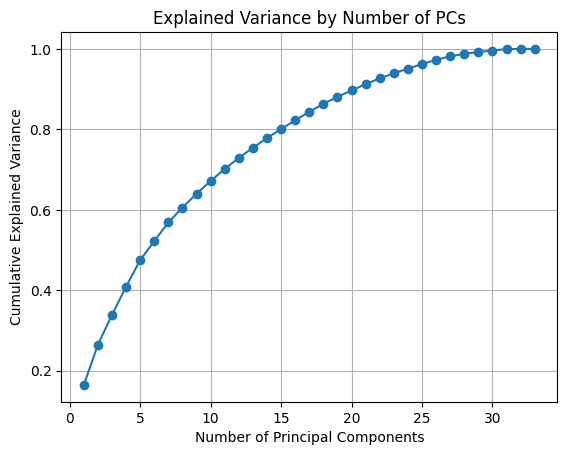

Number of components to explain 90% variance: 21


In [80]:
# Fit PCA
pca = PCA()
pca.fit(X_scaled_df)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCs')
plt.grid(True)
plt.show()

target_variance = 0.90  # e.g. keep 90% of total variance

n_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components to explain {target_variance*100:.0f}% variance: {n_components}")

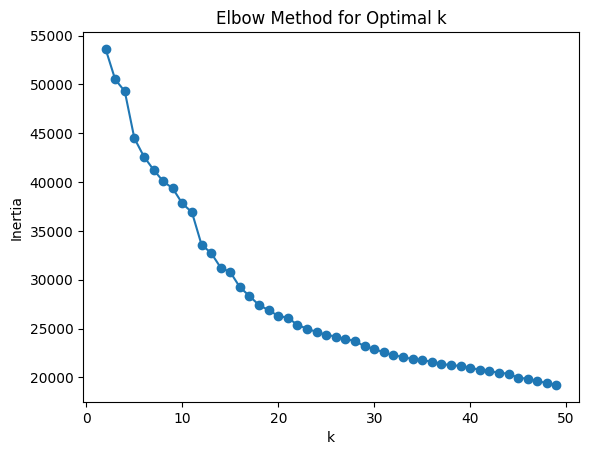

In [81]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

inertias = []
K = range(2, 50)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # after PCA
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

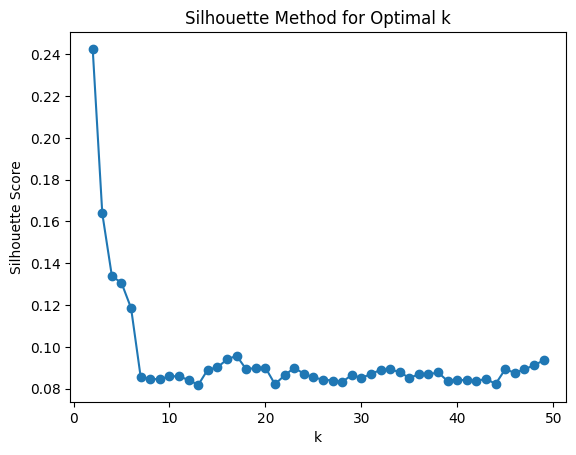

In [82]:
sil_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil_scores.append(silhouette_score(X_pca, labels))

plt.plot(K, sil_scores, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [83]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_pca)
pitcher_clusters = pitcher_season_df.copy()
pitcher_clusters["cluster"] = labels
pitcher_clusters.groupby("cluster")["name"].apply(list)

cluster
0     [cc sabathia, rich hill, rich hill, rich hill,...
1     [john lackey, adam wainwright, adam wainwright...
2     [francisco liriano, andrew miller, andrew mill...
3     [zack greinke, zack greinke, zack greinke, jam...
4     [kenley jansen, kenley jansen, kenley jansen, ...
5     [ryan madson, ervin santana, santiago casilla,...
6     [junior guerra, junior guerra, junior guerra, ...
7     [fernando rodney, fernando rodney, dustin mcgo...
8     [brad ziegler, jared hughes, sergio romo, serg...
9                                      [adrián morejón]
10    [adam cimber, adam cimber, adam cimber, adam c...
11           [r. a. dickey, george kirby, george kirby]
12    [jesse chavez, corey kluber, corey kluber, cha...
13    [jorge de la rosa, sean doolittle, clayton ker...
14    [ervin santana, ian kennedy, chris martin, chr...
15                         [zack greinke, zack greinke]
16                                       [matt waldron]
17    [cc sabathia, cole hamels, cole ha

For n_clusters = 2, average silhouette score = 0.243


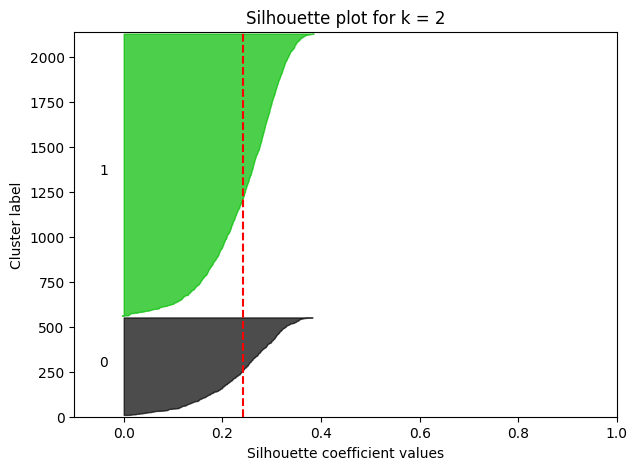

For n_clusters = 4, average silhouette score = 0.134


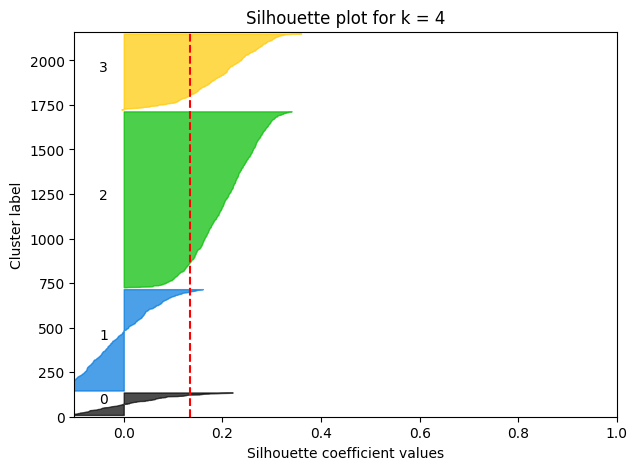

For n_clusters = 6, average silhouette score = 0.119


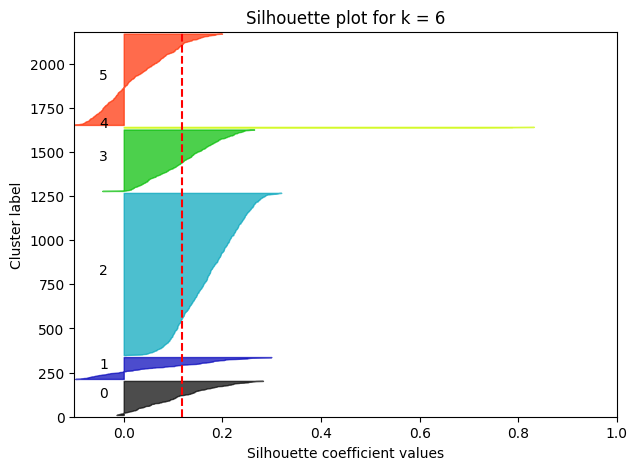

For n_clusters = 8, average silhouette score = 0.085


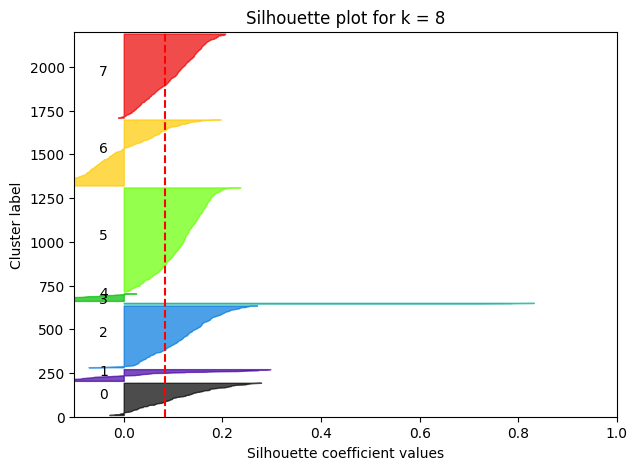

For n_clusters = 10, average silhouette score = 0.086


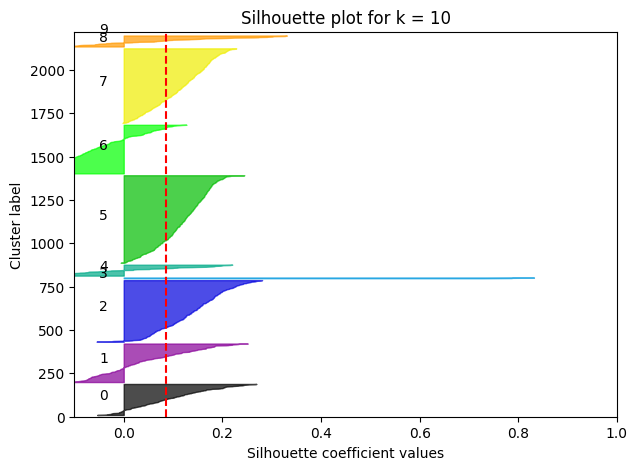

For n_clusters = 12, average silhouette score = 0.084


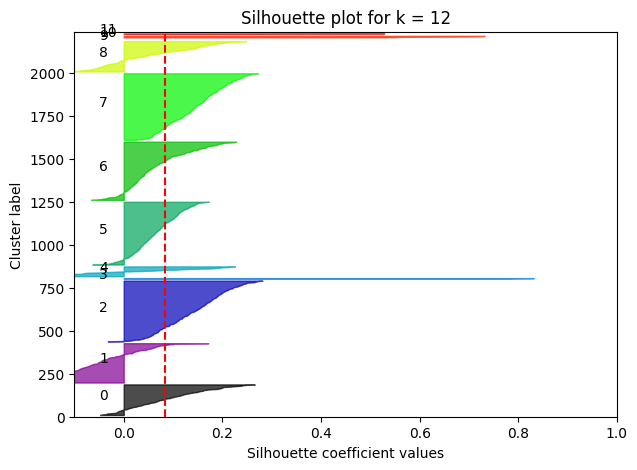

For n_clusters = 14, average silhouette score = 0.089


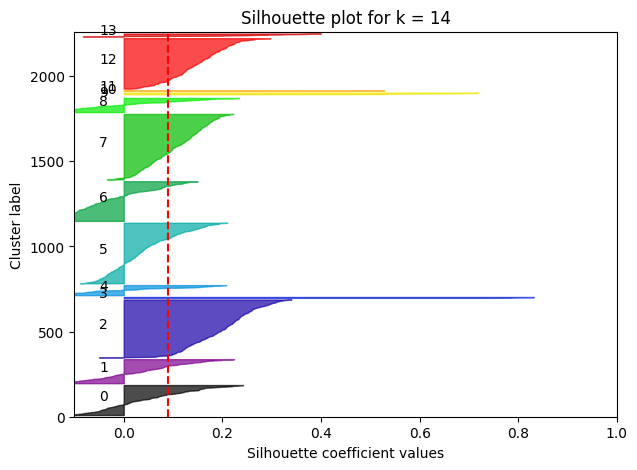

For n_clusters = 16, average silhouette score = 0.094


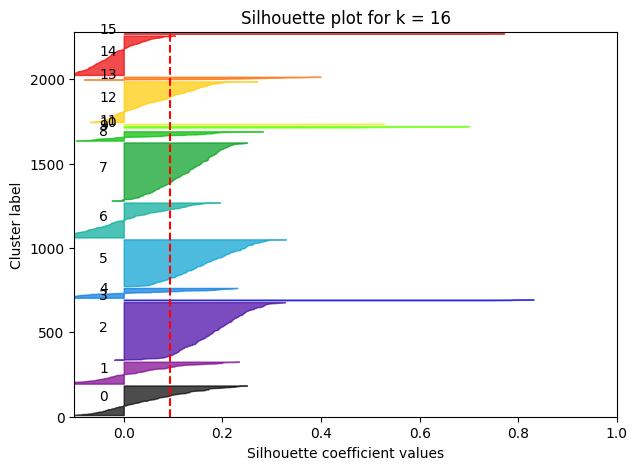

For n_clusters = 18, average silhouette score = 0.089


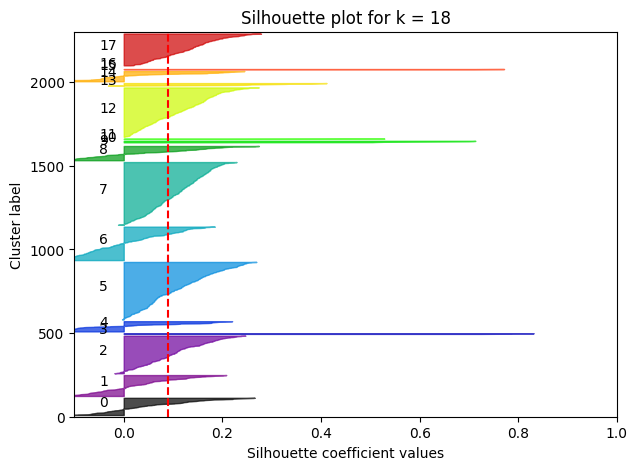

For n_clusters = 20, average silhouette score = 0.090


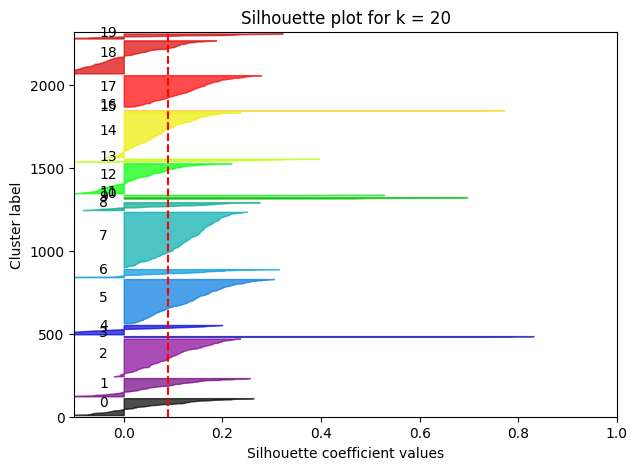

For n_clusters = 22, average silhouette score = 0.086


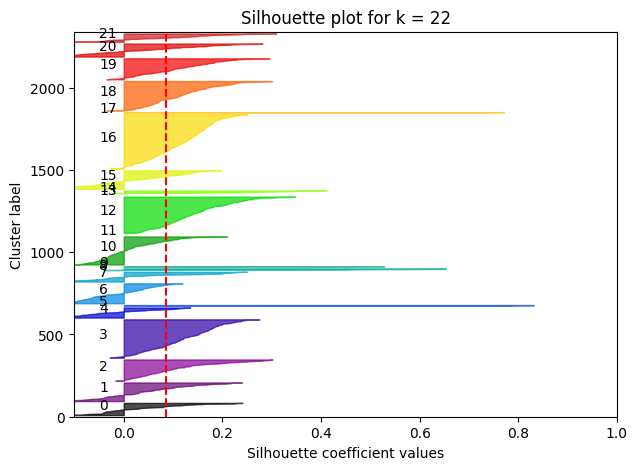

For n_clusters = 24, average silhouette score = 0.087


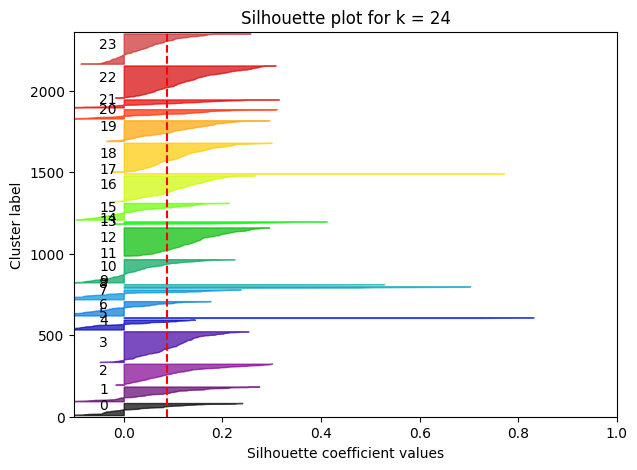

For n_clusters = 26, average silhouette score = 0.084


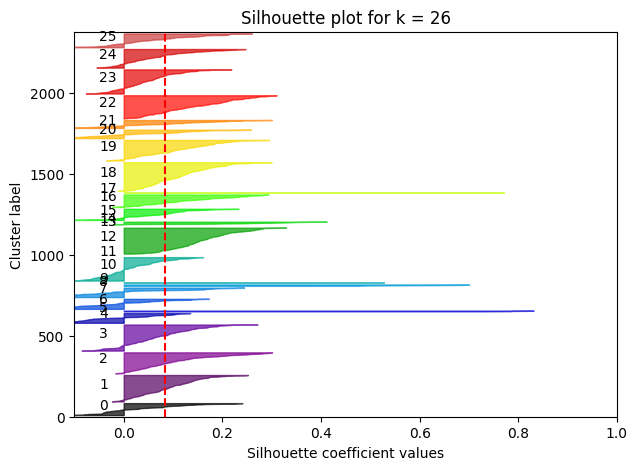

For n_clusters = 28, average silhouette score = 0.083


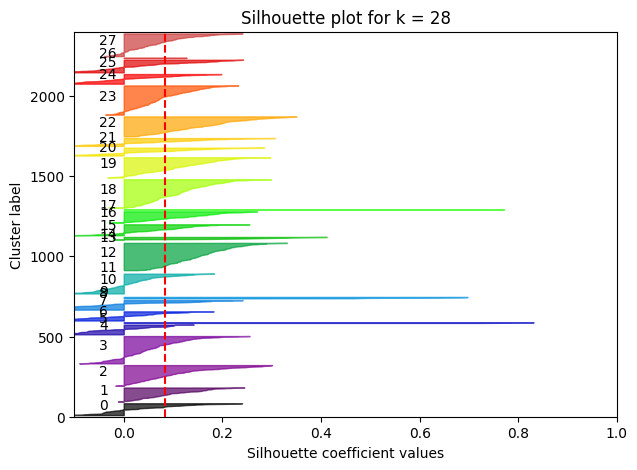

For n_clusters = 30, average silhouette score = 0.085


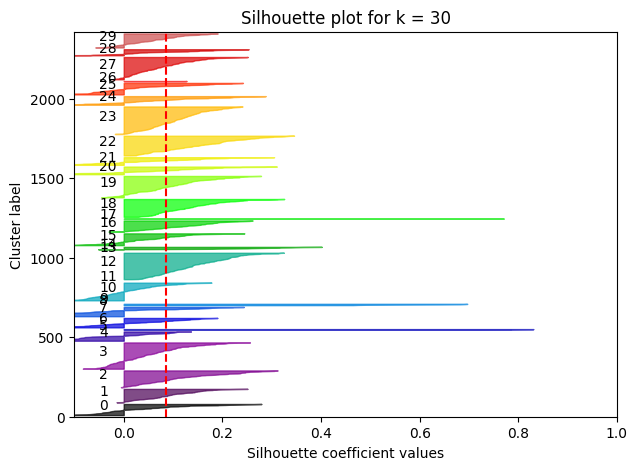

In [84]:
range_n_clusters = range(2, 32, 2)

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_pca)

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")

    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for k = {n_clusters}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

In [85]:
# 1) PCA (use 21 components since it explains ~90%)
pca = PCA(n_components=21, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)

# 2) Similarity (recommend cosine or euclidean)
# Cosine similarity:
sim_cos = cosine_similarity(X_pca)   # higher => more similar

# or distances:
dist_euc = pairwise_distances(X_pca, metric='euclidean')

# Convert distance -> similarity if you want:
sim_from_euc = 1 / (1 + dist_euc)   # simple transform (0..1)

# 3) UMAP for visualization
um = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
X_umap = um.fit_transform(X_scaled_df)

# 4) t-SNE (if you want to compare visuals)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# 5) Clustering example with HDBSCAN (often used on UMAP 2D or PCA)
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
labels_on_umap = clusterer.fit_predict(X_umap)
labels_on_pca = clusterer.fit_predict(X_pca)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

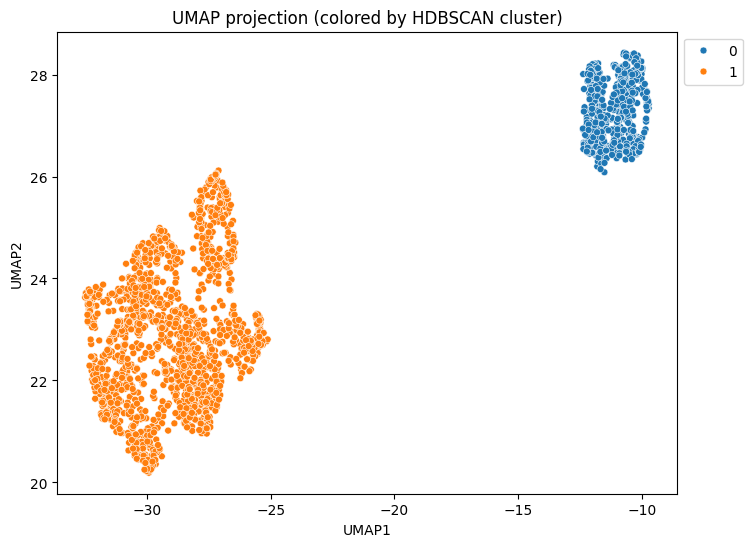

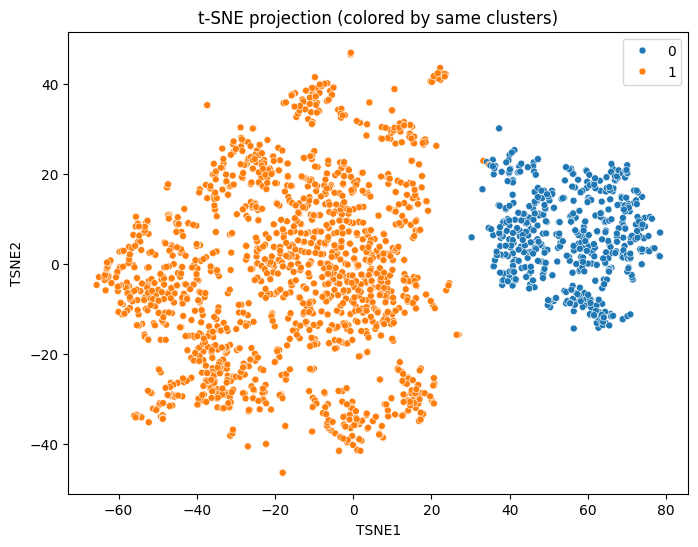

In [86]:
# Build DataFrames to make plotting easier
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['cluster'] = labels_on_umap

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = labels_on_umap  # reuse same clusters for visual comparison
# or df_tsne['cluster'] = labels_on_pca if you want to compare those clusters instead

# --- UMAP ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='cluster', palette='tab10', s=25)
plt.title('UMAP projection (colored by HDBSCAN cluster)')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# --- t-SNE ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10', s=25)
plt.title('t-SNE projection (colored by same clusters)')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [87]:
um_more_comps = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=20, random_state=42)
X_umap_more_comps = um_more_comps.fit_transform(X_scaled_df)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [88]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_imputed.query("pitcher == 543037 and game_year == 2021").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_imputed.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

                  name  game_year  similarity
535        gerrit cole       2020    0.999994
486          joe kelly       2017    0.999991
534        gerrit cole       2019    0.999986
1132  brandon woodruff       2020    0.999974
1633       bryan abreu       2022    0.999971
2083       jared jones       2024    0.999969
1134  brandon woodruff       2022    0.999967
2033      bobby miller       2023    0.999964
487          joe kelly       2018    0.999962
1429    reynaldo lópez       2023    0.999955


/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


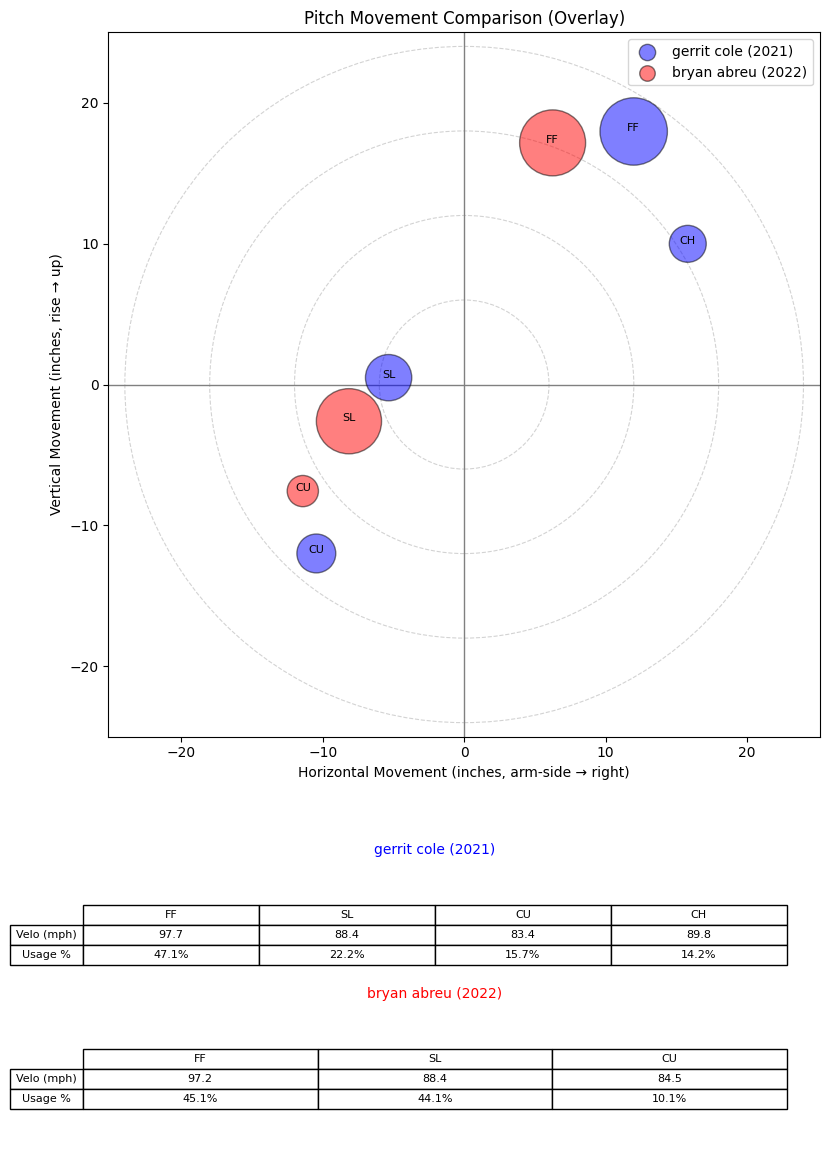

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


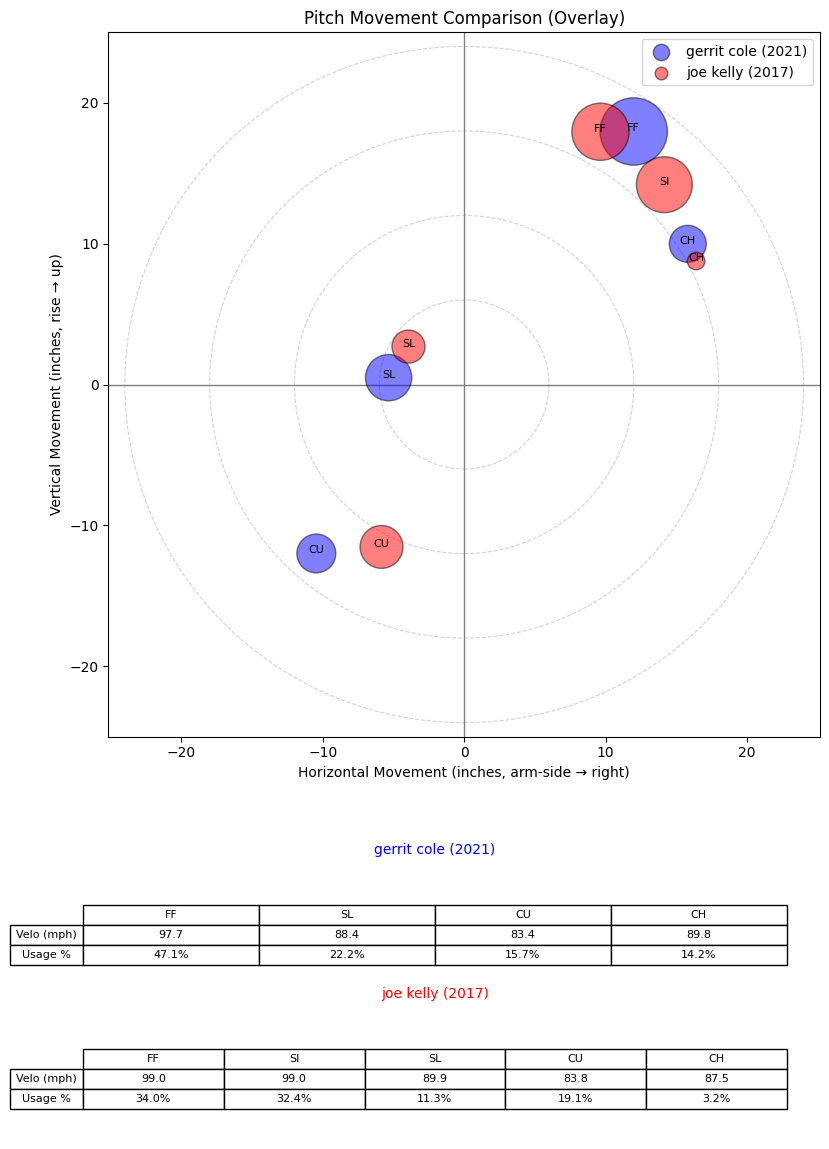

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


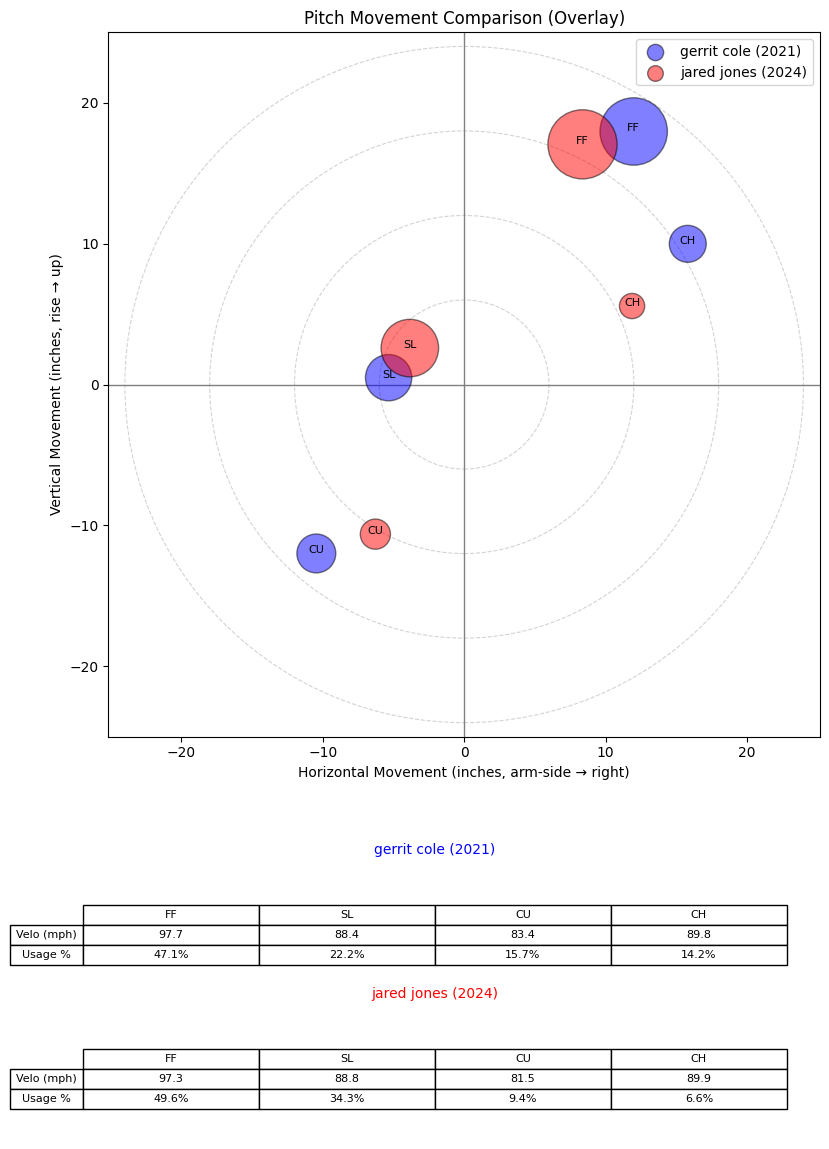

In [62]:
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "bryan abreu", 2022)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "joe kelly", 2017)
compare_pitchers_overlay(movement_long, "gerrit cole", 2021, "jared jones", 2024)

In [89]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels_on_umap = clusterer.fit_predict(X_umap_more_comps)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/iw/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [90]:
pitcher_season_df['cluster_umap_more_comps'] = labels_on_umap

cluster_summary_umap = (
    pitcher_season_df.groupby('cluster_umap_more_comps')
    .mean(numeric_only=True)
    .round(3)
)

display(cluster_summary_umap)

pitcher  game_year  pfx_x_CH  pfx_x_CU  pfx_x_EP  \
cluster_umap_more_comps                                                         
0                        584302.8125   2020.465       1.0     -0.43       0.0   
1                           585535.5   2020.453    -0.836     0.474     0.004   

                         pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  pfx_x_SI  \
cluster_umap_more_comps                                                     
0                          -0.044     0.628     0.001     0.001      0.95   
1                           0.073    -0.606    -0.134    -0.001    -0.898   

                         pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  pfx_z_FC  \
cluster_umap_more_comps                                                     
0                           -0.44     0.569     -0.45       0.0      0.26   
1                           0.441     0.426    -0.497    -0.001     0.263   

                         pfx_z_FF  pfx_z_FS  pfx_z_KN  pfx_z_SI  pfx_z_SL  \
cluster_umap_more_comps                                                     
0                             1.2     0.001      -0.0     0.682     0.093   
1                           1.247     0.071     0.001     0.661     0.123   

                         release_speed_CH  release_speed_CU  release_speed_EP  \
cluster_umap_more_comps                                                         
0                               75.026001            50.653               0.0   
1                               63.641998         51.480999             0.277   

                         release_speed_FC  release_speed_FF  release_speed_FS  \
cluster_umap_more_comps                                                         
0                               35.136002         87.699997             0.161   
1                               33.651001         91.373001            14.822   

                         release_speed_KN  release_speed_SI  release_speed_SL  \
cluster_umap_more_comps                                                         
0                                   0.164         73.962997         65.209999   
1                                   0.192         72.600998         71.117996   

                         release_spin_rate_CH  release_spin_rate_CU  \
cluster_umap_more_comps                                               
0                                    1580.563              1577.770   
1                                    1325.000              1633.023   

                         release_spin_rate_EP  release_spin_rate_FC  \
cluster_umap_more_comps                                               
0                                       0.000               909.357   
1                                       9.086               901.539   

                         release_spin_rate_FF  release_spin_rate_FS  \
cluster_umap_more_comps                                               
0                                    2122.328                 2.099   
1                                    2219.923               242.549   

                         release_spin_rate_KN  release_spin_rate_SI  \
cluster_umap_more_comps                                               
0                                       1.606              1728.688   
1                                       0.898              1701.211   

                         release_spin_rate_SL  spin_axis_CH  spin_axis_CU  \
cluster_umap_more_comps                                                     
0                                    1867.941       109.465       200.628   
1                                    2037.441       175.664        33.486   

                         spin_axis_EP  spin_axis_FC  spin_axis_FF  \
cluster_umap_more_comps                                             
0                                 0.0        72.361       139.246   
1                                0.38        64.977       205.386   

                         spin_axis_FS  spin_axis_KN  spin_axis_SI  \
cluster

In [91]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_df.query("pitcher == 493603 and game_year == 2019").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

                  name  game_year  similarity
2095     carson spiers       2024    0.999969
284      adam ottavino       2022    0.999966
619     michael tonkin       2024    0.999962
2039  garrett whitlock       2023    0.999953
443          dan otero       2018    0.999950
402       steve cishek       2022    0.999933
442          dan otero       2017    0.999927
719        buck farmer       2024    0.999911
173        matt albers       2019    0.999905
1495       trevor gott       2023    0.999902


/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


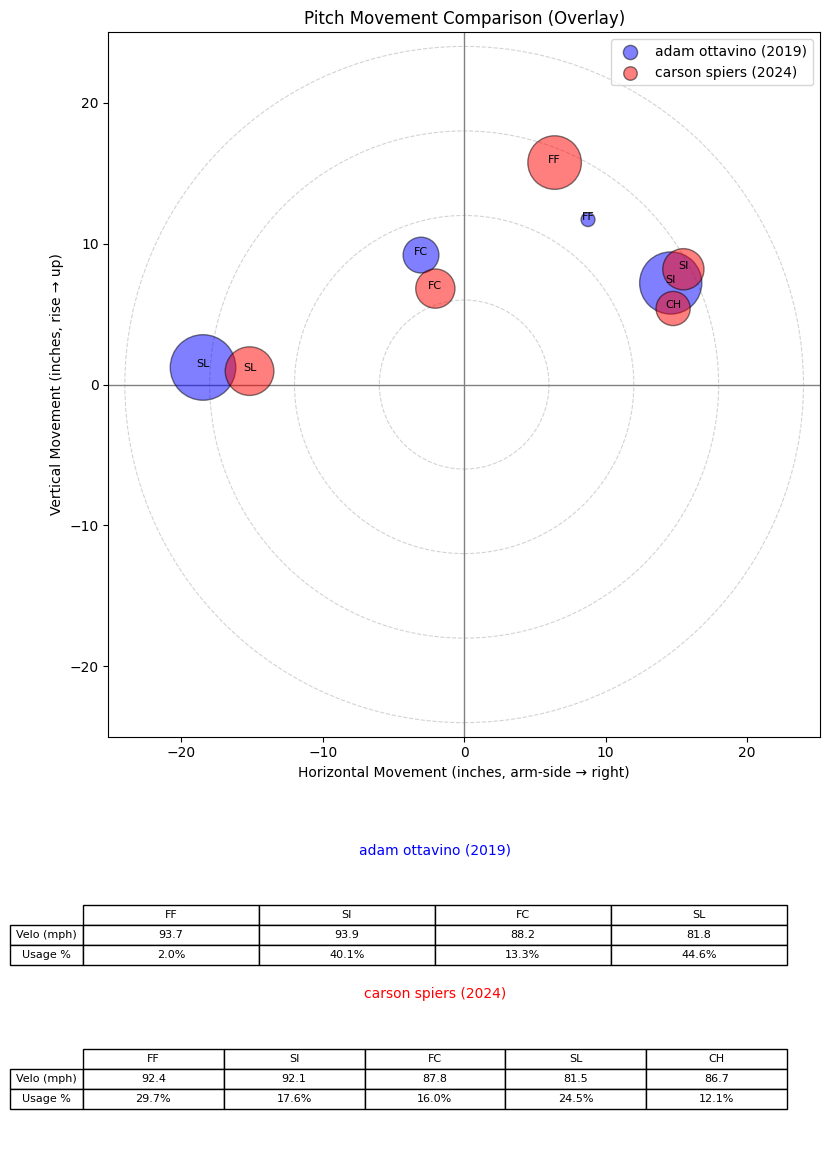

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


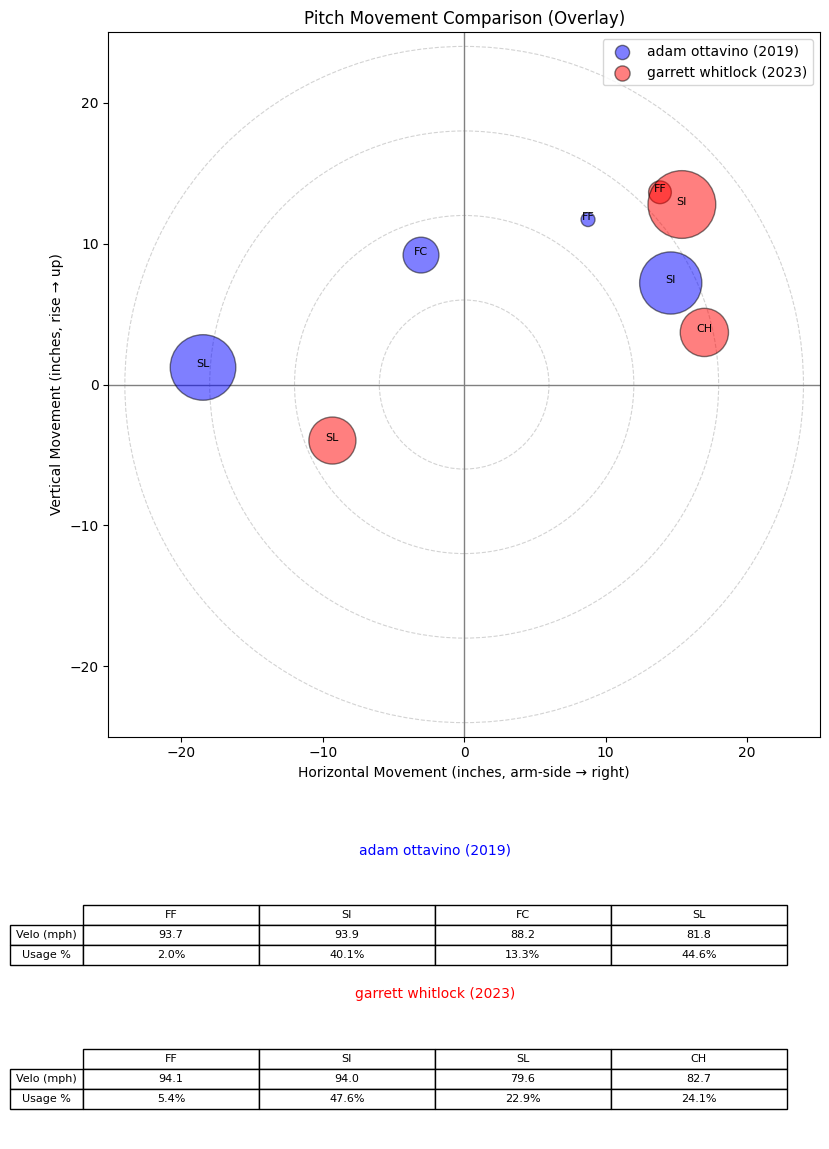

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


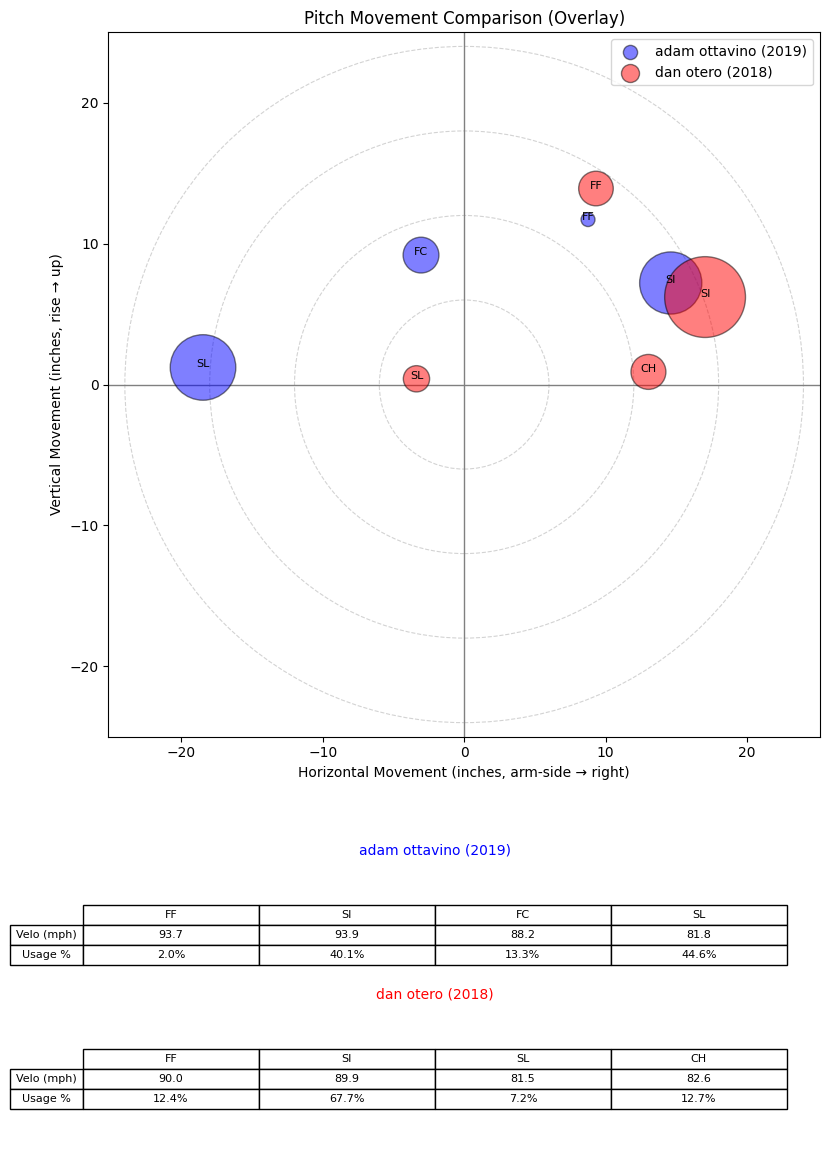

In [66]:
compare_pitchers_overlay(movement_long, "adam ottavino", 2019, "carson spiers", 2024)
compare_pitchers_overlay(movement_long, "adam ottavino", 2019, "garrett whitlock", 2023)
compare_pitchers_overlay(movement_long, "adam ottavino", 2019, "dan otero", 2018)

In [92]:
print(X_scaled_df)

      pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  \
0    -0.750531  0.013017 -0.051383 -0.847253 -0.639988 -0.009176  0.015986   
1    -0.706458  0.013017 -0.051383 -0.995181 -0.593263 -0.009176  0.015986   
2    -0.434344  1.205651 -0.051383 -0.003964 -0.429825 -0.009176  0.015986   
3     1.413482  0.013017 -0.051383 -0.344709  1.279803 -0.009176  0.015986   
4     1.341562  0.013017 -0.051383 -1.323514  1.484599 -0.009176  0.015986   
...        ...       ...       ...       ...       ...       ...       ...   
2106 -0.474551  0.013017 -0.051383 -0.003964 -0.015021 -0.009176  0.015986   
2107 -0.859350  1.215219 -0.051383 -0.003964 -0.248748  2.411369  0.015986   
2108  1.674967  0.013017 -0.051383 -0.003964  1.897983 -0.009176  0.015986   
2109 -0.712466 -0.293760 -0.051383 -1.483716 -0.649321 -0.009176  0.015986   
2110 -0.665491  0.013017 -0.051383 -0.003964 -0.791445 -3.185510  0.015986   

      pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  pfx_z_F

In [93]:
# Cosine similarity
sim_cos_umap = cosine_similarity(X_umap_more_comps)

target_idx = pitcher_season_df.query("pitcher == 687330 and game_year == 2024").index[0]

# Sort similarity values descending
top_similar_idx = np.argsort(sim_cos_umap[target_idx])[::-1][1:11]  # skip self (index 0)

top_similar_pitchers = pitcher_season_df.iloc[top_similar_idx][['name', 'game_year']]
top_similar_pitchers['similarity'] = sim_cos_umap[target_idx, top_similar_idx]

print(top_similar_pitchers)

              name  game_year  similarity
1594   adam cimber       2022    0.999991
398   steve cishek       2018    0.999991
266    sergio romo       2021    0.999991
1592   adam cimber       2019    0.999990
399   steve cishek       2019    0.999989
1593   adam cimber       2021    0.999989
1618  tyler rogers       2022    0.999989
1911  tyson miller       2024    0.999987
1616  tyler rogers       2020    0.999986
2098   kevin kelly       2023    0.999985


/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


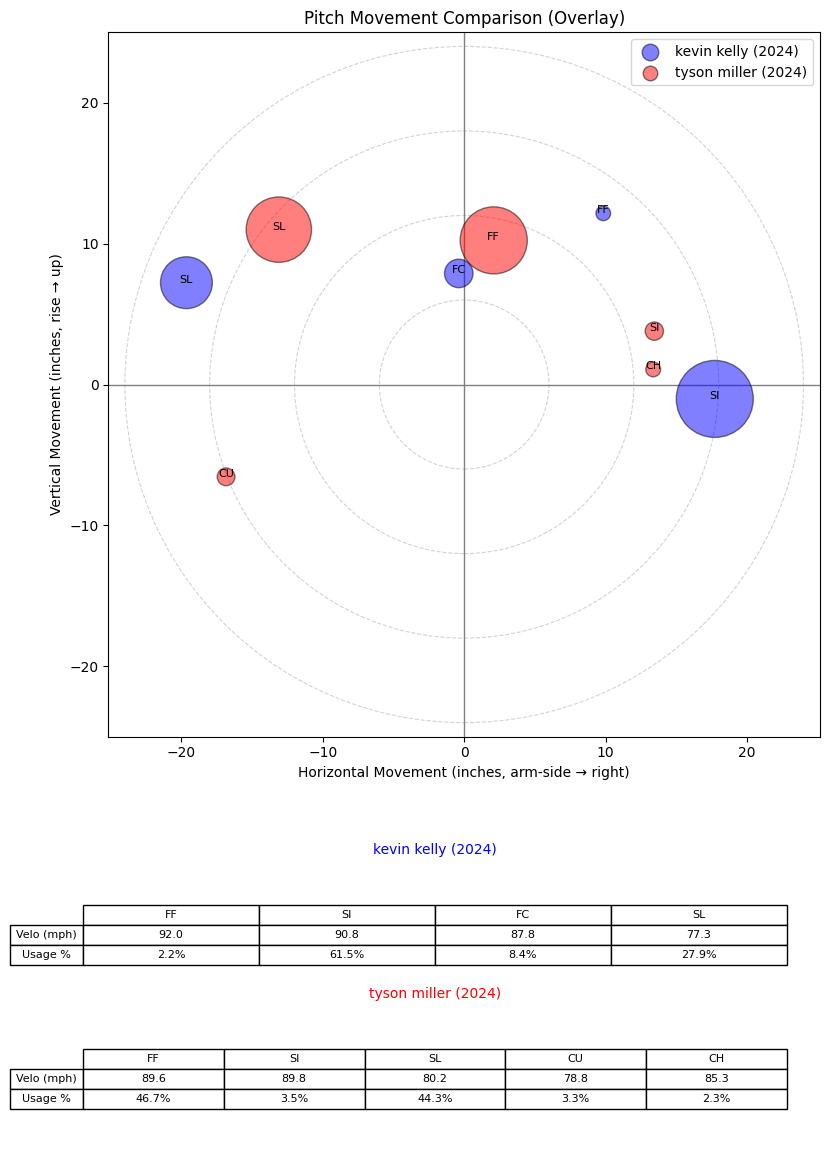

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


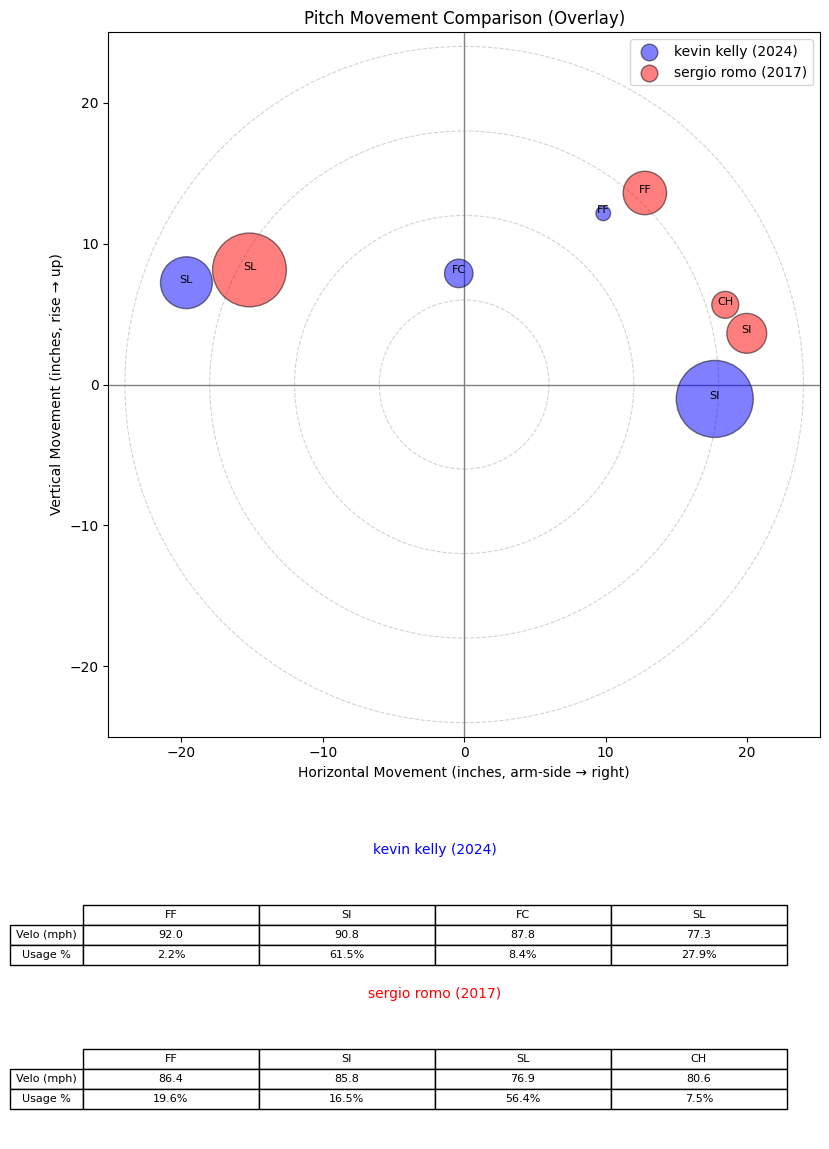

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_1264/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


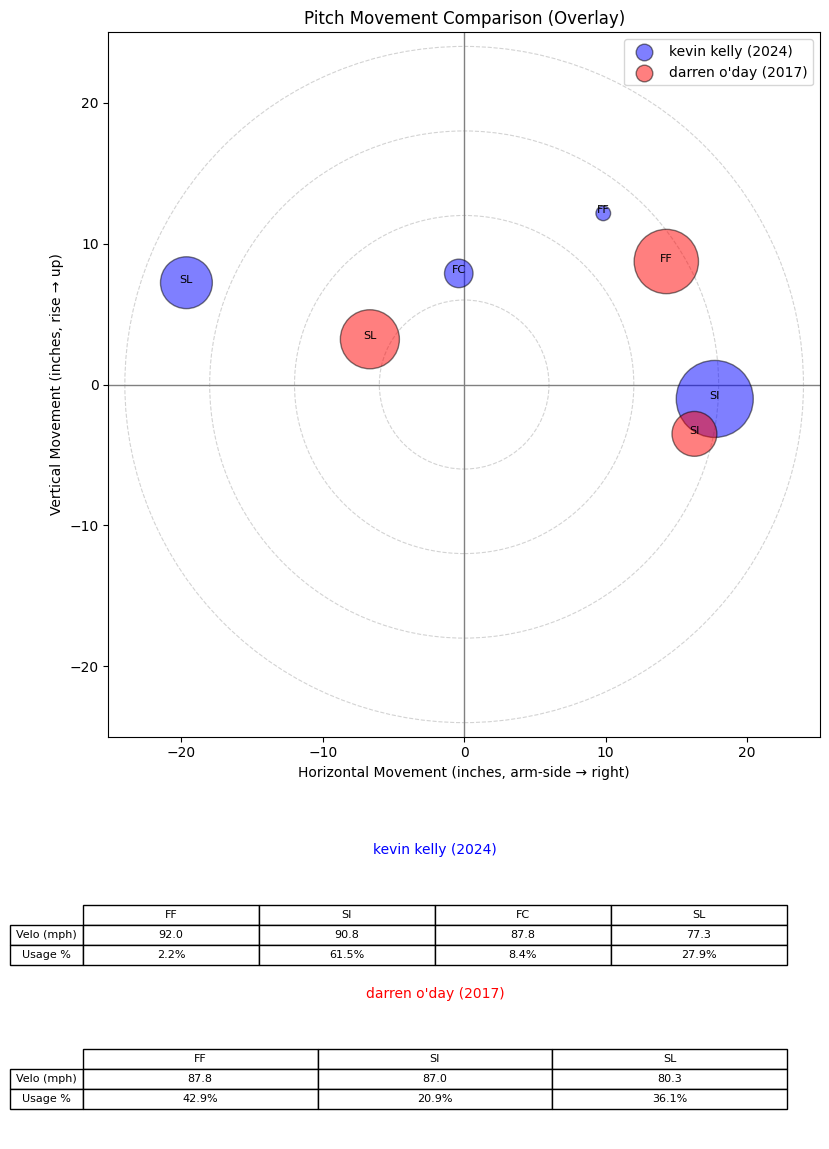

In [68]:
compare_pitchers_overlay(movement_long, "kevin kelly", 2024, "tyson miller", 2024)
compare_pitchers_overlay(movement_long, "kevin kelly", 2024, "sergio romo", 2017)
compare_pitchers_overlay(movement_long, "kevin kelly", 2024, "darren o'day", 2017)

/var/folders/jj/pg09j1dn24d5qgc0lzyrqlr40000gn/T/ipykernel_2109/3616525825.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


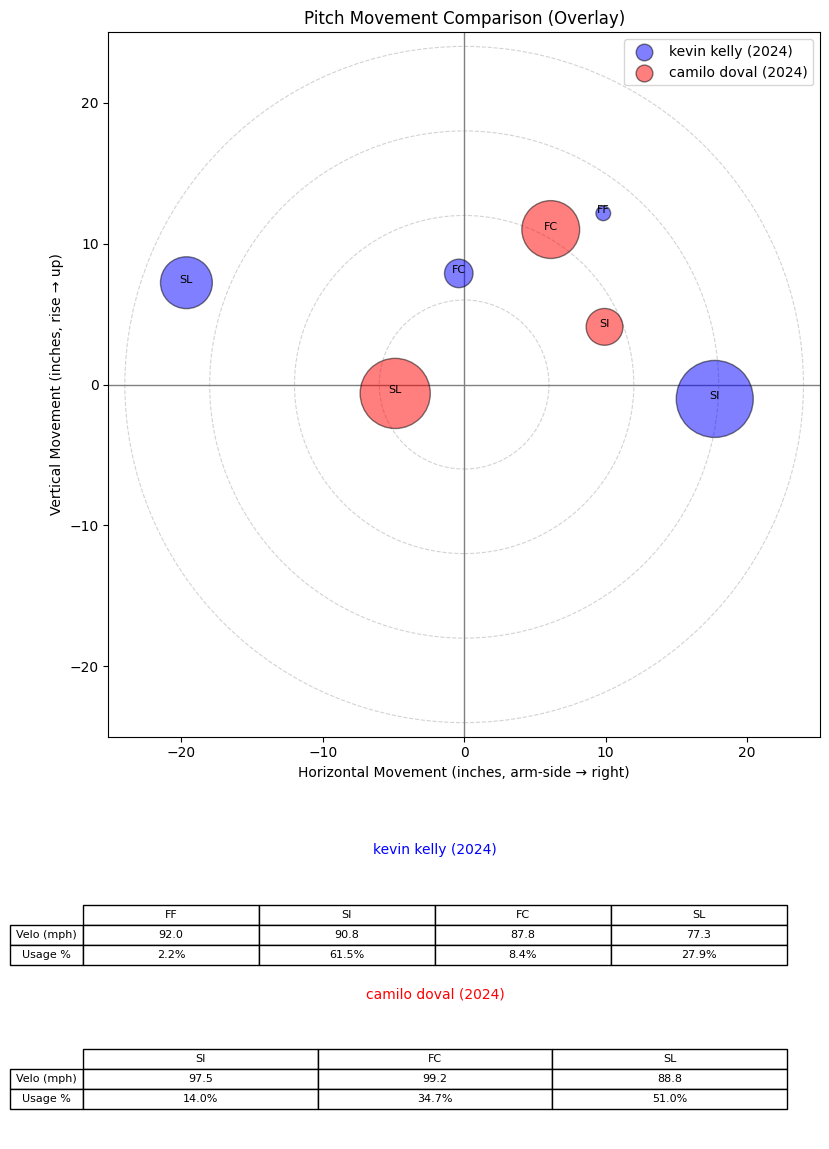

In [207]:
compare_pitchers_overlay(movement_long, "kevin kelly", 2024, "camilo doval", 2024)

In [96]:
n_components_range = range(1, 25)
bics = []
aics = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_pca)
    bics.append(gmm.bic(X_pca))
    aics.append(gmm.aic(X_pca))

best_k = n_components_range[np.argmin(bics)]
best_k

16

In [97]:
gmm = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    n_init=5,
    random_state=42
).fit(X_pca)

cluster_labels = gmm.predict(X_pca)
cluster_probs = gmm.predict_proba(X_pca)

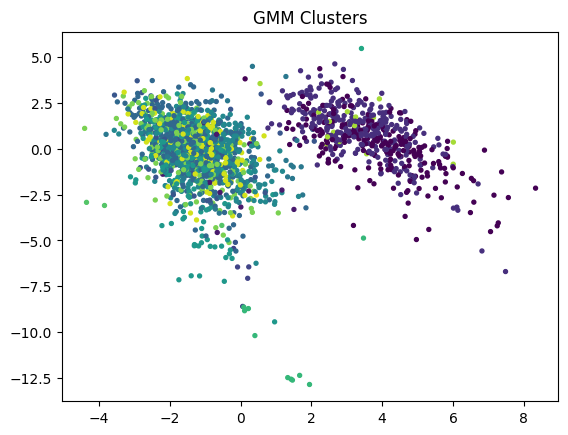

In [98]:
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=cluster_labels,
    s=8
)
plt.title("GMM Clusters")
plt.show()

In [99]:
print(cluster_labels)

[ 7  7  5 ...  2 12  6]


In [100]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(X_scaled_df)
distances, indices = nn.kneighbors(X_scaled_df)

In [101]:
print(X_scaled_df)

      pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  \
0    -0.750531  0.013017 -0.051383 -0.847253 -0.639988 -0.009176  0.015986   
1    -0.706458  0.013017 -0.051383 -0.995181 -0.593263 -0.009176  0.015986   
2    -0.434344  1.205651 -0.051383 -0.003964 -0.429825 -0.009176  0.015986   
3     1.413482  0.013017 -0.051383 -0.344709  1.279803 -0.009176  0.015986   
4     1.341562  0.013017 -0.051383 -1.323514  1.484599 -0.009176  0.015986   
...        ...       ...       ...       ...       ...       ...       ...   
2106 -0.474551  0.013017 -0.051383 -0.003964 -0.015021 -0.009176  0.015986   
2107 -0.859350  1.215219 -0.051383 -0.003964 -0.248748  2.411369  0.015986   
2108  1.674967  0.013017 -0.051383 -0.003964  1.897983 -0.009176  0.015986   
2109 -0.712466 -0.293760 -0.051383 -1.483716 -0.649321 -0.009176  0.015986   
2110 -0.665491  0.013017 -0.051383 -0.003964 -0.791445 -3.185510  0.015986   

      pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  pfx_z_F

In [102]:
X_scaled_df = X_scaled_df.drop(["cluster_umap", "cluster_pca", "cluster_umap_more_comps"], axis=1)

In [103]:
print(X_scaled_df)

      pfx_x_CH  pfx_x_CU  pfx_x_EP  pfx_x_FC  pfx_x_FF  pfx_x_FS  pfx_x_KN  \
0    -0.750531  0.013017 -0.051383 -0.847253 -0.639988 -0.009176  0.015986   
1    -0.706458  0.013017 -0.051383 -0.995181 -0.593263 -0.009176  0.015986   
2    -0.434344  1.205651 -0.051383 -0.003964 -0.429825 -0.009176  0.015986   
3     1.413482  0.013017 -0.051383 -0.344709  1.279803 -0.009176  0.015986   
4     1.341562  0.013017 -0.051383 -1.323514  1.484599 -0.009176  0.015986   
...        ...       ...       ...       ...       ...       ...       ...   
2106 -0.474551  0.013017 -0.051383 -0.003964 -0.015021 -0.009176  0.015986   
2107 -0.859350  1.215219 -0.051383 -0.003964 -0.248748  2.411369  0.015986   
2108  1.674967  0.013017 -0.051383 -0.003964  1.897983 -0.009176  0.015986   
2109 -0.712466 -0.293760 -0.051383 -1.483716 -0.649321 -0.009176  0.015986   
2110 -0.665491  0.013017 -0.051383 -0.003964 -0.791445 -3.185510  0.015986   

      pfx_x_SI  pfx_x_SL  pfx_z_CH  pfx_z_CU  pfx_z_EP  pfx_z_F

In [105]:
cov_matrix = np.cov(X_scaled_df.values, rowvar=False)
cov_inv = np.linalg.pinv(cov_matrix)

nn = NearestNeighbors(metric='mahalanobis', metric_params={'VI': cov_inv})
nn.fit(X_scaled_df)
distances, indices = nn.kneighbors(X_scaled_df)


In [107]:
i = X_scaled_df.index.get_loc(("gerrit cole", 2021))
neighbor_indices = indices[i]
neighbor_distances = distances[i]

neighbors = X_scaled_df.iloc[neighbor_indices].copy()
neighbors["distance"] = neighbor_distances

KeyError: ('gerrit cole', 2021)

In [111]:
print(pitcher_season_df.columns)

Index(['pitcher', 'game_year', 'pfx_x_CH', 'pfx_x_CU', 'pfx_x_EP', 'pfx_x_FC',
       'pfx_x_FF', 'pfx_x_FS', 'pfx_x_KN', 'pfx_x_SI', 'pfx_x_SL', 'pfx_z_CH',
       'pfx_z_CU', 'pfx_z_EP', 'pfx_z_FC', 'pfx_z_FF', 'pfx_z_FS', 'pfx_z_KN',
       'pfx_z_SI', 'pfx_z_SL', 'release_speed_CH', 'release_speed_CU',
       'release_speed_EP', 'release_speed_FC', 'release_speed_FF',
       'release_speed_FS', 'release_speed_KN', 'release_speed_SI',
       'release_speed_SL', 'release_spin_rate_CH', 'release_spin_rate_CU',
       'release_spin_rate_EP', 'release_spin_rate_FC', 'release_spin_rate_FF',
       'release_spin_rate_FS', 'release_spin_rate_KN', 'release_spin_rate_SI',
       'release_spin_rate_SL', 'spin_axis_CH', 'spin_axis_CU', 'spin_axis_EP',
       'spin_axis_FC', 'spin_axis_FF', 'spin_axis_FS', 'spin_axis_KN',
       'spin_axis_SI', 'spin_axis_SL', 'CH_frac', 'CU_frac', 'EP_frac',
       'FC_frac', 'FF_frac', 'FS_frac', 'KN_frac', 'SI_frac', 'SL_frac',
       'release_pos_x', 'relea

In [138]:
# Make sure this matches your pitch_grouped labels
pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KN', 'SI', 'SL']  # adjust if needed

# 1) Compute league-average per pitch type for each pitch-specific column
league_avg = {}

for pitch in pitch_types:
    # all columns for this pitch type, e.g. release_speed_FF, pfx_x_FF, ...
    pitch_cols = [col for col in pitcher_season_df.columns if col.endswith(f'_{pitch}') and not col.startswith('throws')]

    if not pitch_cols:
        continue  # skip if this pitch isn't present

    # Only use pitchers who actually throw this pitch
    throws_col = f'throws_{pitch}'
    if throws_col not in pitcher_season_df.columns:
        raise ValueError(f"{throws_col} missing in pitcher_season_df")

    mask_throws = pitcher_season_df[throws_col] > 0
    league_avg[pitch] = pitcher_season_df.loc[mask_throws, pitch_cols].mean()

In [139]:
# 2) Create delta-feature dataframe
pitcher_season_delta = pitcher_season_df.copy()

for pitch in pitch_types:
    pitch_cols = [col for col in pitcher_season_df.columns if col.endswith(f'_{pitch}')]

    if not pitch_cols:
        continue

    mu = league_avg[pitch]  # Series indexed by pitch_cols
    throws_col = f'throws_{pitch}'
    throws = pitcher_season_df[throws_col].values.reshape(-1, 1)  # shape (n_rows, 1)

    # raw deltas = value - league average for that pitch type
    deltas = pitcher_season_df[pitch_cols].sub(mu, axis='columns')

    # multiply by throws mask: if throws==0 → deltas become 0
    deltas = deltas.mul(throws)

    pitcher_season_delta[pitch_cols] = deltas

In [140]:
# 3) Build feature matrix from delta dataframe

id_cols = ['pitcher', 'game_year', 'name', 'name_first', 'name_last']
non_feature_prefixes = ['throws_', 'pitch_count_']

non_feature_cols = set(id_cols)
non_feature_cols.update(
    [c for c in pitcher_season_delta.columns 
     if any(c.startswith(pref) for pref in non_feature_prefixes)]
)

# Start from all "real" features
feature_cols = [
    c for c in pitcher_season_delta.columns
    if c not in non_feature_cols
]

# 🚫 Drop spin-related stuff
drop_substrings = ['spin_axis', 'release_spin_rate']

feature_cols = [
    c for c in feature_cols
    if not any(sub in c for sub in drop_substrings)
]

# (Optional sanity check)
print("Using", len(feature_cols), "features")
print([c for c in feature_cols if 'spin' in c.lower()])  # should print [] if everything spin-related is gone

# Then standardize
scaler_delta = StandardScaler()
X_delta = scaler_delta.fit_transform(pitcher_season_delta[feature_cols])

X_delta_df = pd.DataFrame(
    X_delta,
    columns=feature_cols,
    index=pitcher_season_delta.index
)


Using 39 features
[]


In [141]:
# 4) PCA for clustering / structure understanding (NOT for similarity!)

pca = PCA(n_components=24, random_state=42)   # adjust n_components after checking explained variance
X_pca = pca.fit_transform(X_delta_df)

X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=pitcher_season_delta.index
)

print("Explained variance ratio:", pca.explained_variance_ratio_.sum())


Explained variance ratio: 0.8986535825380266


In [142]:
# 5) UMAP for 2D visualization (optional; don't use for similarity)

umap_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap_2d = umap_2d.fit_transform(X_delta_df)

umap_2d_df = pd.DataFrame(
    X_umap_2d,
    columns=['UMAP1', 'UMAP2'],
    index=pitcher_season_delta.index
)

/opt/miniconda3/envs/iw/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [143]:
# 6) Cosine similarity in delta space

cos_sim_delta = cosine_similarity(X_delta_df)
cos_sim_delta_df = pd.DataFrame(
    cos_sim_delta,
    index=pitcher_season_delta.index,
    columns=pitcher_season_delta.index
)


In [144]:
def get_neighbors_by_id(pitcher_id, year, k=10):
    """
    Return top-k most similar pitcher-seasons to a given (pitcher_id, year)
    using cosine similarity in delta space.
    """
    # locate row index
    mask = (pitcher_season_delta['pitcher'] == pitcher_id) & (pitcher_season_delta['game_year'] == year)
    if not mask.any():
        raise ValueError(f"No row found for pitcher={pitcher_id}, year={year}")
    
    target_idx = pitcher_season_delta.index[mask][0]
    
    sims = cos_sim_delta[target_idx]
    order = np.argsort(sims)[::-1]  # descending
    # drop self (first element)
    neighbors = [i for i in order if i != target_idx][:k]
    
    out = pitcher_season_delta.loc[neighbors, ['pitcher', 'name', 'game_year']].copy()
    out['similarity'] = sims[neighbors]
    return out

# Example:
# gerrit cole 2021 if his pitcher id is 543037
# get_neighbors_by_id(543037, 2021, k=10)


In [145]:
# 7) KMeans clustering on PCA space (you can also try GMM or HDBSCAN)

kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')  # n_clusters ~ 15–30 is a good search range
cluster_labels = kmeans.fit_predict(X_pca_df)

pitcher_season_delta['cluster_kmeans'] = cluster_labels

For n_clusters = 2, average silhouette score = 0.192


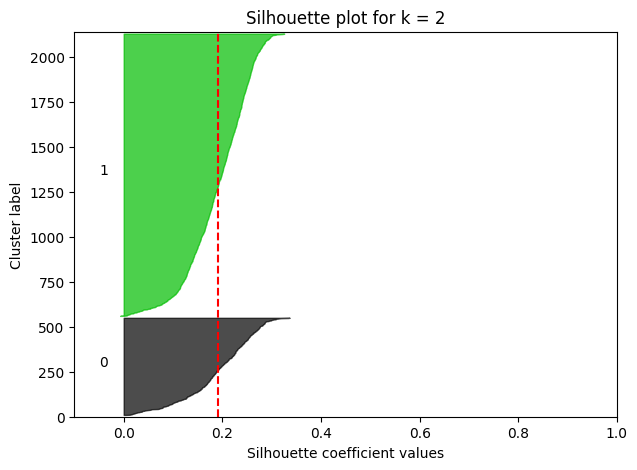

For n_clusters = 4, average silhouette score = 0.131


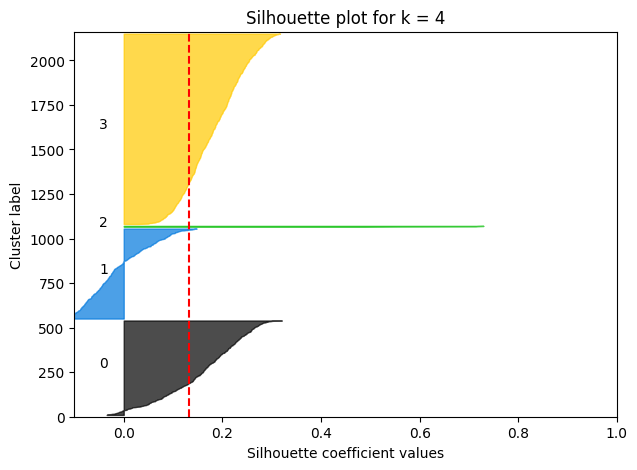

For n_clusters = 6, average silhouette score = 0.106


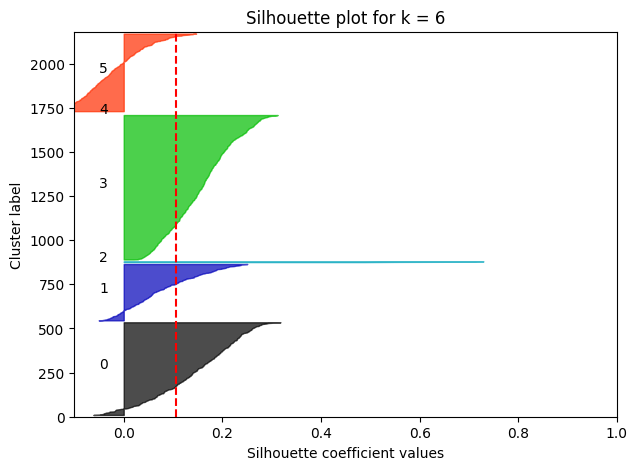

For n_clusters = 8, average silhouette score = 0.089


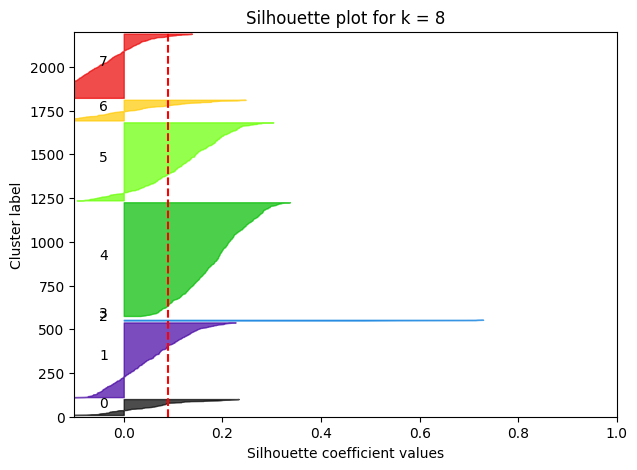

For n_clusters = 10, average silhouette score = 0.091


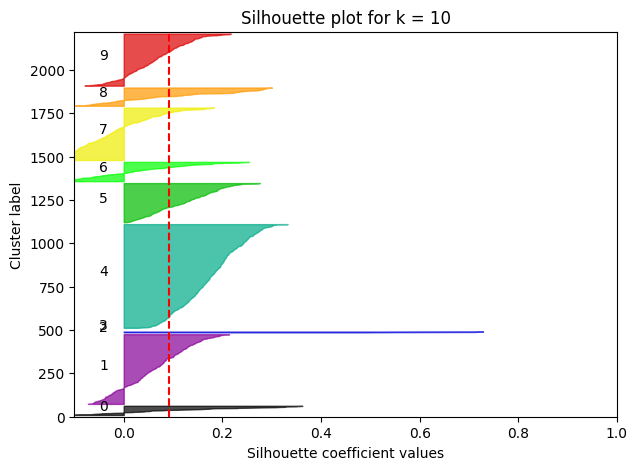

For n_clusters = 12, average silhouette score = 0.087


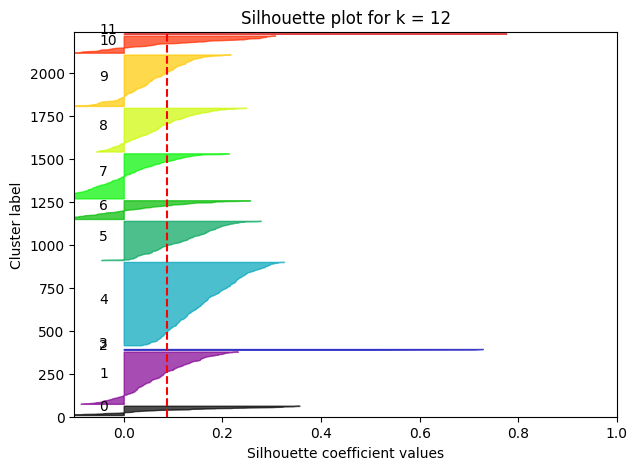

For n_clusters = 14, average silhouette score = 0.094


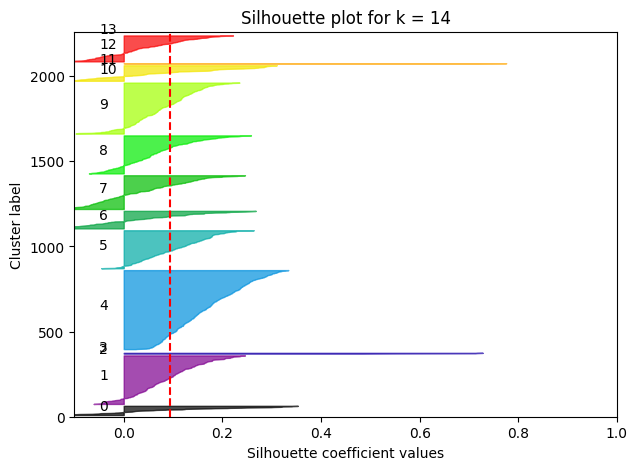

For n_clusters = 16, average silhouette score = 0.096


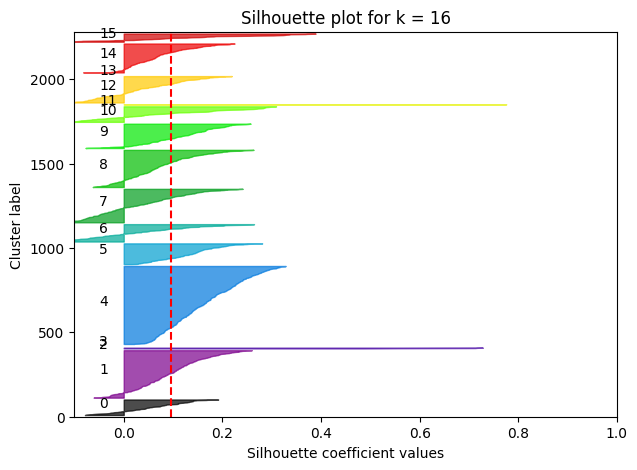

For n_clusters = 18, average silhouette score = 0.092


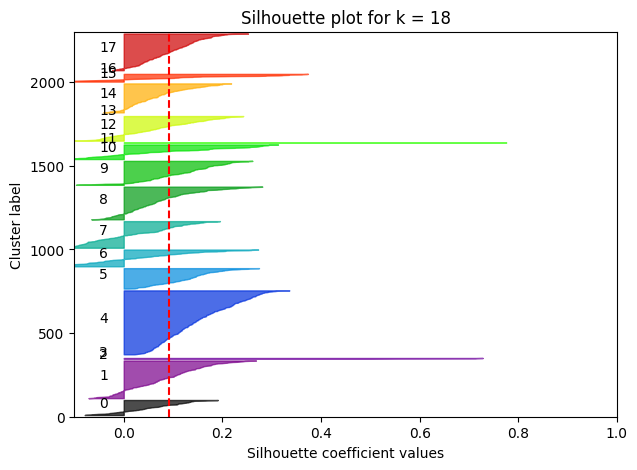

For n_clusters = 20, average silhouette score = 0.093


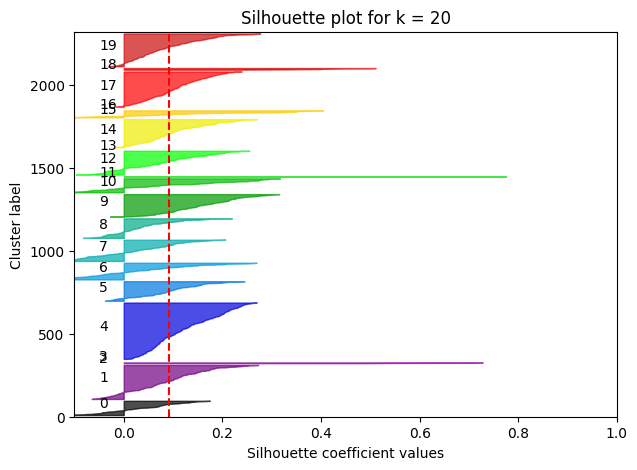

For n_clusters = 22, average silhouette score = 0.089


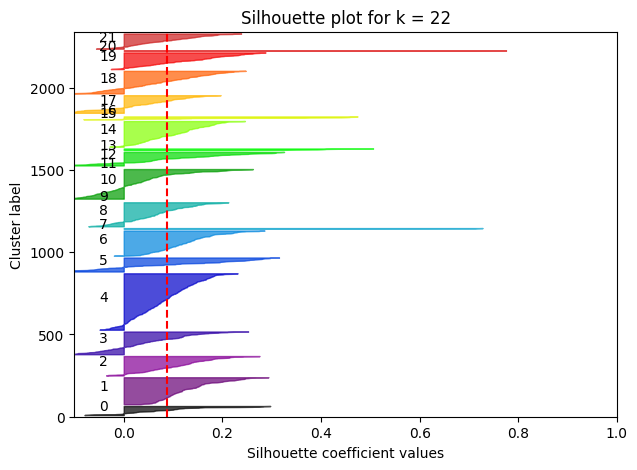

For n_clusters = 24, average silhouette score = 0.094


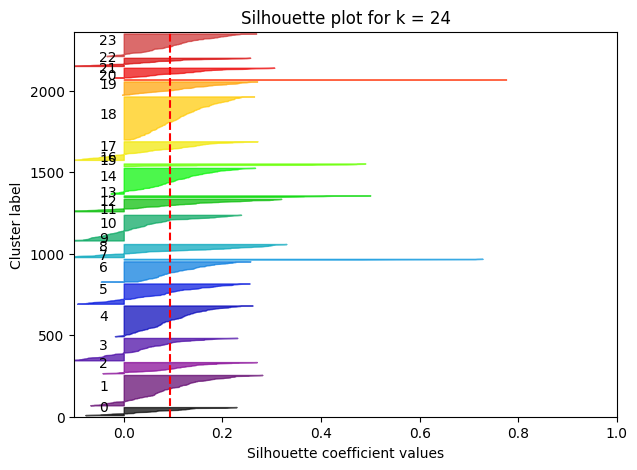

For n_clusters = 26, average silhouette score = 0.087


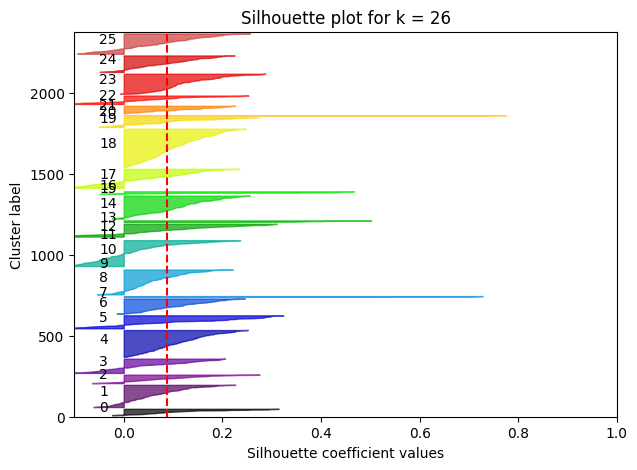

For n_clusters = 28, average silhouette score = 0.089


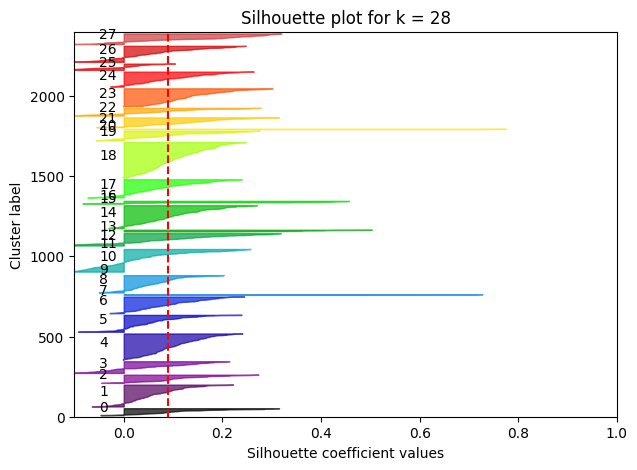

For n_clusters = 30, average silhouette score = 0.096


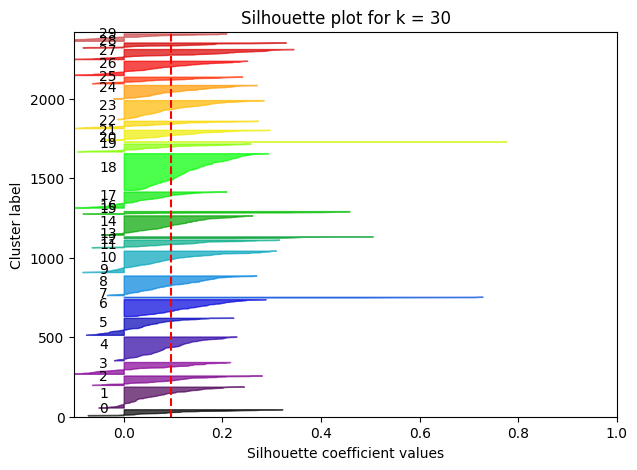

In [150]:
range_n_clusters = range(2, 32, 2)

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca_df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_pca_df)

    silhouette_avg = silhouette_score(X_pca_df, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")

    sample_silhouette_values = silhouette_samples(X_pca_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for k = {n_clusters}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

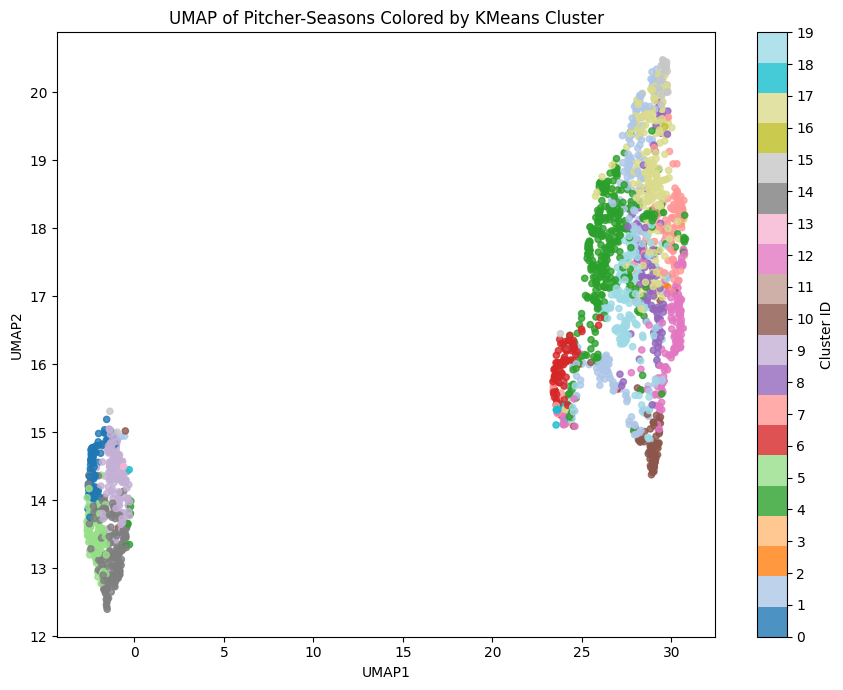

In [146]:
# Make sure indices align (they should if you followed previous code)
assert all(umap_2d_df.index == pitcher_season_delta.index)

clusters = pitcher_season_delta['cluster_kmeans'].values

plt.figure(figsize=(9, 7))
scatter = plt.scatter(
    umap_2d_df['UMAP1'],
    umap_2d_df['UMAP2'],
    c=clusters,
    s=20,
    alpha=0.8,
    cmap='tab20'  # good for up to ~20 clusters
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of Pitcher-Seasons Colored by KMeans Cluster")
cbar = plt.colorbar(scatter, ticks=np.unique(clusters))
cbar.set_label("Cluster ID")
plt.tight_layout()
plt.show()

In [147]:
# Average feature values per cluster (cluster centroids in delta space)
cluster_feature_means = pitcher_season_delta.groupby('cluster_kmeans')[feature_cols].mean()

# Look at one cluster
cluster_id = 0  # try different cluster IDs
cluster_feature_means.loc[cluster_id].sort_values(ascending=False).head(20)


release_extension    6.208071
release_pos_z        5.540149
release_pos_x        2.402699
pfx_x_CH             1.519052
pfx_x_SI             1.399466
pfx_x_FF             0.789035
SI_frac              0.266471
FC_frac              0.223406
FF_frac              0.184086
CH_frac              0.149156
SL_frac              0.114344
pfx_z_CU             0.113739
CU_frac              0.059278
pfx_x_FS                  0.0
EP_frac                   0.0
FS_frac                   0.0
KN_frac                   0.0
release_speed_KN          0.0
release_speed_FS          0.0
pfx_x_KN                  0.0
Name: 0, dtype: Float64

In [148]:
def summarize_cluster(cluster_id, pitch='FF', top_n=10):
    """
    Show the top N above/below-average features for a given pitch type in a cluster.
    """
    prefix_cols = [c for c in feature_cols if c.endswith(f'_{pitch}')]
    row = cluster_feature_means.loc[cluster_id, prefix_cols].sort_values()

    print(f"=== Cluster {cluster_id}, pitch {pitch} ===")
    print("Most below-average:")
    print(row.head(top_n))
    print("\nMost above-average:")
    print(row.tail(top_n))

# Example:
summarize_cluster(0, pitch='FF')
summarize_cluster(0, pitch='SL')
summarize_cluster(0, pitch='SI')


=== Cluster 0, pitch FF ===
Most below-average:
release_speed_FF   -1.995639
pfx_z_FF           -0.137598
pfx_x_FF            0.789035
Name: 0, dtype: Float64

Most above-average:
release_speed_FF   -1.995639
pfx_z_FF           -0.137598
pfx_x_FF            0.789035
Name: 0, dtype: Float64
=== Cluster 0, pitch SL ===
Most below-average:
release_speed_SL   -3.827394
pfx_x_SL           -0.783559
pfx_z_SL           -0.072744
Name: 0, dtype: Float64

Most above-average:
release_speed_SL   -3.827394
pfx_x_SL           -0.783559
pfx_z_SL           -0.072744
Name: 0, dtype: Float64
=== Cluster 0, pitch SI ===
Most below-average:
release_speed_SI    -1.92139
pfx_z_SI           -0.243446
pfx_x_SI            1.399466
Name: 0, dtype: Float64

Most above-average:
release_speed_SI    -1.92139
pfx_z_SI           -0.243446
pfx_x_SI            1.399466
Name: 0, dtype: Float64


In [149]:
def inspect_cluster_members(cluster_id, n=20):
    cols_to_show = ['pitcher', 'name', 'game_year']
    return pitcher_season_delta.loc[
        pitcher_season_delta['cluster_kmeans'] == cluster_id,
        cols_to_show
    ].head(n)

inspect_cluster_members(0, n=30)


pitcher               name  game_year
4    282332.0        cc sabathia       2018
83   448179.0          rich hill       2023
240  476595.0       lucas luetge       2021
241  476595.0       lucas luetge       2022
260  489119.0         wade miley       2021
261  489119.0         wade miley       2023
299  501625.0       josé álvarez       2019
300  501625.0       josé álvarez       2021
385  518445.0          chad bell       2017
393  518516.0  madison bumgarner       2018
395  518516.0  madison bumgarner       2020
435  519008.0    t. j. mcfarland       2019
436  519008.0    t. j. mcfarland       2020
437  519008.0    t. j. mcfarland       2024
489  527048.0       martín pérez       2019
524  542947.0     richard bleier       2017
525  542947.0     richard bleier       2019
526  542947.0     richard bleier       2021
612  543734.0        chris rusin       2018
662  548384.0       brooks raley       2020
663  548384.0       brooks raley       2023
714  571578.0     patrick corbin       2024
744  571901.0         aaron loup       2017
745  571901.0         aaron loup       2020
746  571901.0         aaron loup       2021
747  571901.0         aaron loup       2022
757  571948.0        hoby milner       2022
758  571948.0        hoby milner       2023
759  571948.0        hoby milner       2024
787  572971.0     dallas keuchel       2017